In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

import time

import utils.plot_utls as plt_utils
import utils.metrics as m_utils
from yellowbrick.classifier import PrecisionRecallCurve
import utils.visualizations as viz
import utils.metrics as metrics
import utils.training as training

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
SEED = 42
np.random.seed(SEED)
plt_utils.setup_plots()

In [4]:
df = pd.read_csv('../datasets/credit-card/credit-card-small.csv', delimiter=';', encoding='utf-8')
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

scaler = MinMaxScaler()

X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)

X_n = np.concatenate((X_train_n, X_test_n), axis=0)

CV = 5
NUMBER_OF_FEATURES = 30

In [5]:
CREDIT_CARDS_PATH = f'{os.getcwd()}/../figures/credit-cards'

# Decision Tree

### Plan

1. Train baseline decision tree without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `min_samples_leaf`
    b. `max_depth`
    c. `ccp_alpha`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [6]:
CREDIT_CARDS_DT_PATH = f'{CREDIT_CARDS_PATH}/dt'

In [7]:
dt_baseline_clf = DecisionTreeClassifier(random_state=SEED)
dt_baseline_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

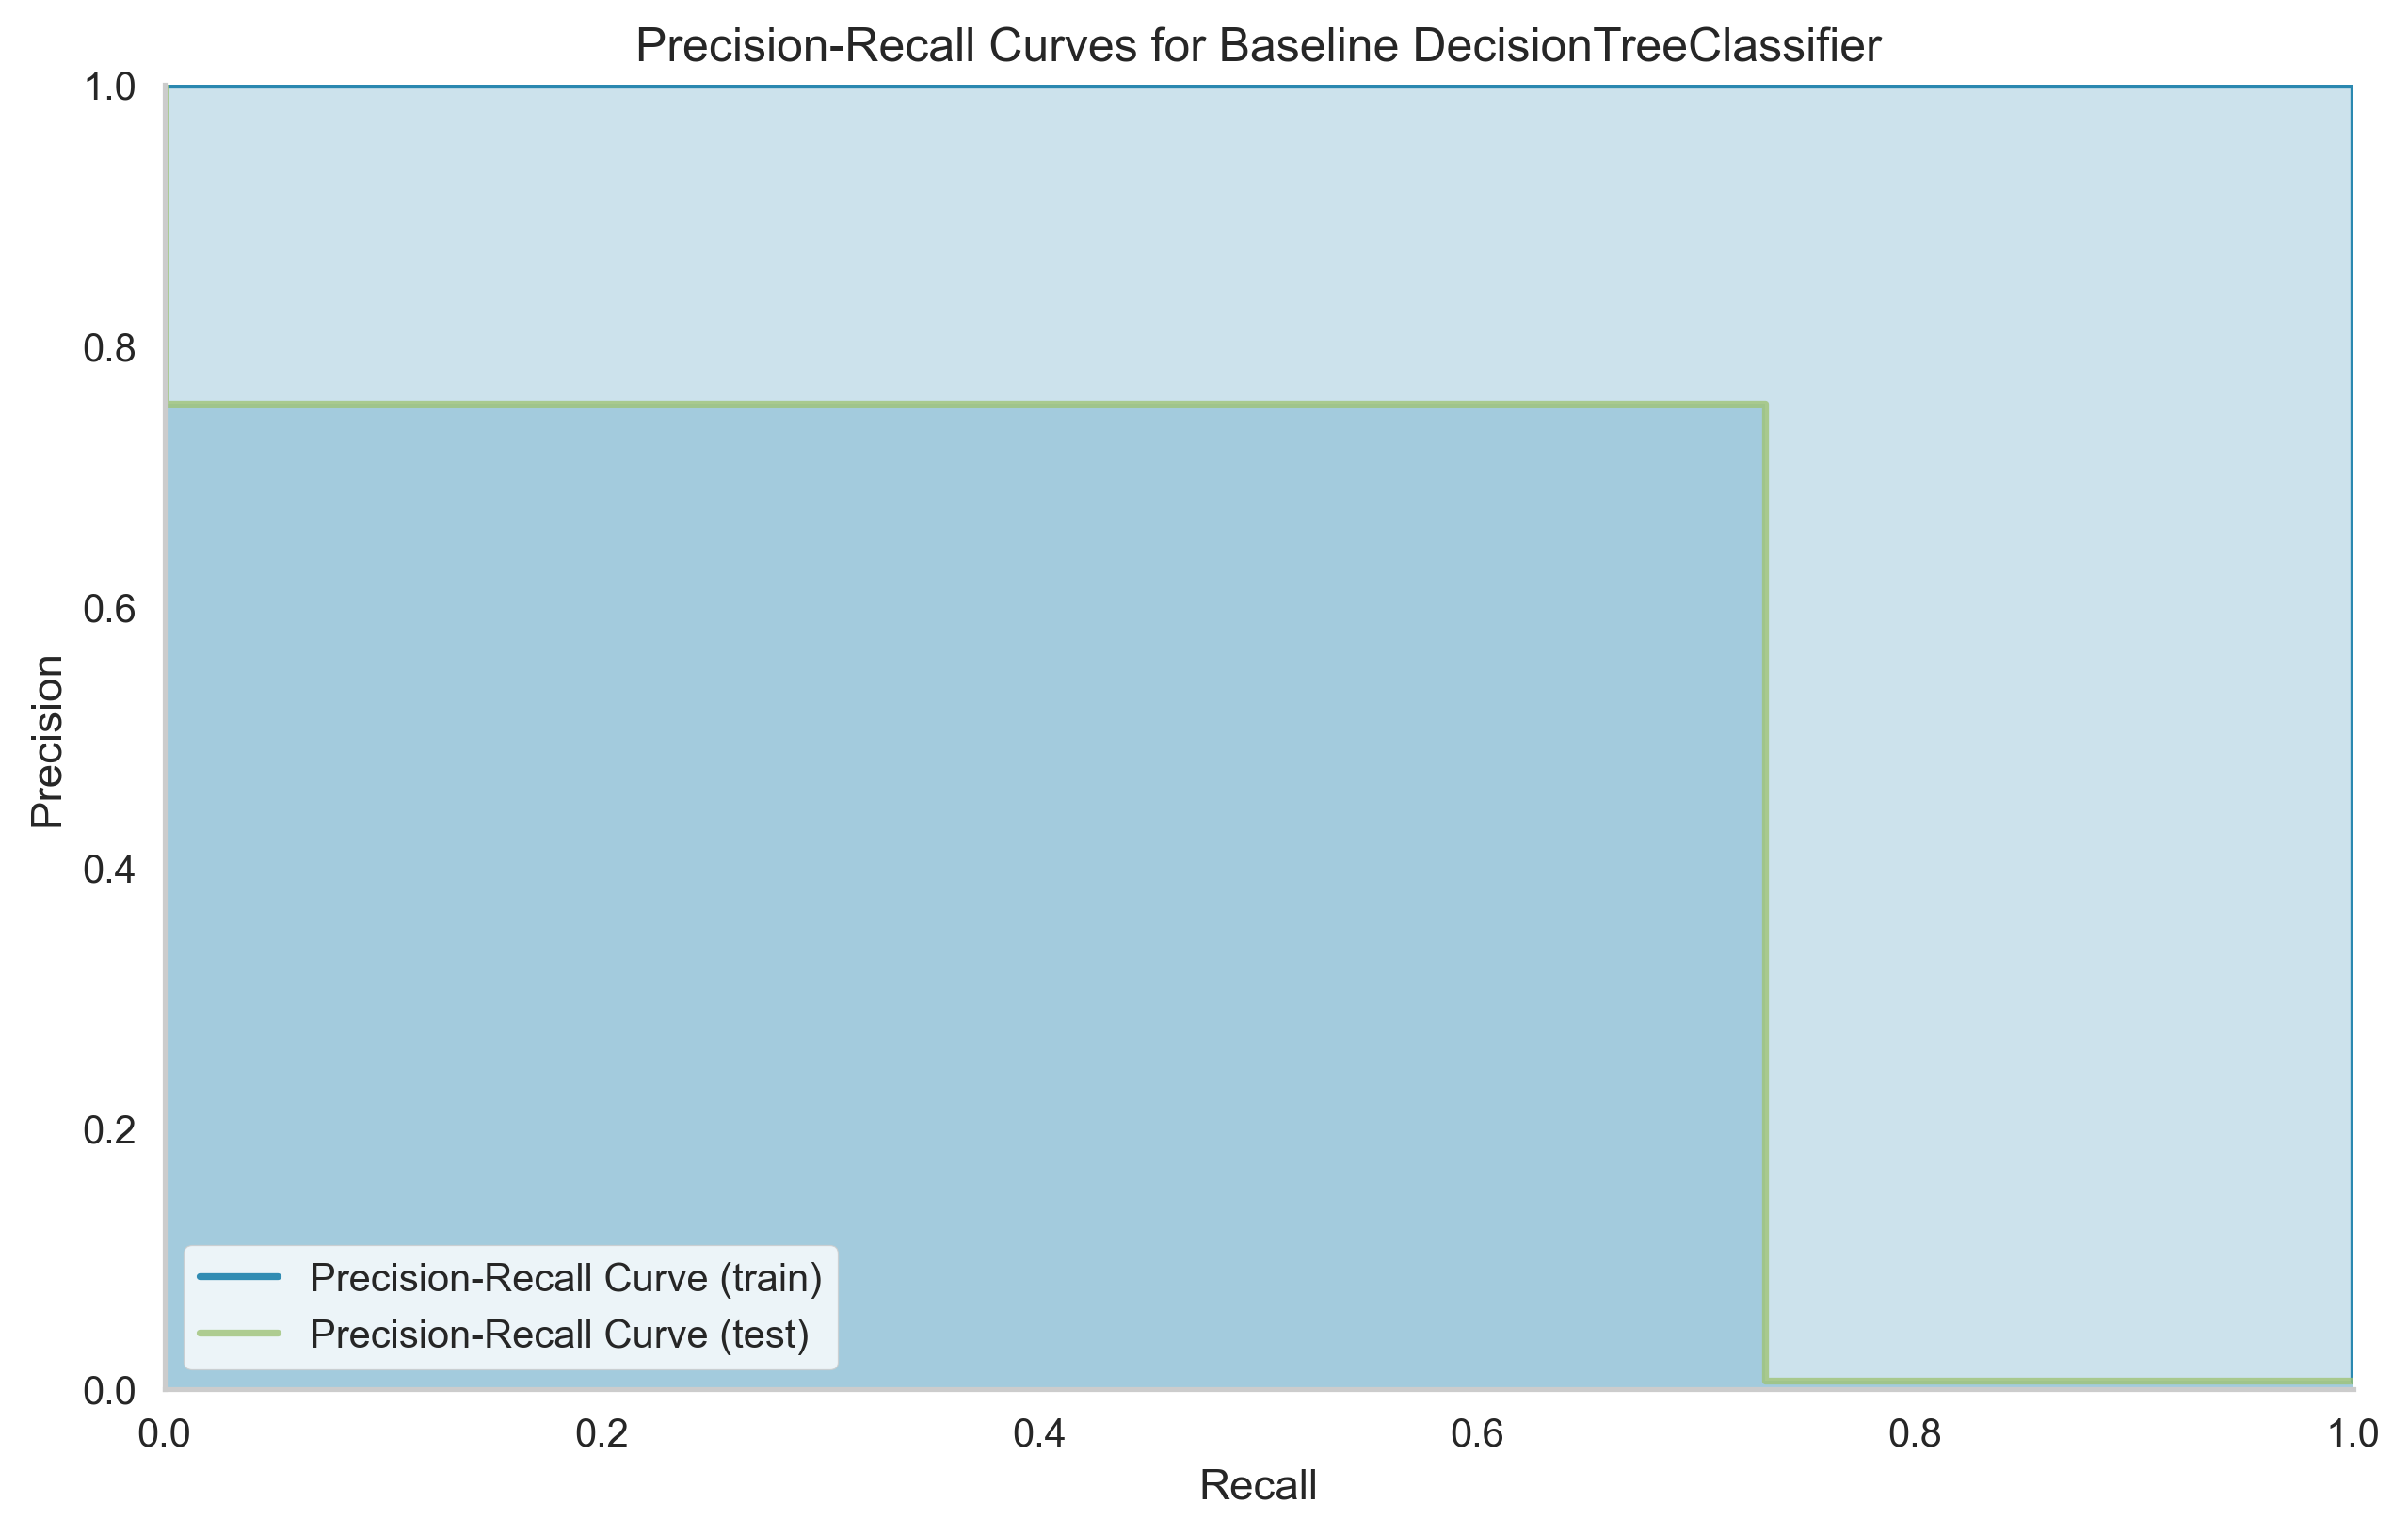

In [8]:
viz.precision_recall_curve(
    clf=dt_baseline_clf,
    X_tr=X_train,
    y_tr=y_train,
    X_t=X_test,
    y_t=y_test,
    title='Precision-Recall Curves for Baseline DecisionTreeClassifier',
    output_path=f'{CREDIT_CARDS_DT_PATH}/baseline_dt_pr_curves.png')

In [9]:
metrics.recall_at_precision_stats(
    0.9,
    dt_baseline_clf,
    X_tr=X_train,
    y_tr=y_train,
    X_t=X_test,
    y_t=y_test
)

Recall @ Precision 0.9 (train): 1.0000
Recall @ Precision 0.9 (test) : 0.0000


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


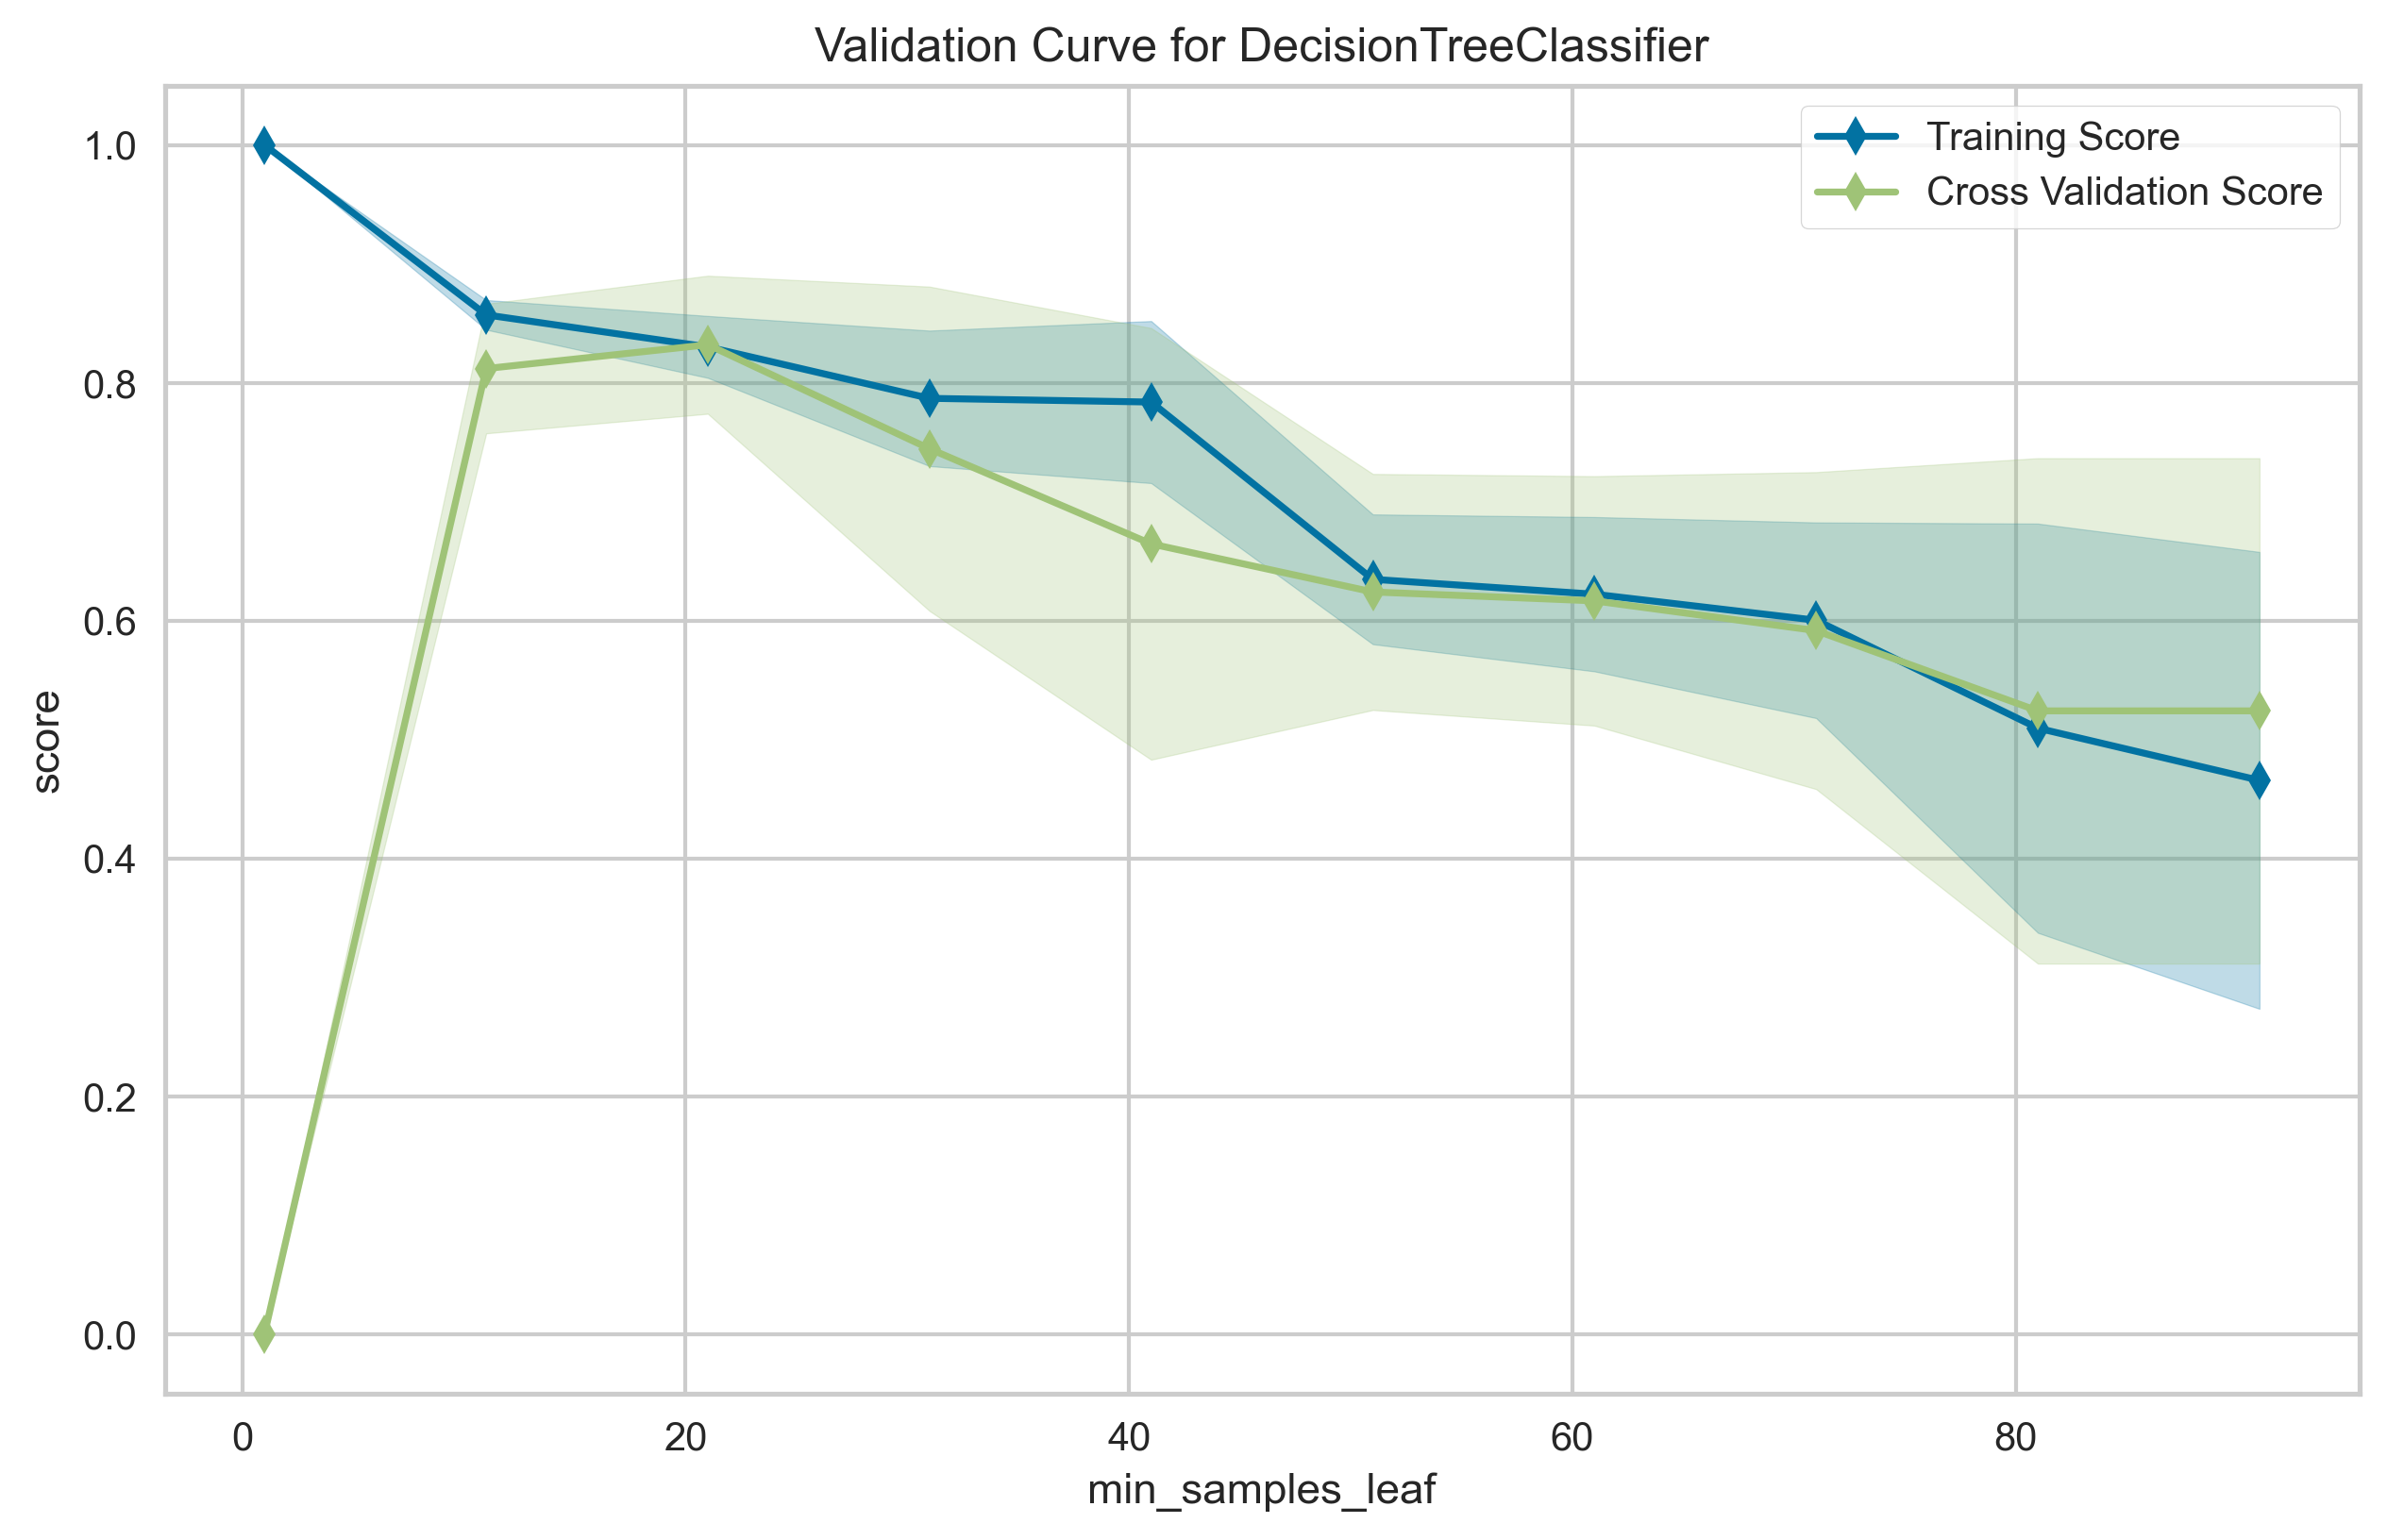

In [10]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="min_samples_leaf",
    param_range=np.arange(1, 100, 10),
    output_path=f"{CREDIT_CARDS_DT_PATH}/dt_min_samples_leaf.png"
)

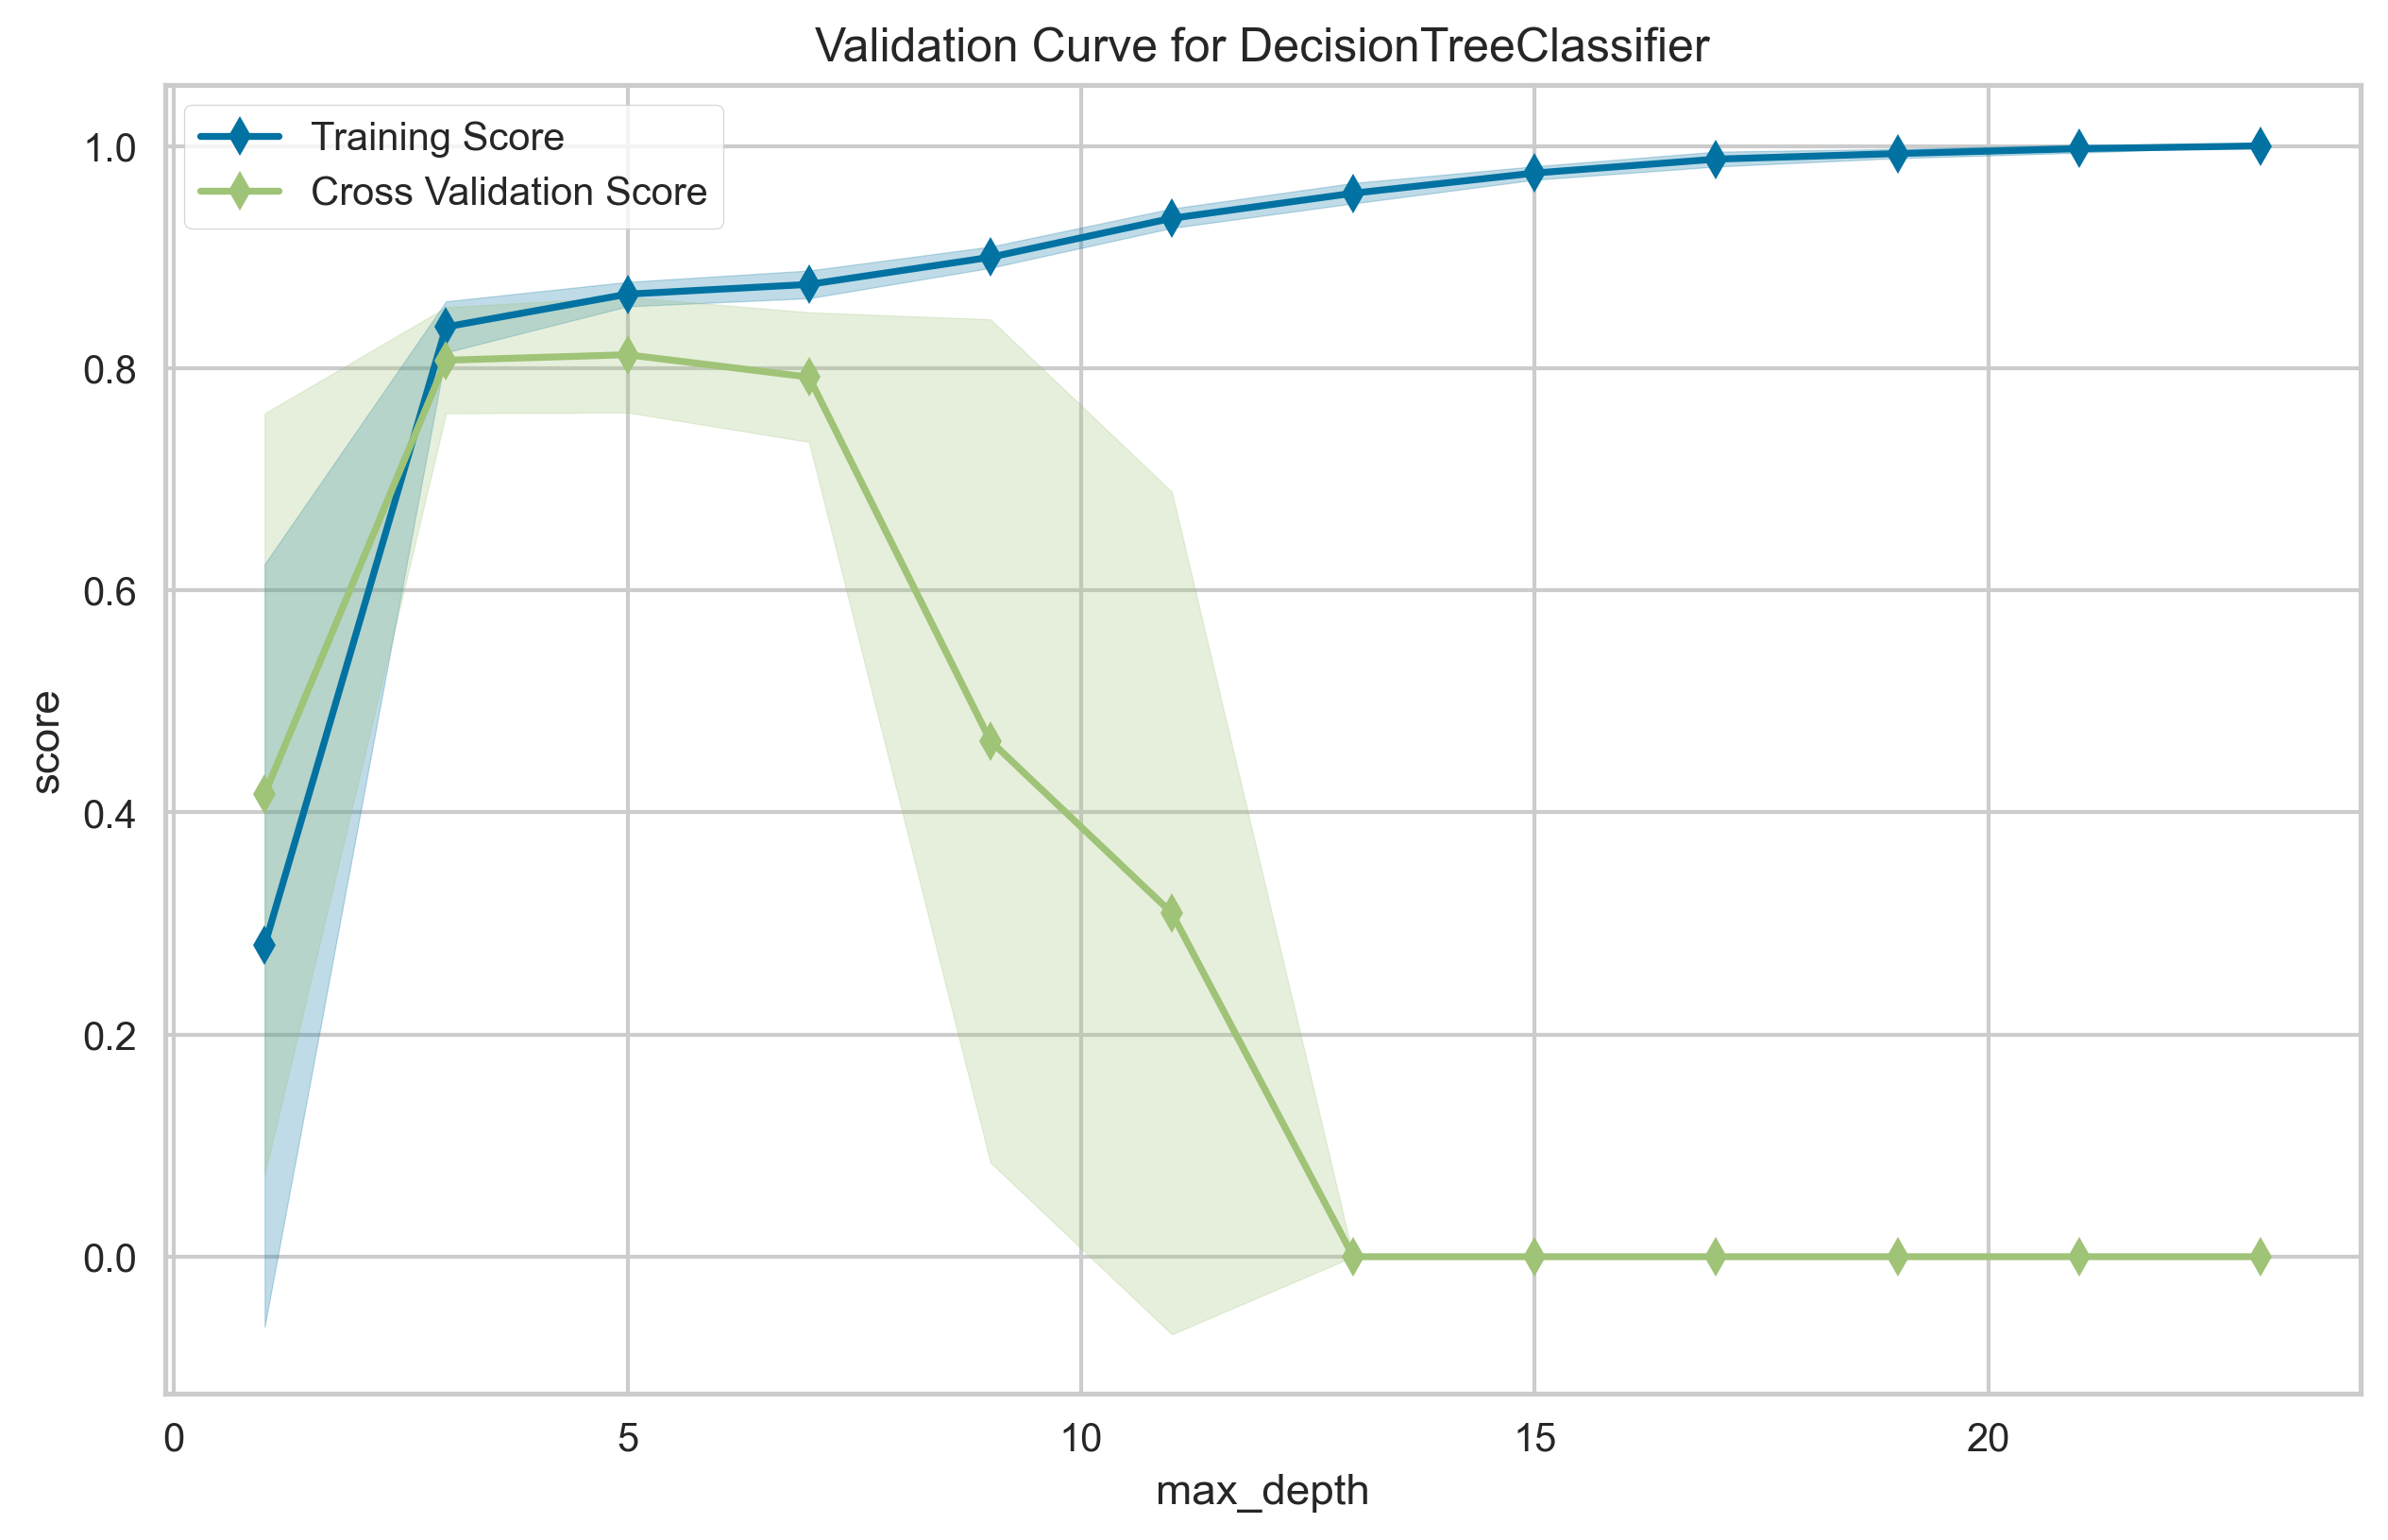

In [11]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="max_depth",
    param_range=np.arange(1, 25, 2),
    output_path=f"{CREDIT_CARDS_DT_PATH}/dt_max_depth.png"
)

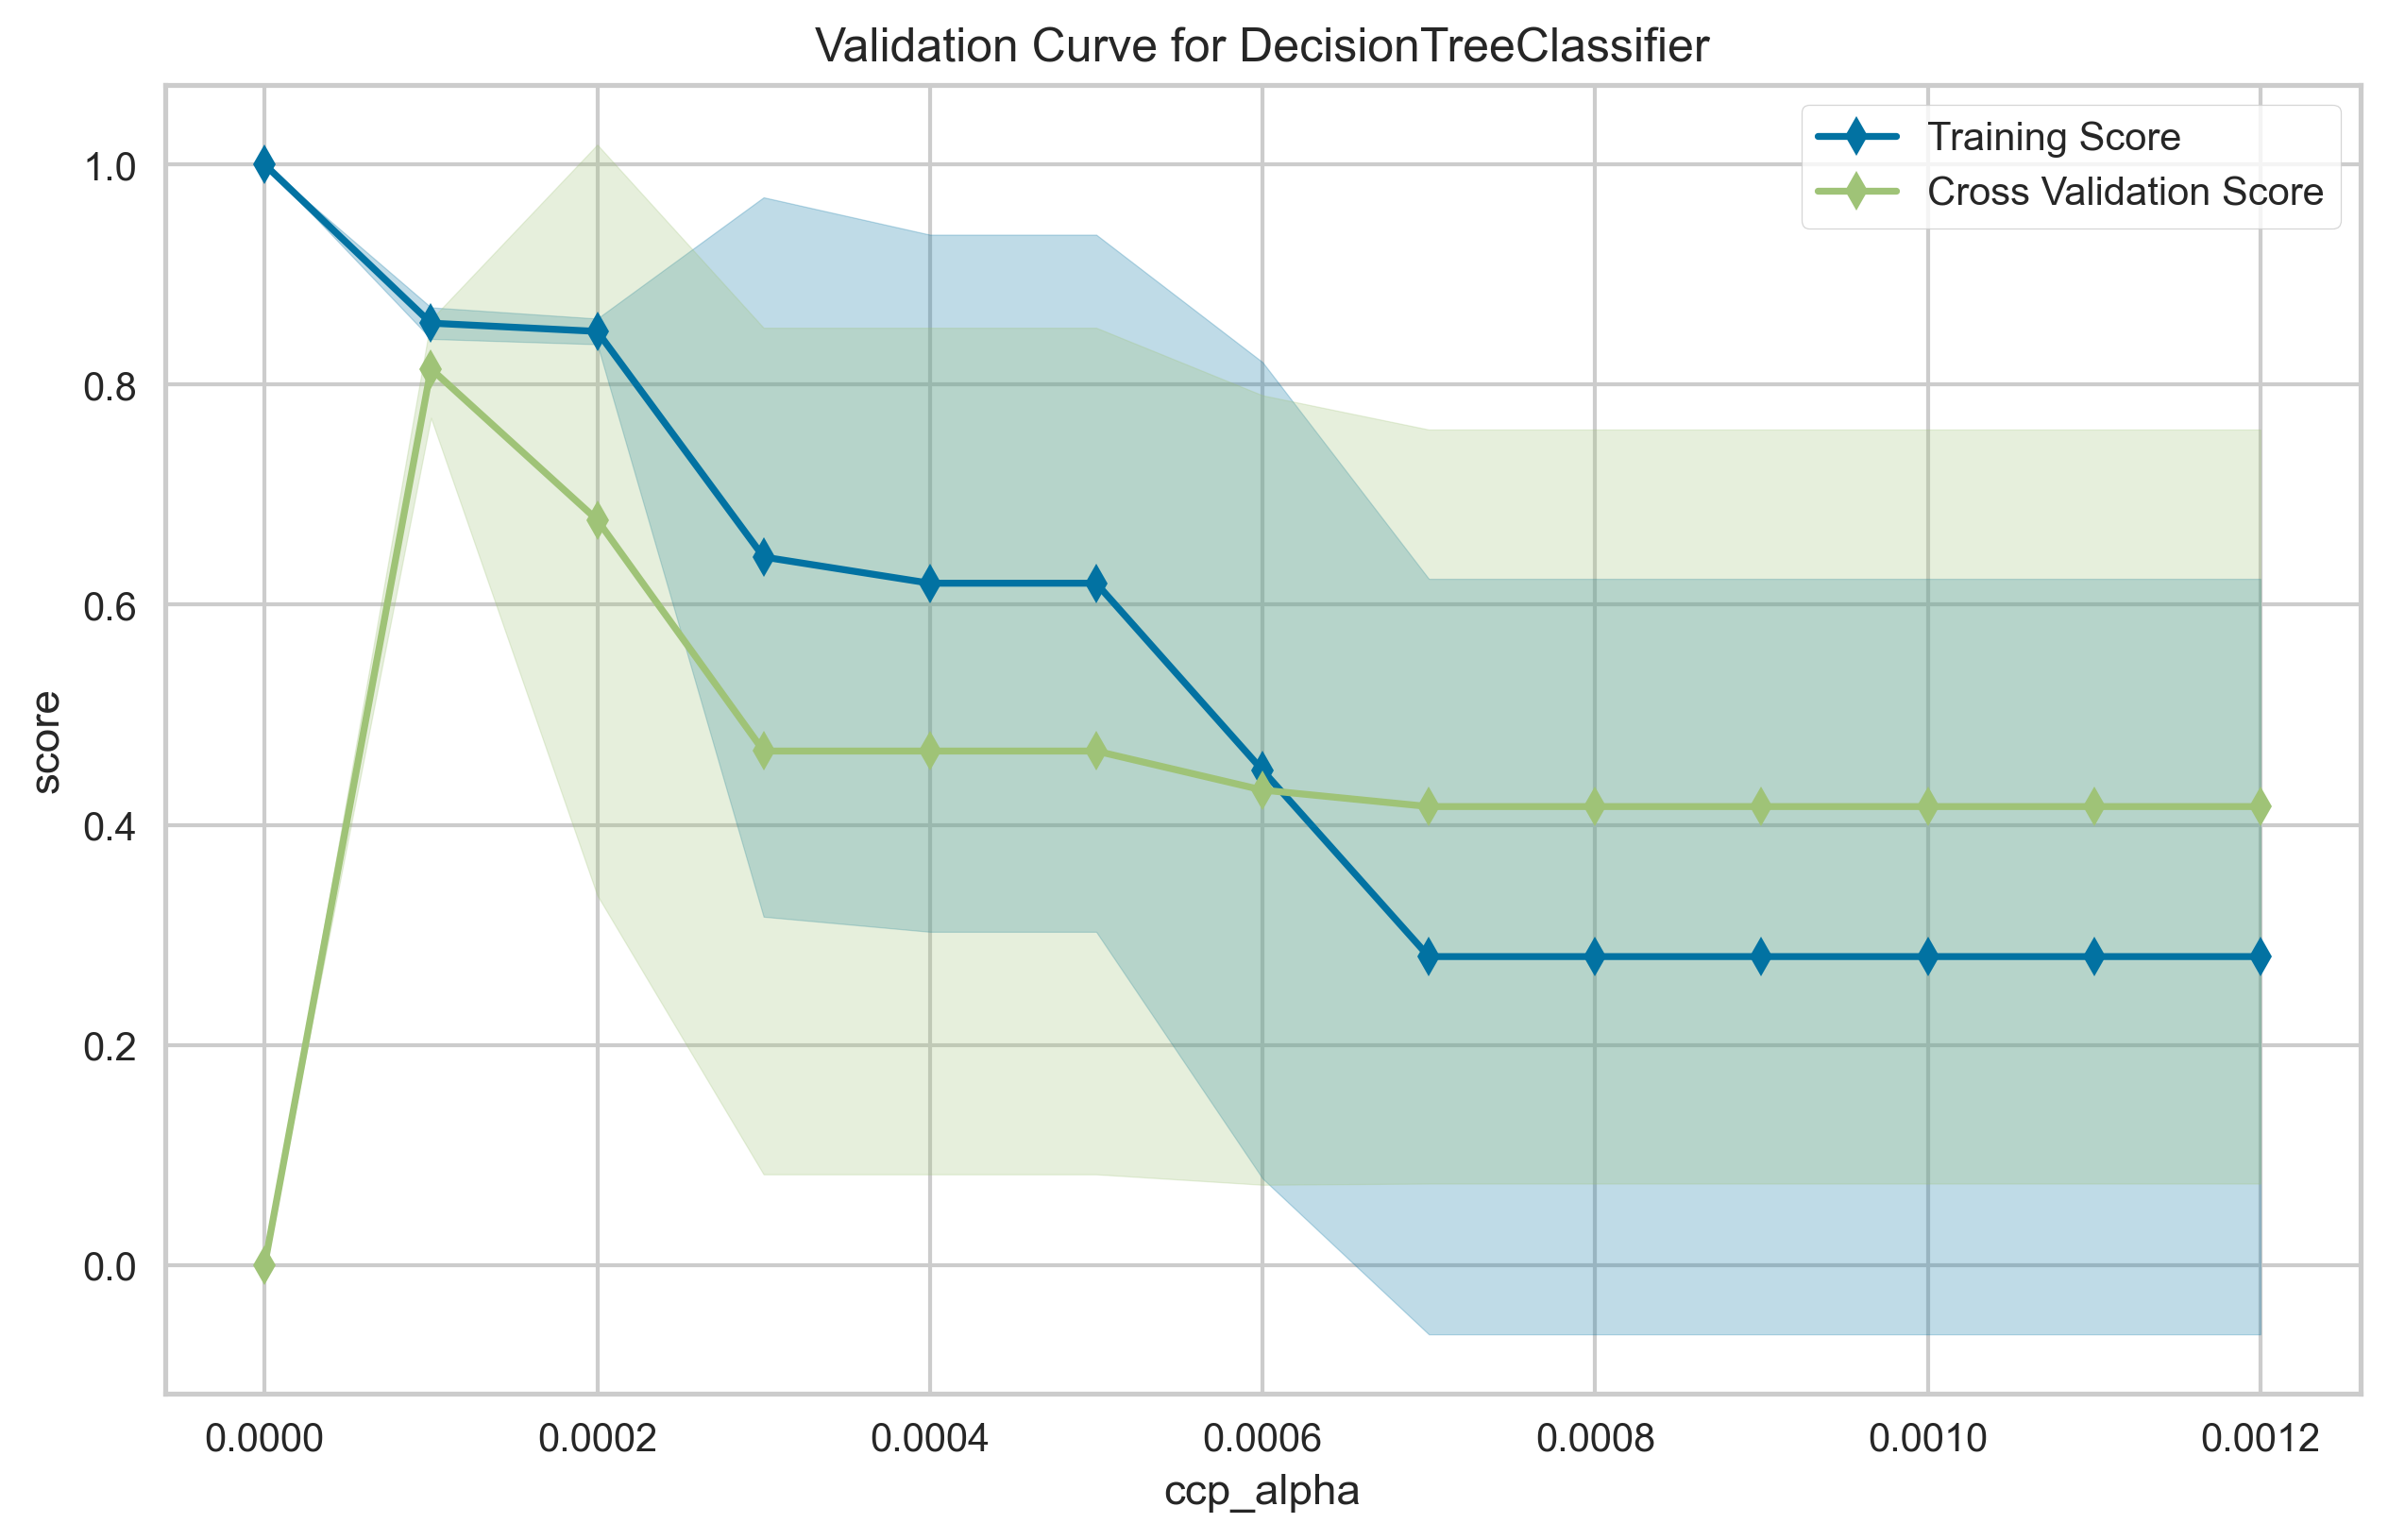

In [12]:
dt_clf = DecisionTreeClassifier(random_state=SEED)
viz.validation_curve(
    clf=dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="ccp_alpha",
    param_range=np.arange(0, 0.0013, 0.0001),
    output_path=f"{CREDIT_CARDS_DT_PATH}/dt_ccp_alpha.png")

In [13]:
best_dt_params = training.perform_hyperparameter_tuning(
    clf=DecisionTreeClassifier(random_state=SEED),
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_space={
        "ccp_alpha": np.arange(0, 0.0001, 0.0002),
        "max_depth": np.arange(2, 22, 5),
        "min_samples_leaf": np.arange(1, 101, 10),
    }
)

In [14]:
best_dt_params

{'ccp_alpha': 0.0, 'max_depth': 7, 'min_samples_leaf': 21}

In [15]:
def instantiate_best_dt_clf():
    return DecisionTreeClassifier(max_depth=best_dt_params['max_depth'],
                                  min_samples_leaf=best_dt_params['min_samples_leaf'],
                                  ccp_alpha=best_dt_params['ccp_alpha'],
                                  random_state=SEED)

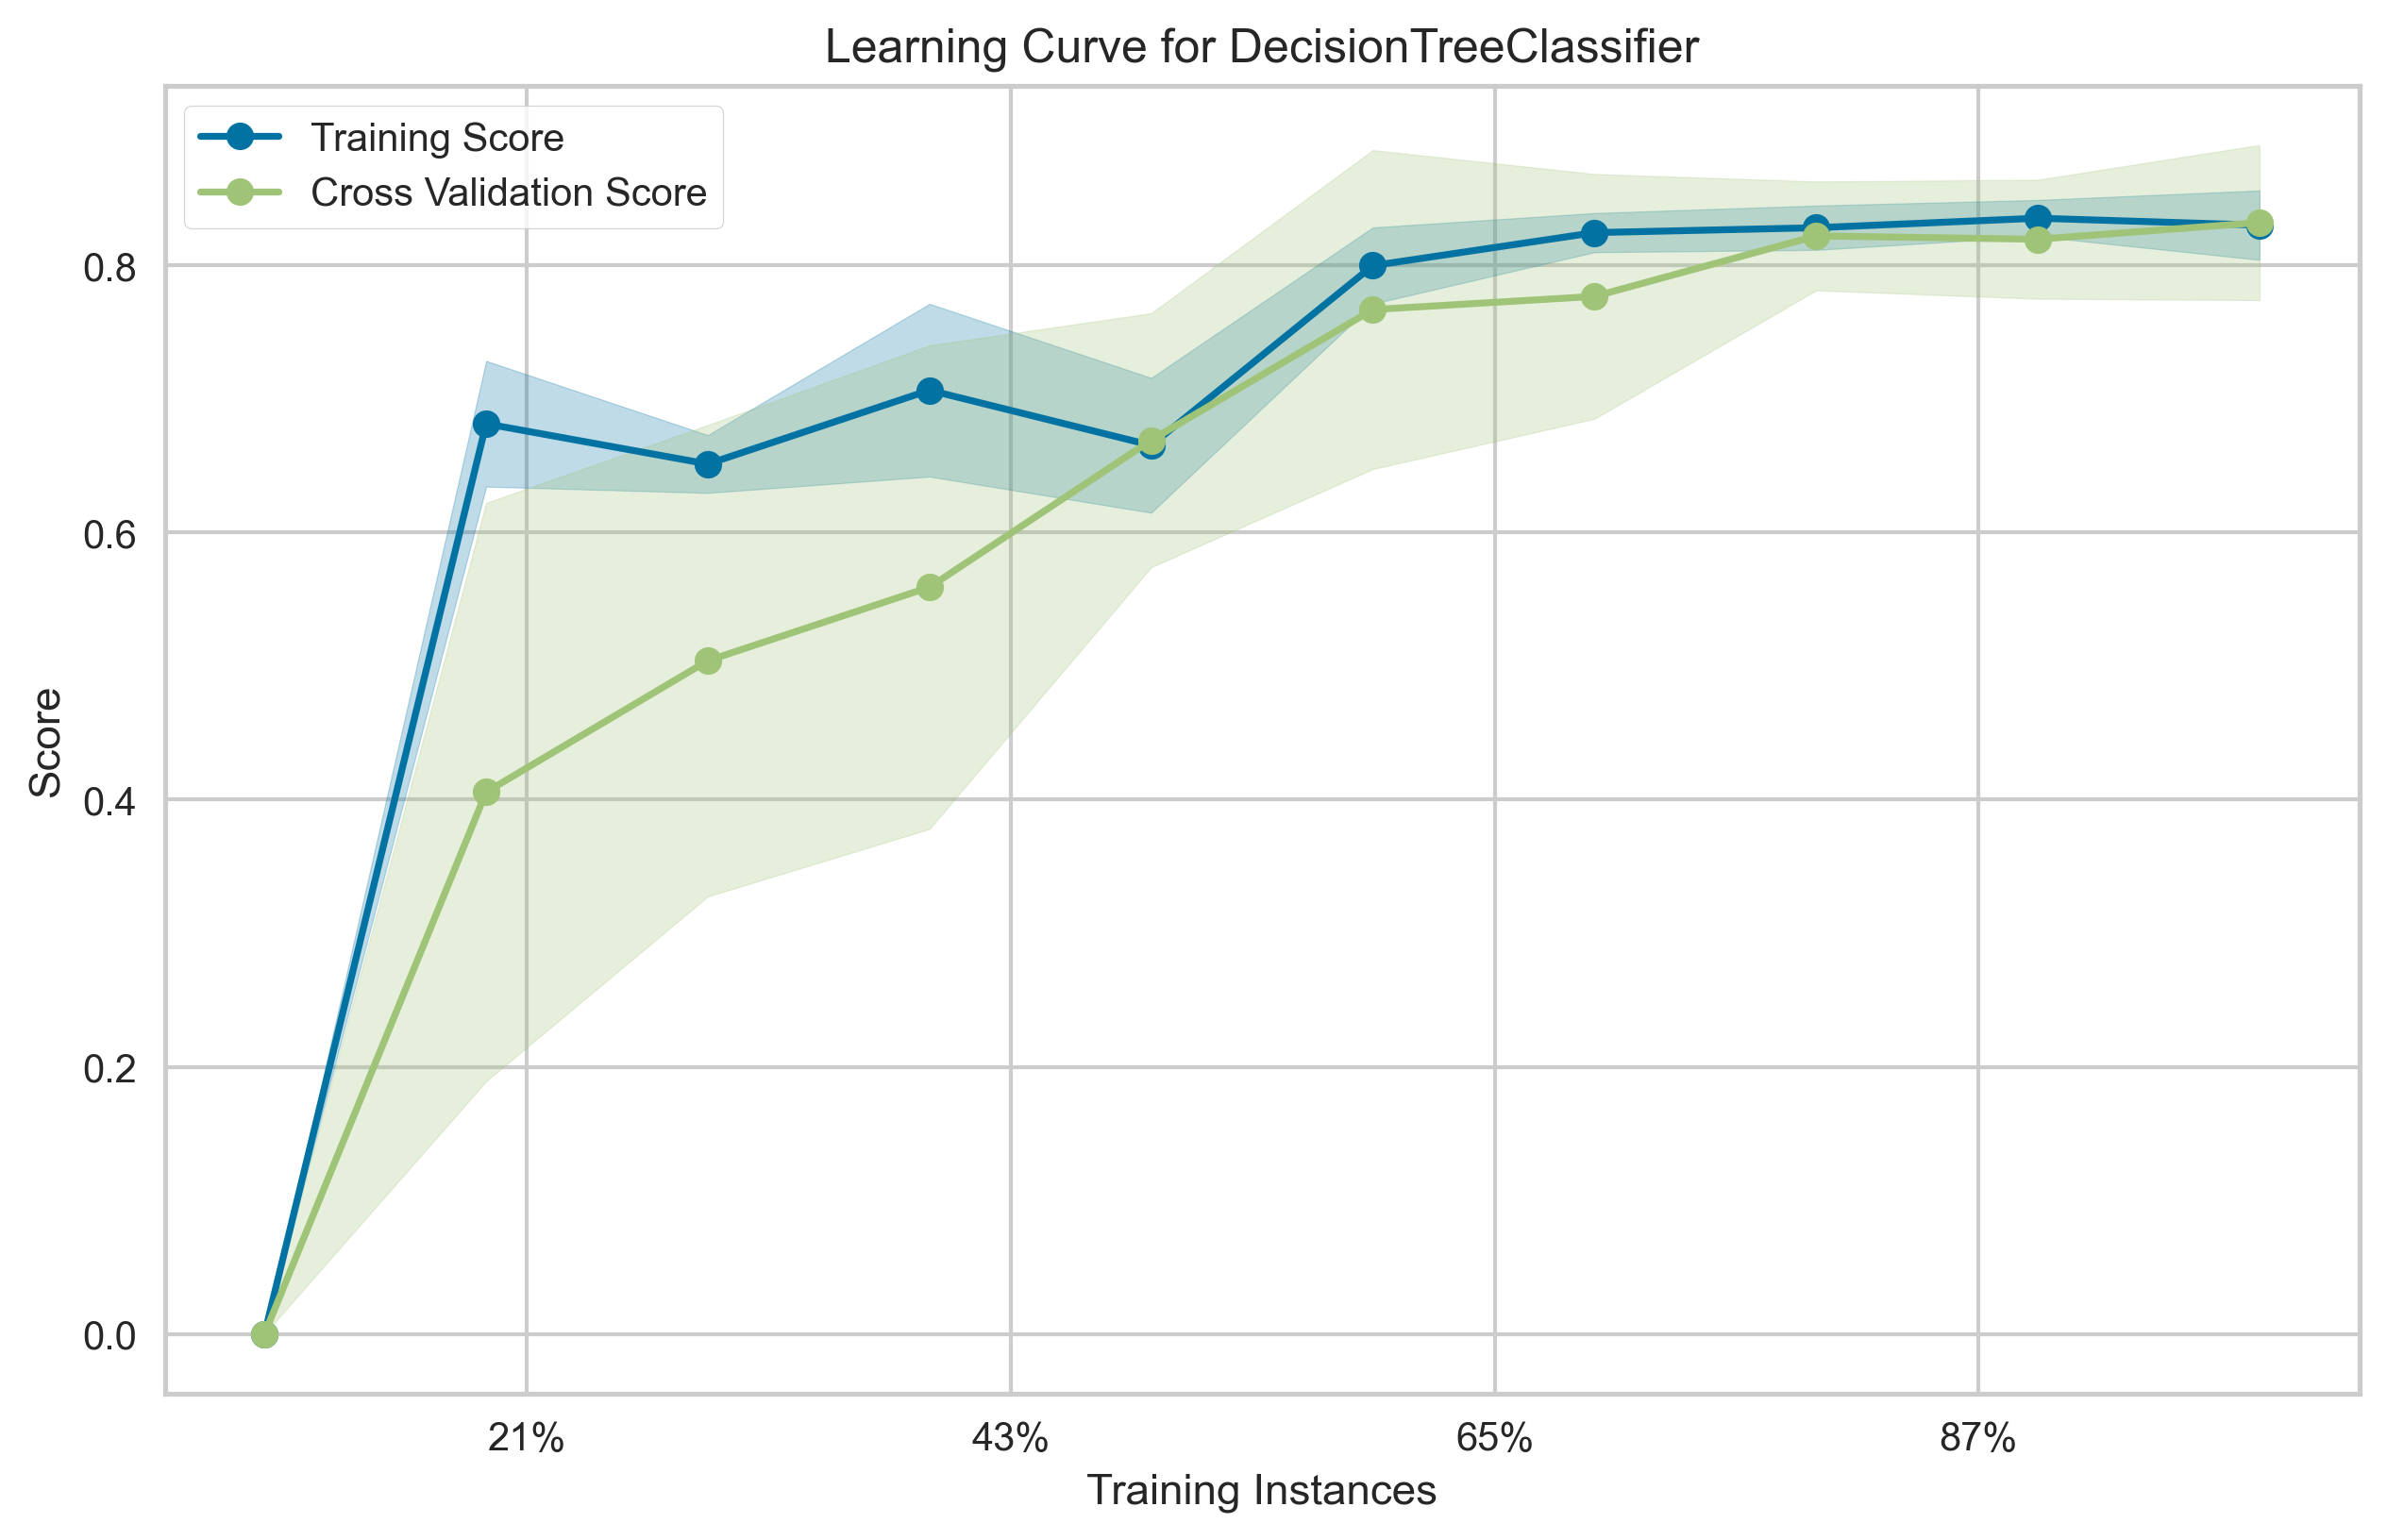

In [16]:
best_dt_clf = instantiate_best_dt_clf()
viz.learning_curve(clf=best_dt_clf,
                   X_tr=X_train,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{CREDIT_CARDS_DT_PATH}/dt_learning_curve.png")

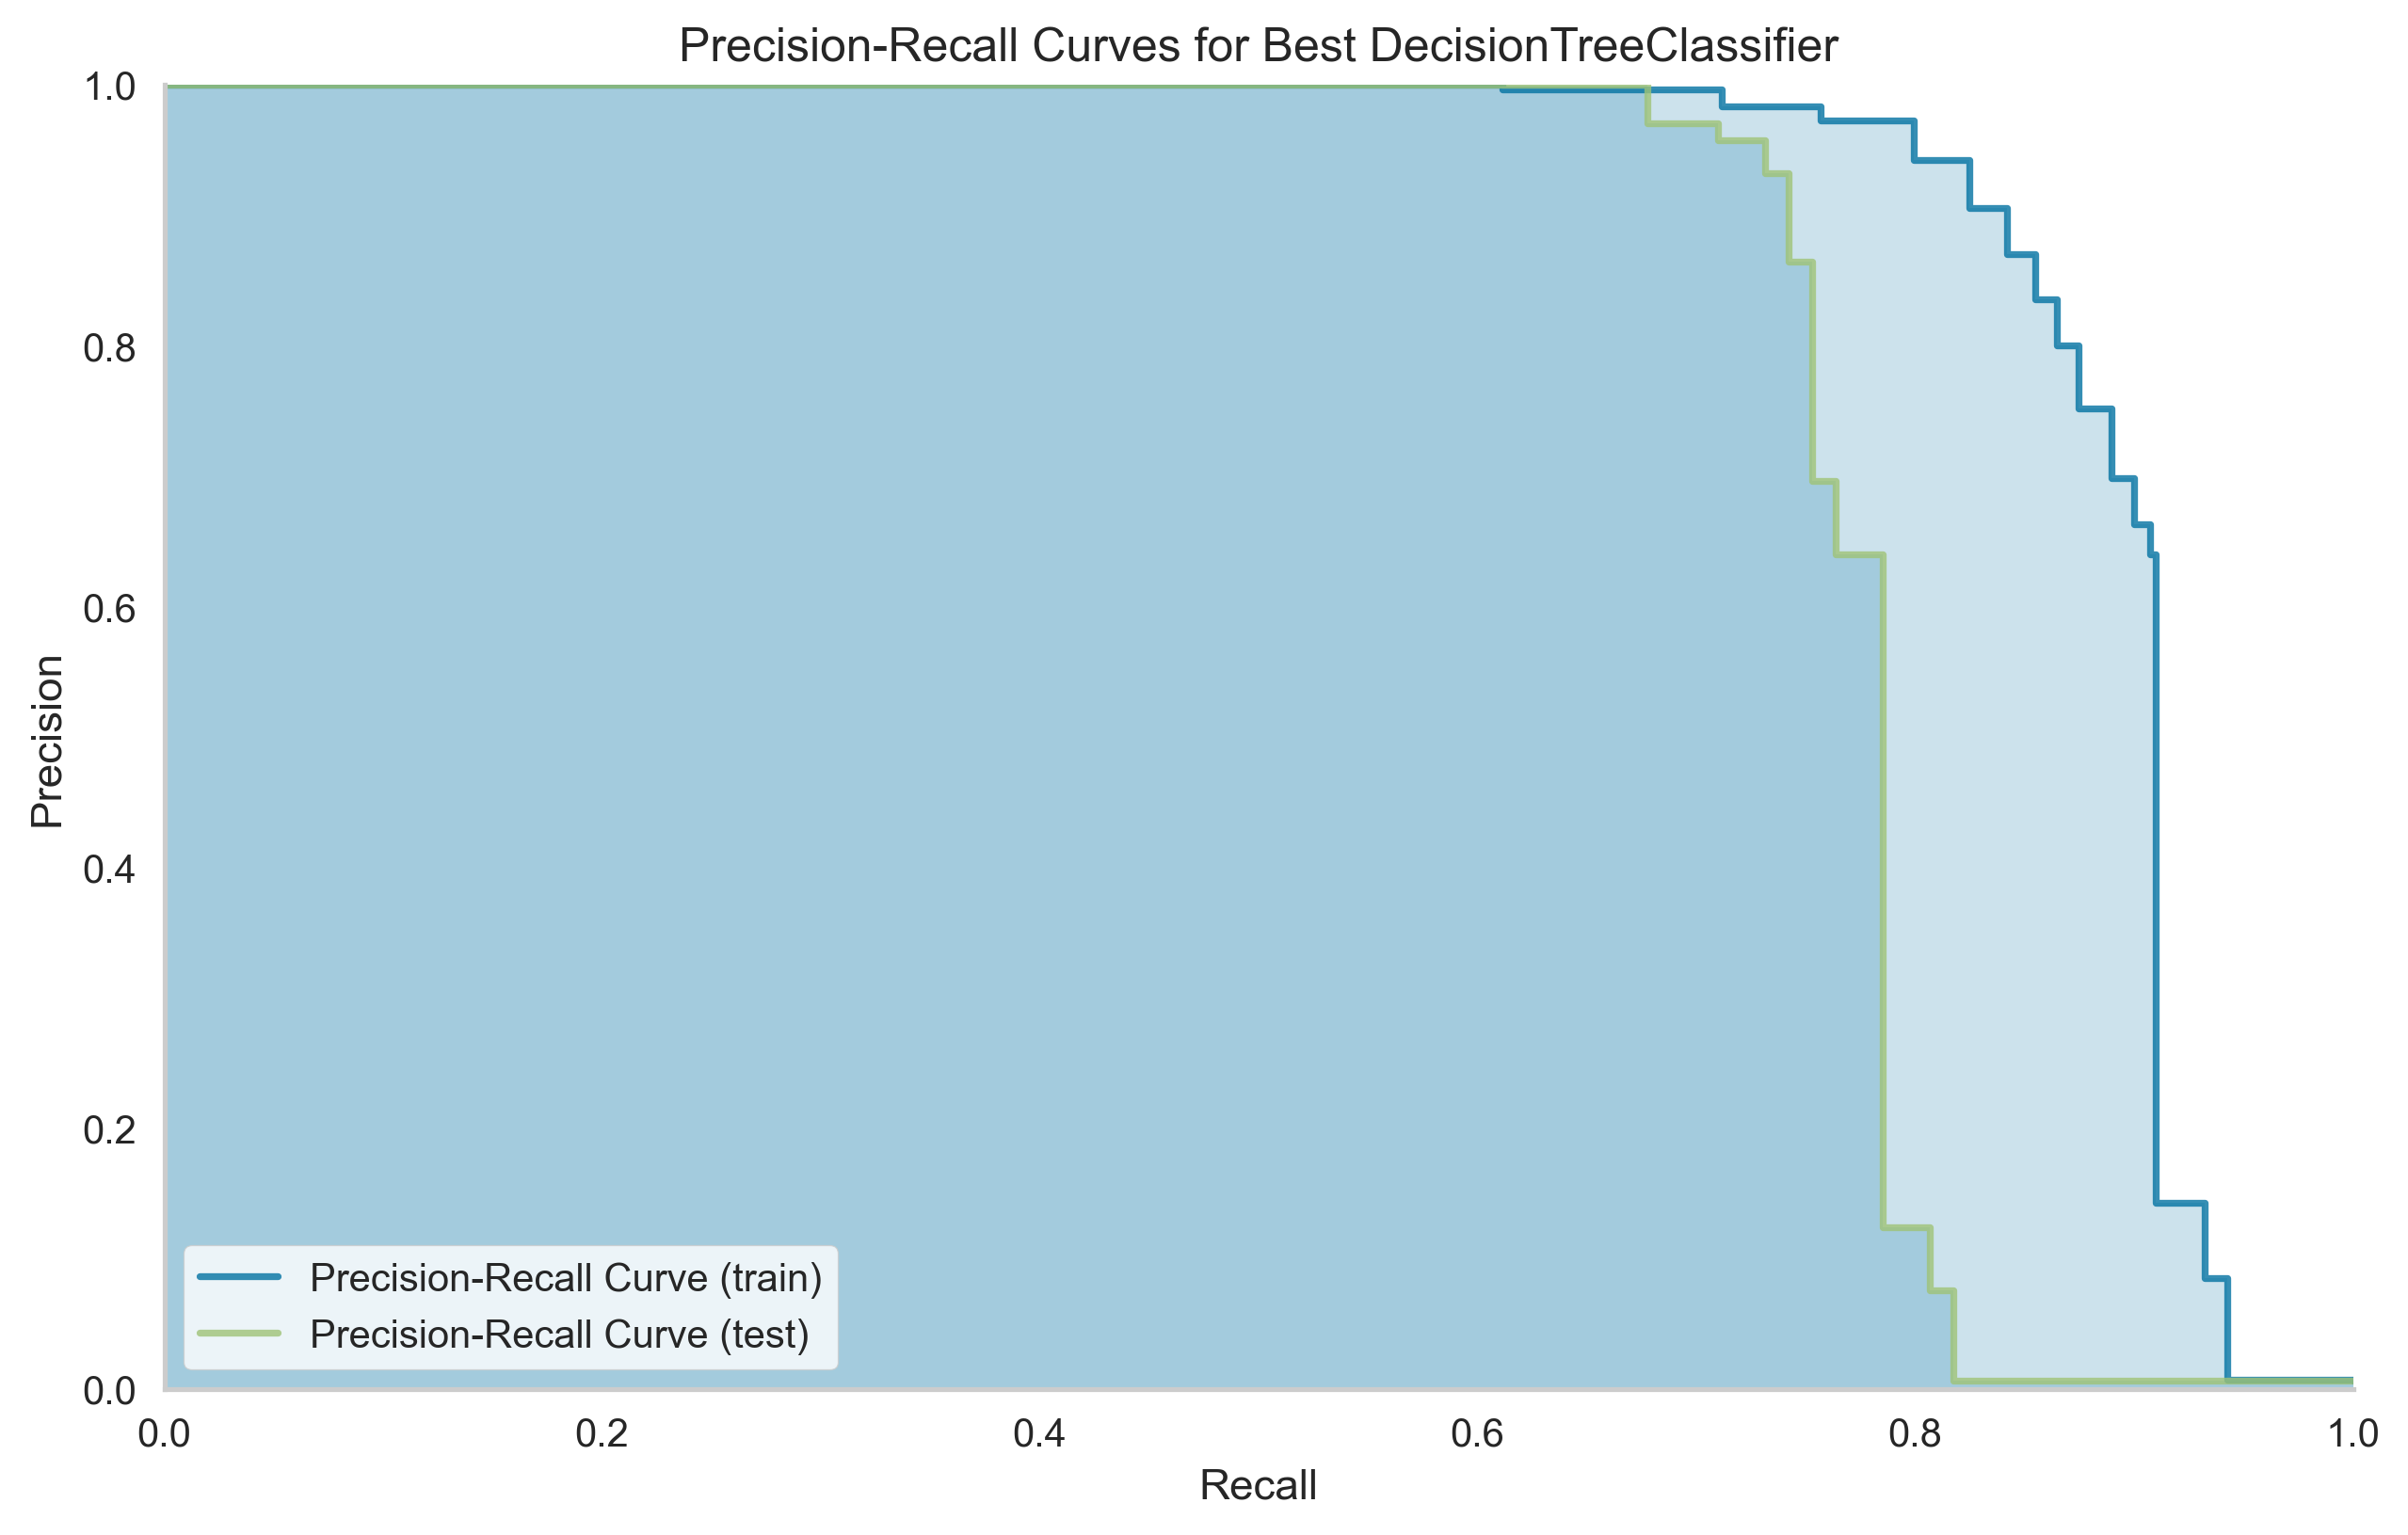

In [17]:
best_dt_clf = instantiate_best_dt_clf()
best_dt_clf.fit(X_train, y_train)
viz.precision_recall_curve(
    clf=best_dt_clf,
    X_tr=X_train,
    y_tr=y_train,
    X_t=X_test,
    y_t=y_test,
    title='Precision-Recall Curves for Best DecisionTreeClassifier',
    output_path=f'{CREDIT_CARDS_DT_PATH}/best_dt_pr_curves.png')

In [18]:
metrics.recall_at_precision_stats(0.9,
                                  best_dt_clf,
                                  X_tr=X_train,
                                  y_tr=y_train,
                                  X_t=X_test,
                                  y_t=y_test
                                  )

Recall @ Precision 0.9 (train): 0.8421
Recall @ Precision 0.9 (test) : 0.7419


In [19]:
best_dt_clf = instantiate_best_dt_clf()
training.learning_time_stats(best_dt_clf,
                             X_tr=X_train,
                             y_tr=y_train,
                             )

Training time, total: 1.3173 seconds
Training time, normalized (per 1000 samples): 0.0230 seconds


In [20]:
training.inference_time_stats(best_dt_clf, X_train, dataset_name='train')
training.inference_time_stats(best_dt_clf, X_test, dataset_name='test')
training.inference_time_stats(best_dt_clf, X, dataset_name='all')

Inference time (train), total: 0.0036 seconds
Inference time (train), normalized (per 1000 samples): 0.0001 seconds
Inference time (test), total: 0.0017 seconds
Inference time (test), normalized (per 1000 samples): 0.0001 seconds
Inference time (all), total: 0.0040 seconds
Inference time (all), normalized (per 1000 samples): 0.0001 seconds


# Boosting

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `n_estimators`
    b. `learning_rate`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [21]:
CREDIT_CARDS_BOOST_PATH = f'{CREDIT_CARDS_PATH}/boosting'


In [22]:
boost_baseline_clf = AdaBoostClassifier(random_state=SEED)
boost_baseline_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

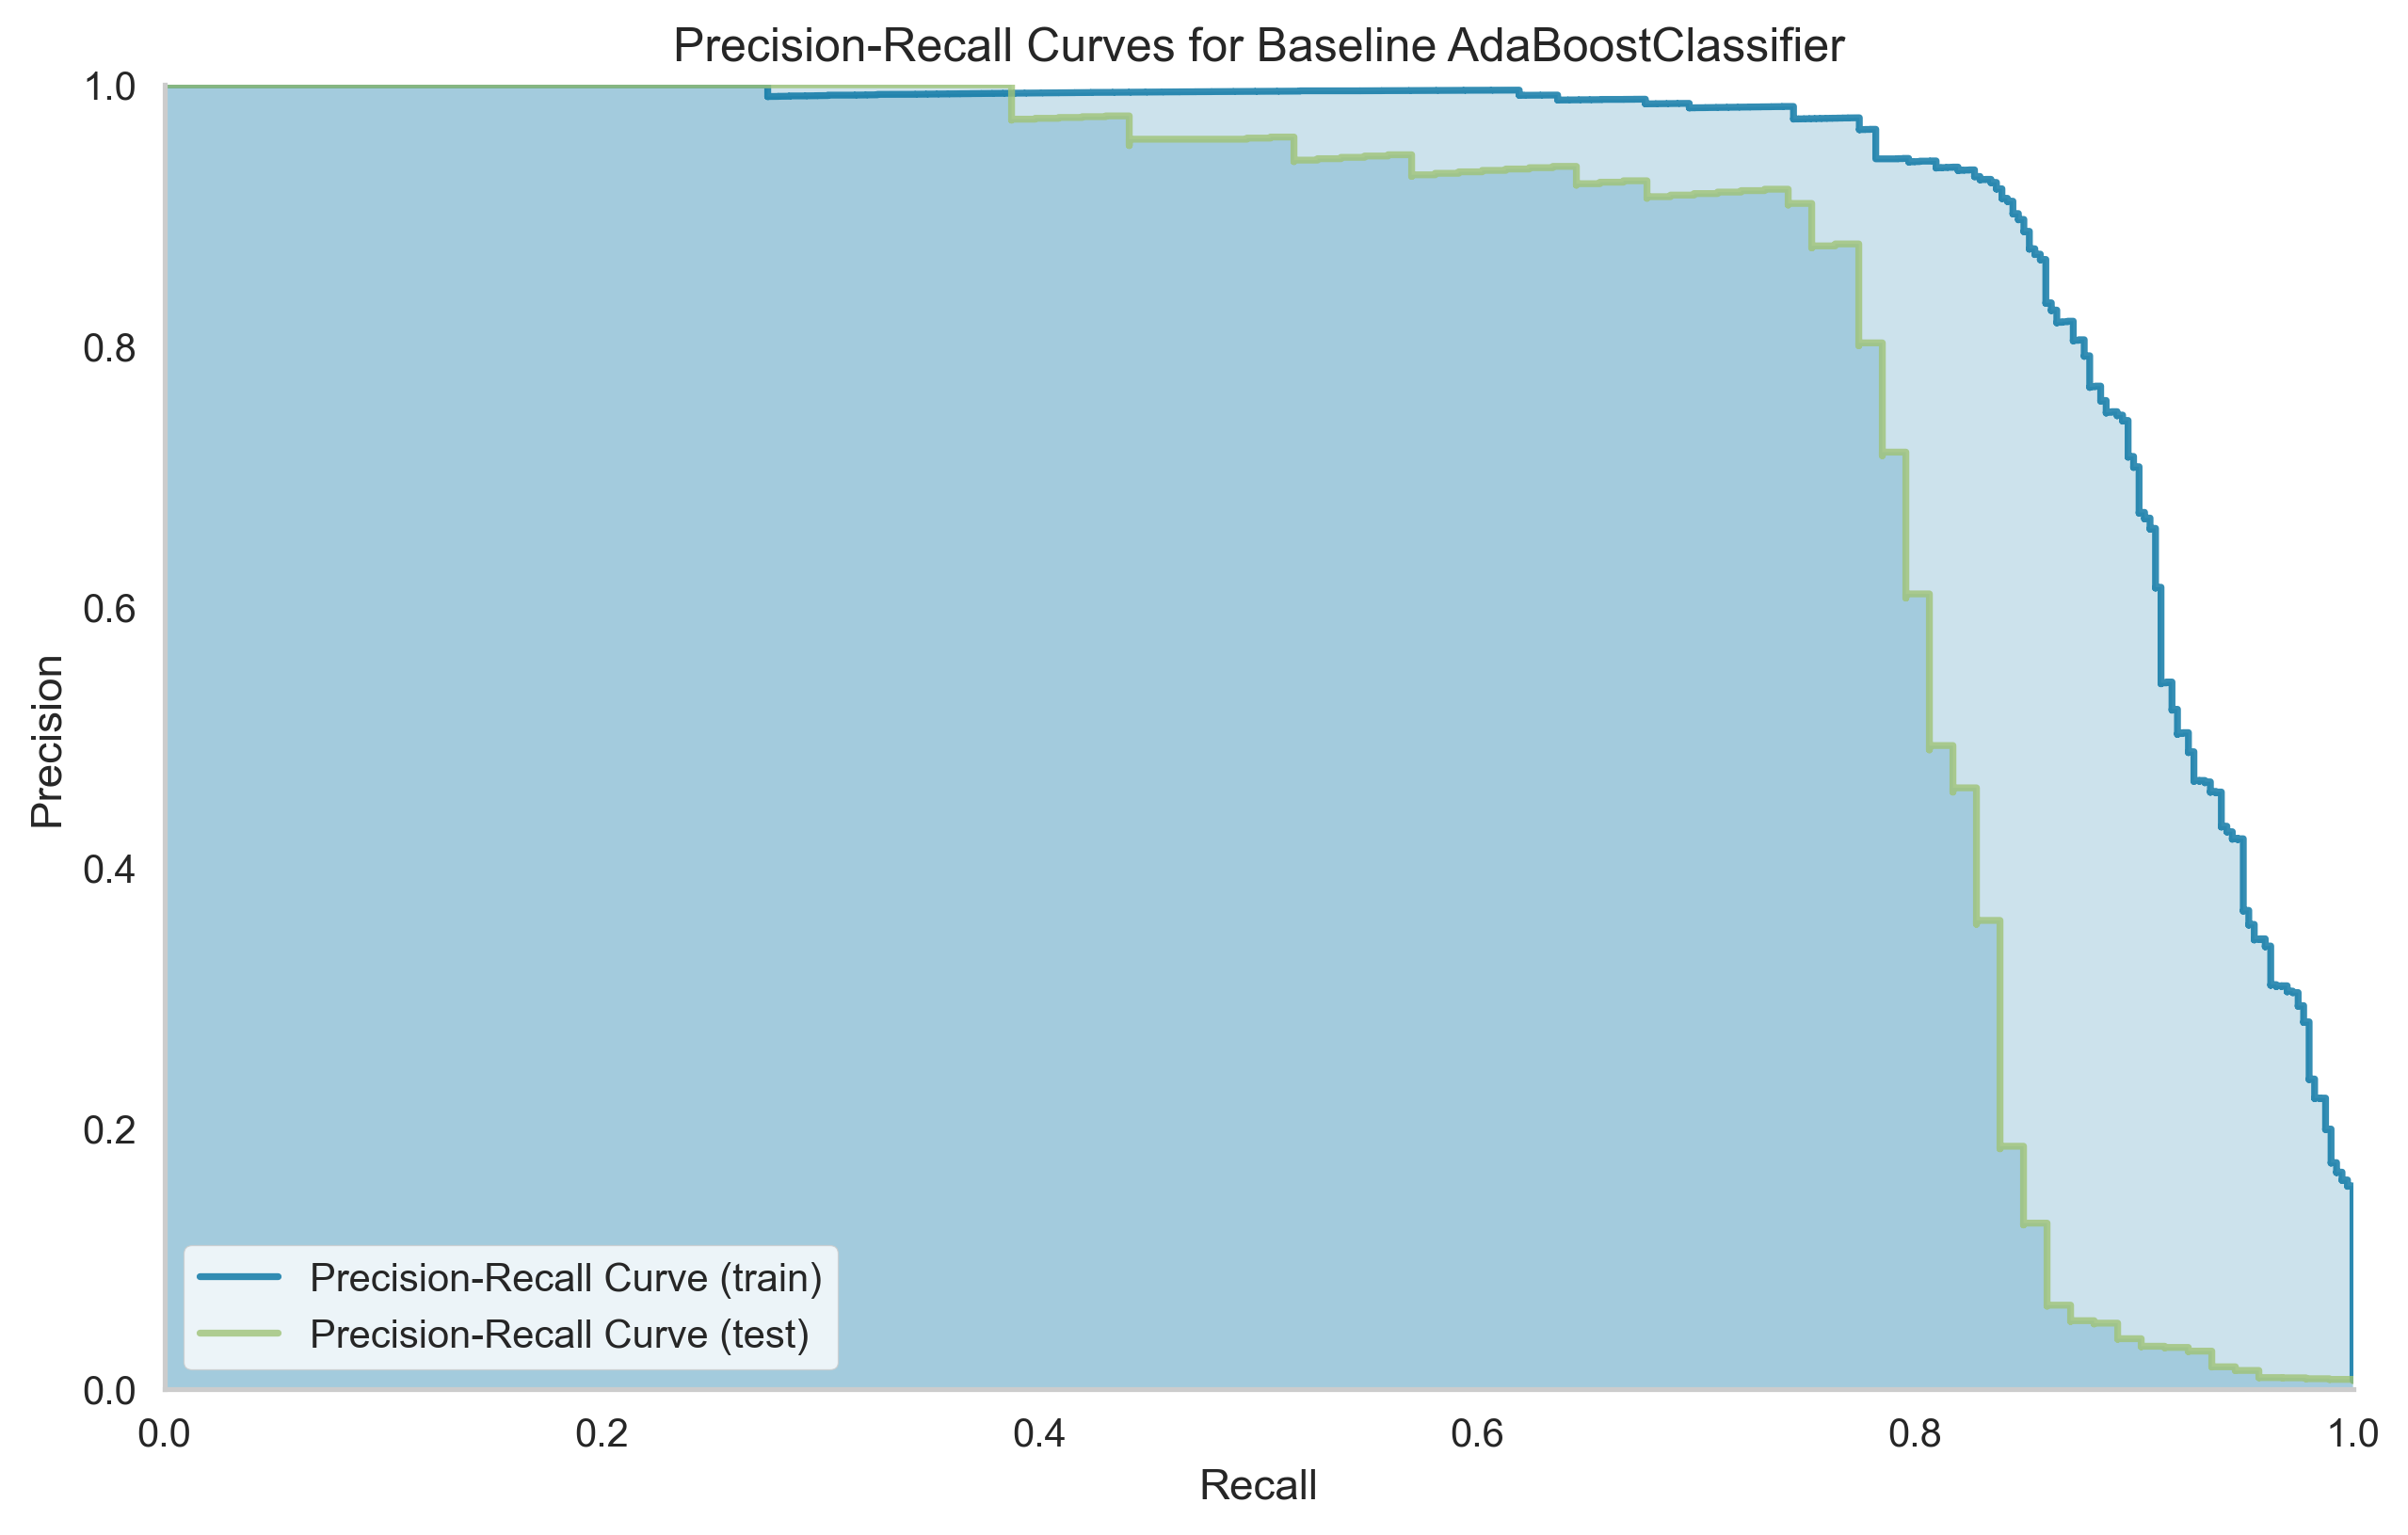

In [23]:
viz.precision_recall_curve(
    clf=boost_baseline_clf,
    X_tr=X_train,
    y_tr=y_train,
    X_t=X_test,
    y_t=y_test,
    title='Precision-Recall Curves for Baseline AdaBoostClassifier',
    output_path=f'{CREDIT_CARDS_BOOST_PATH}/baseline_boost_pr_curves.png')

In [24]:
metrics.recall_at_precision_stats(0.9,
                                  boost_baseline_clf,
                                  X_tr=X_train,
                                  y_tr=y_train,
                                  X_t=X_test,
                                  y_t=y_test)


Recall @ Precision 0.9 (train): 0.8471
Recall @ Precision 0.9 (test) : 0.7527


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params

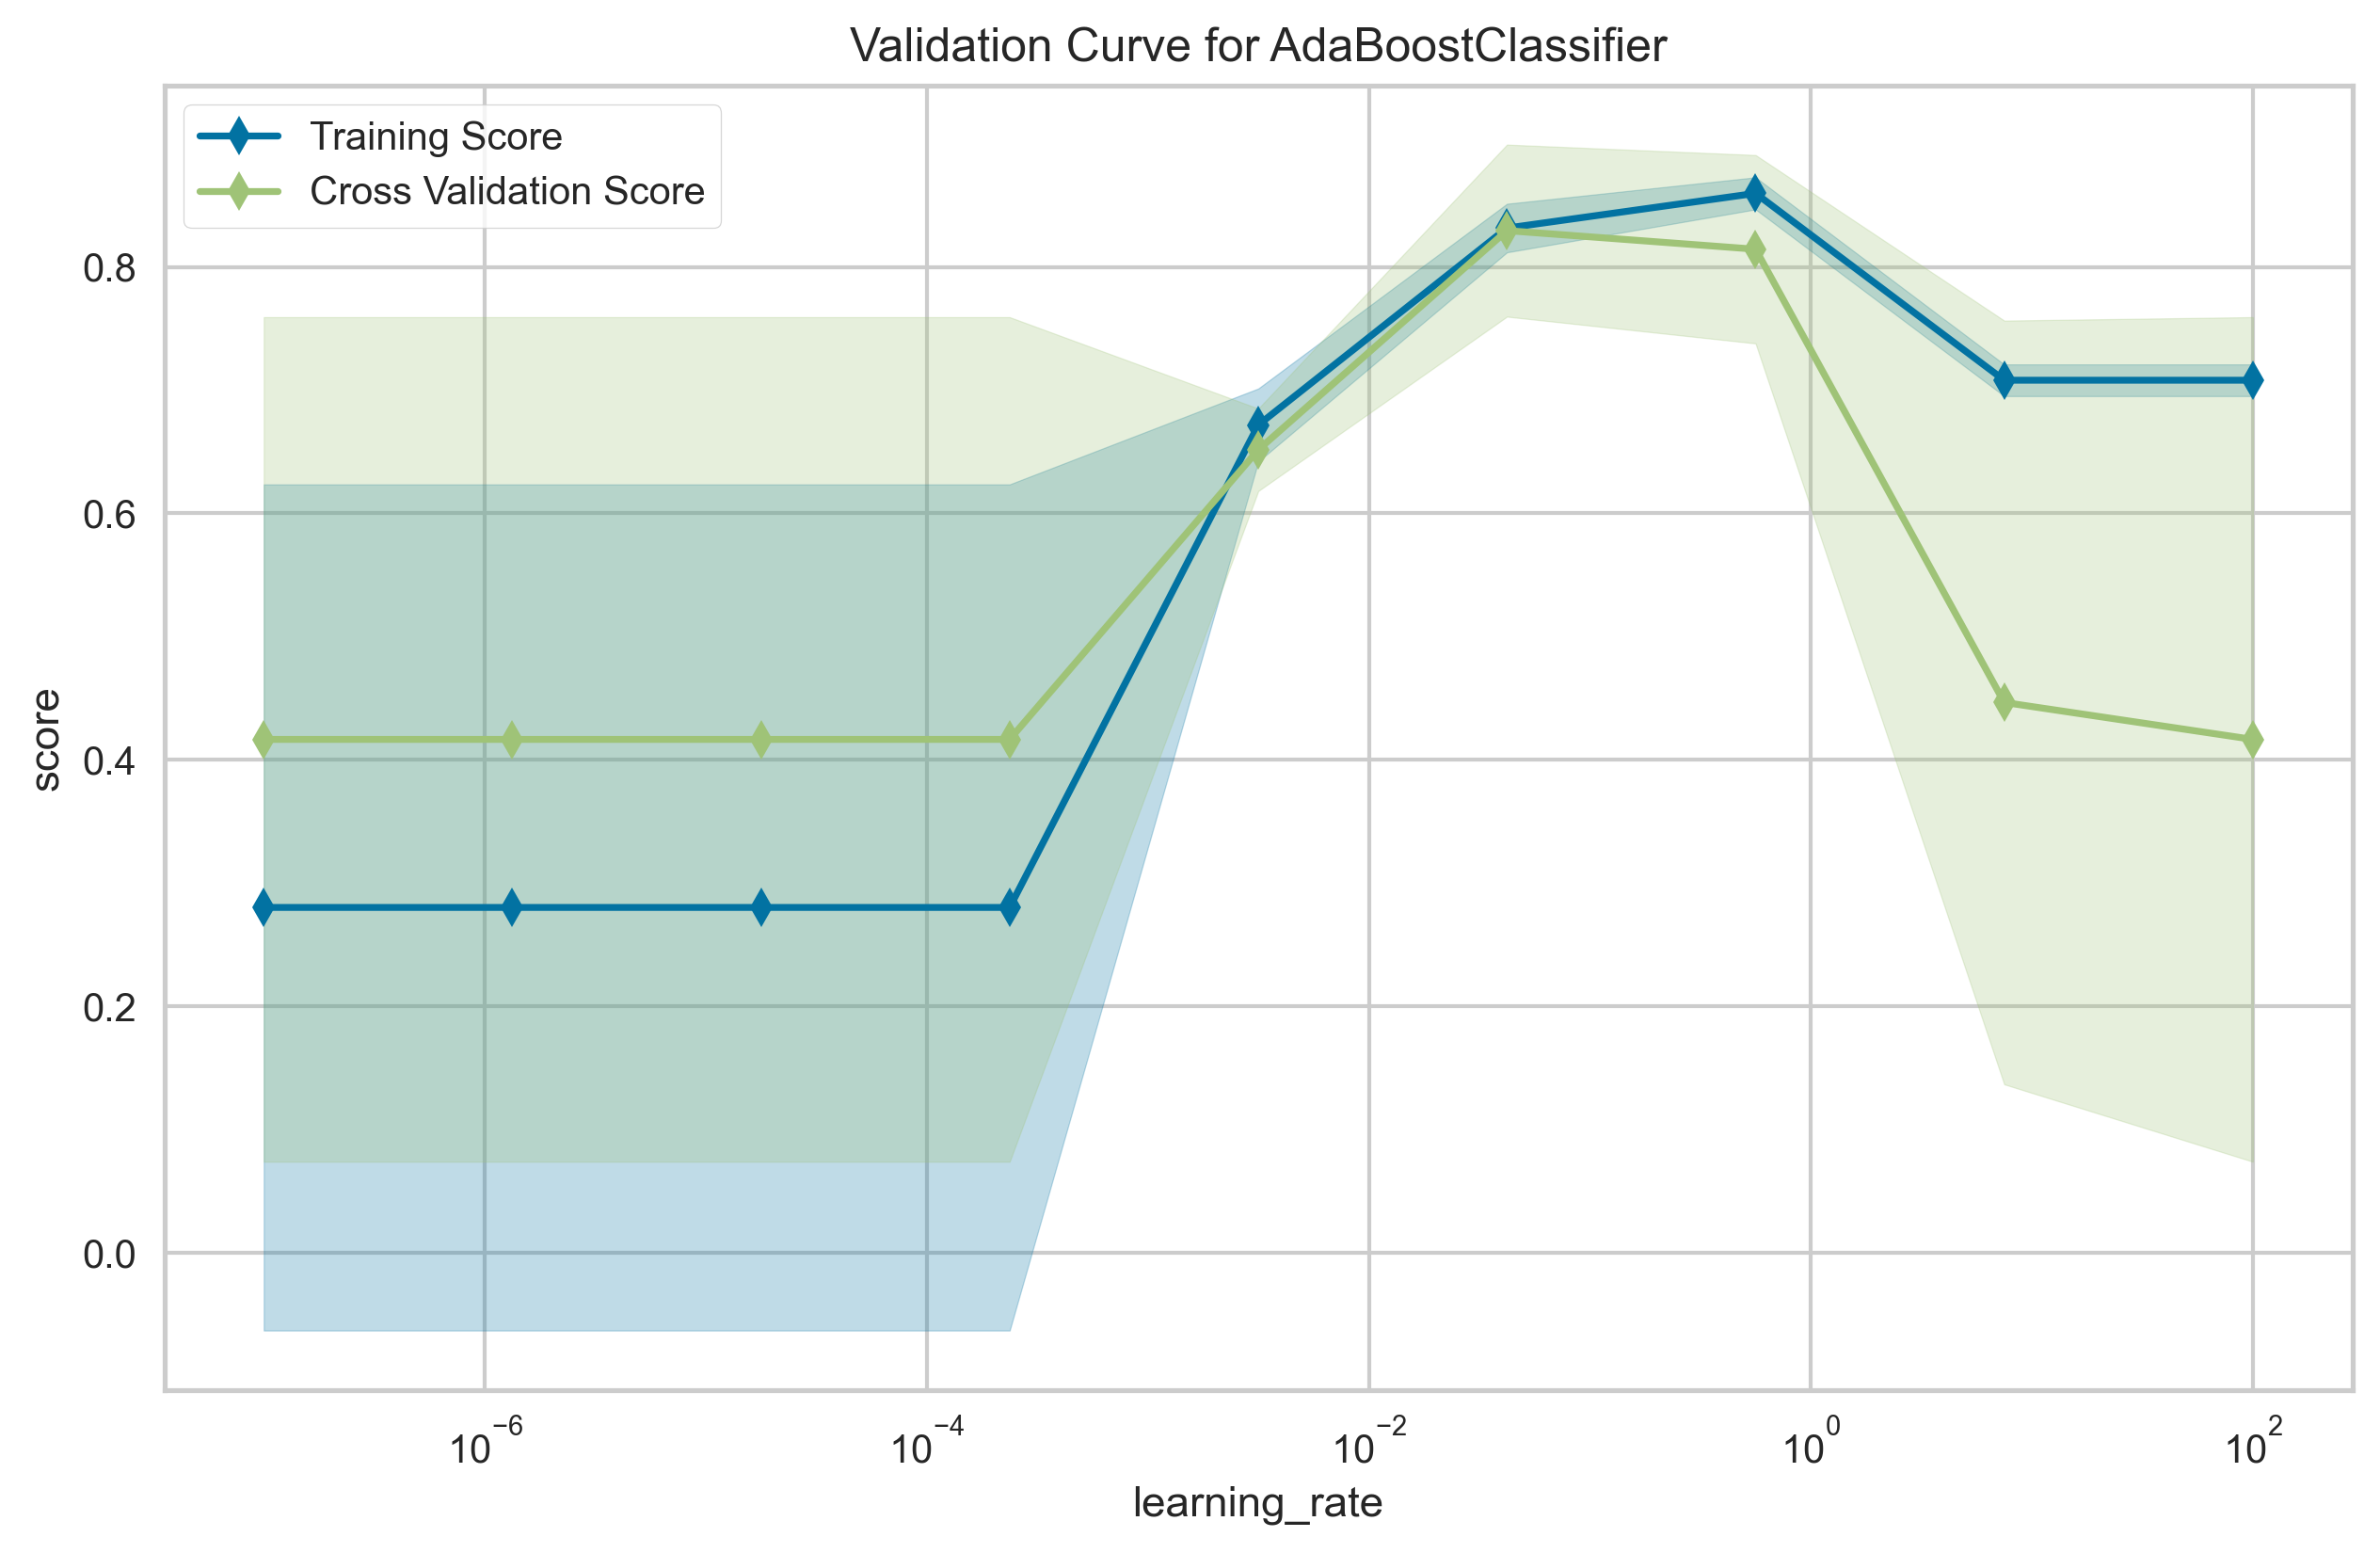

In [25]:
boost_clf = AdaBoostClassifier(random_state=SEED)
viz.validation_curve(
    clf=boost_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate",
    param_range=np.logspace(-7, 2, 9),
    output_path=f"{CREDIT_CARDS_BOOST_PATH}/boost_learning_rate.png",
    logx=True,
)

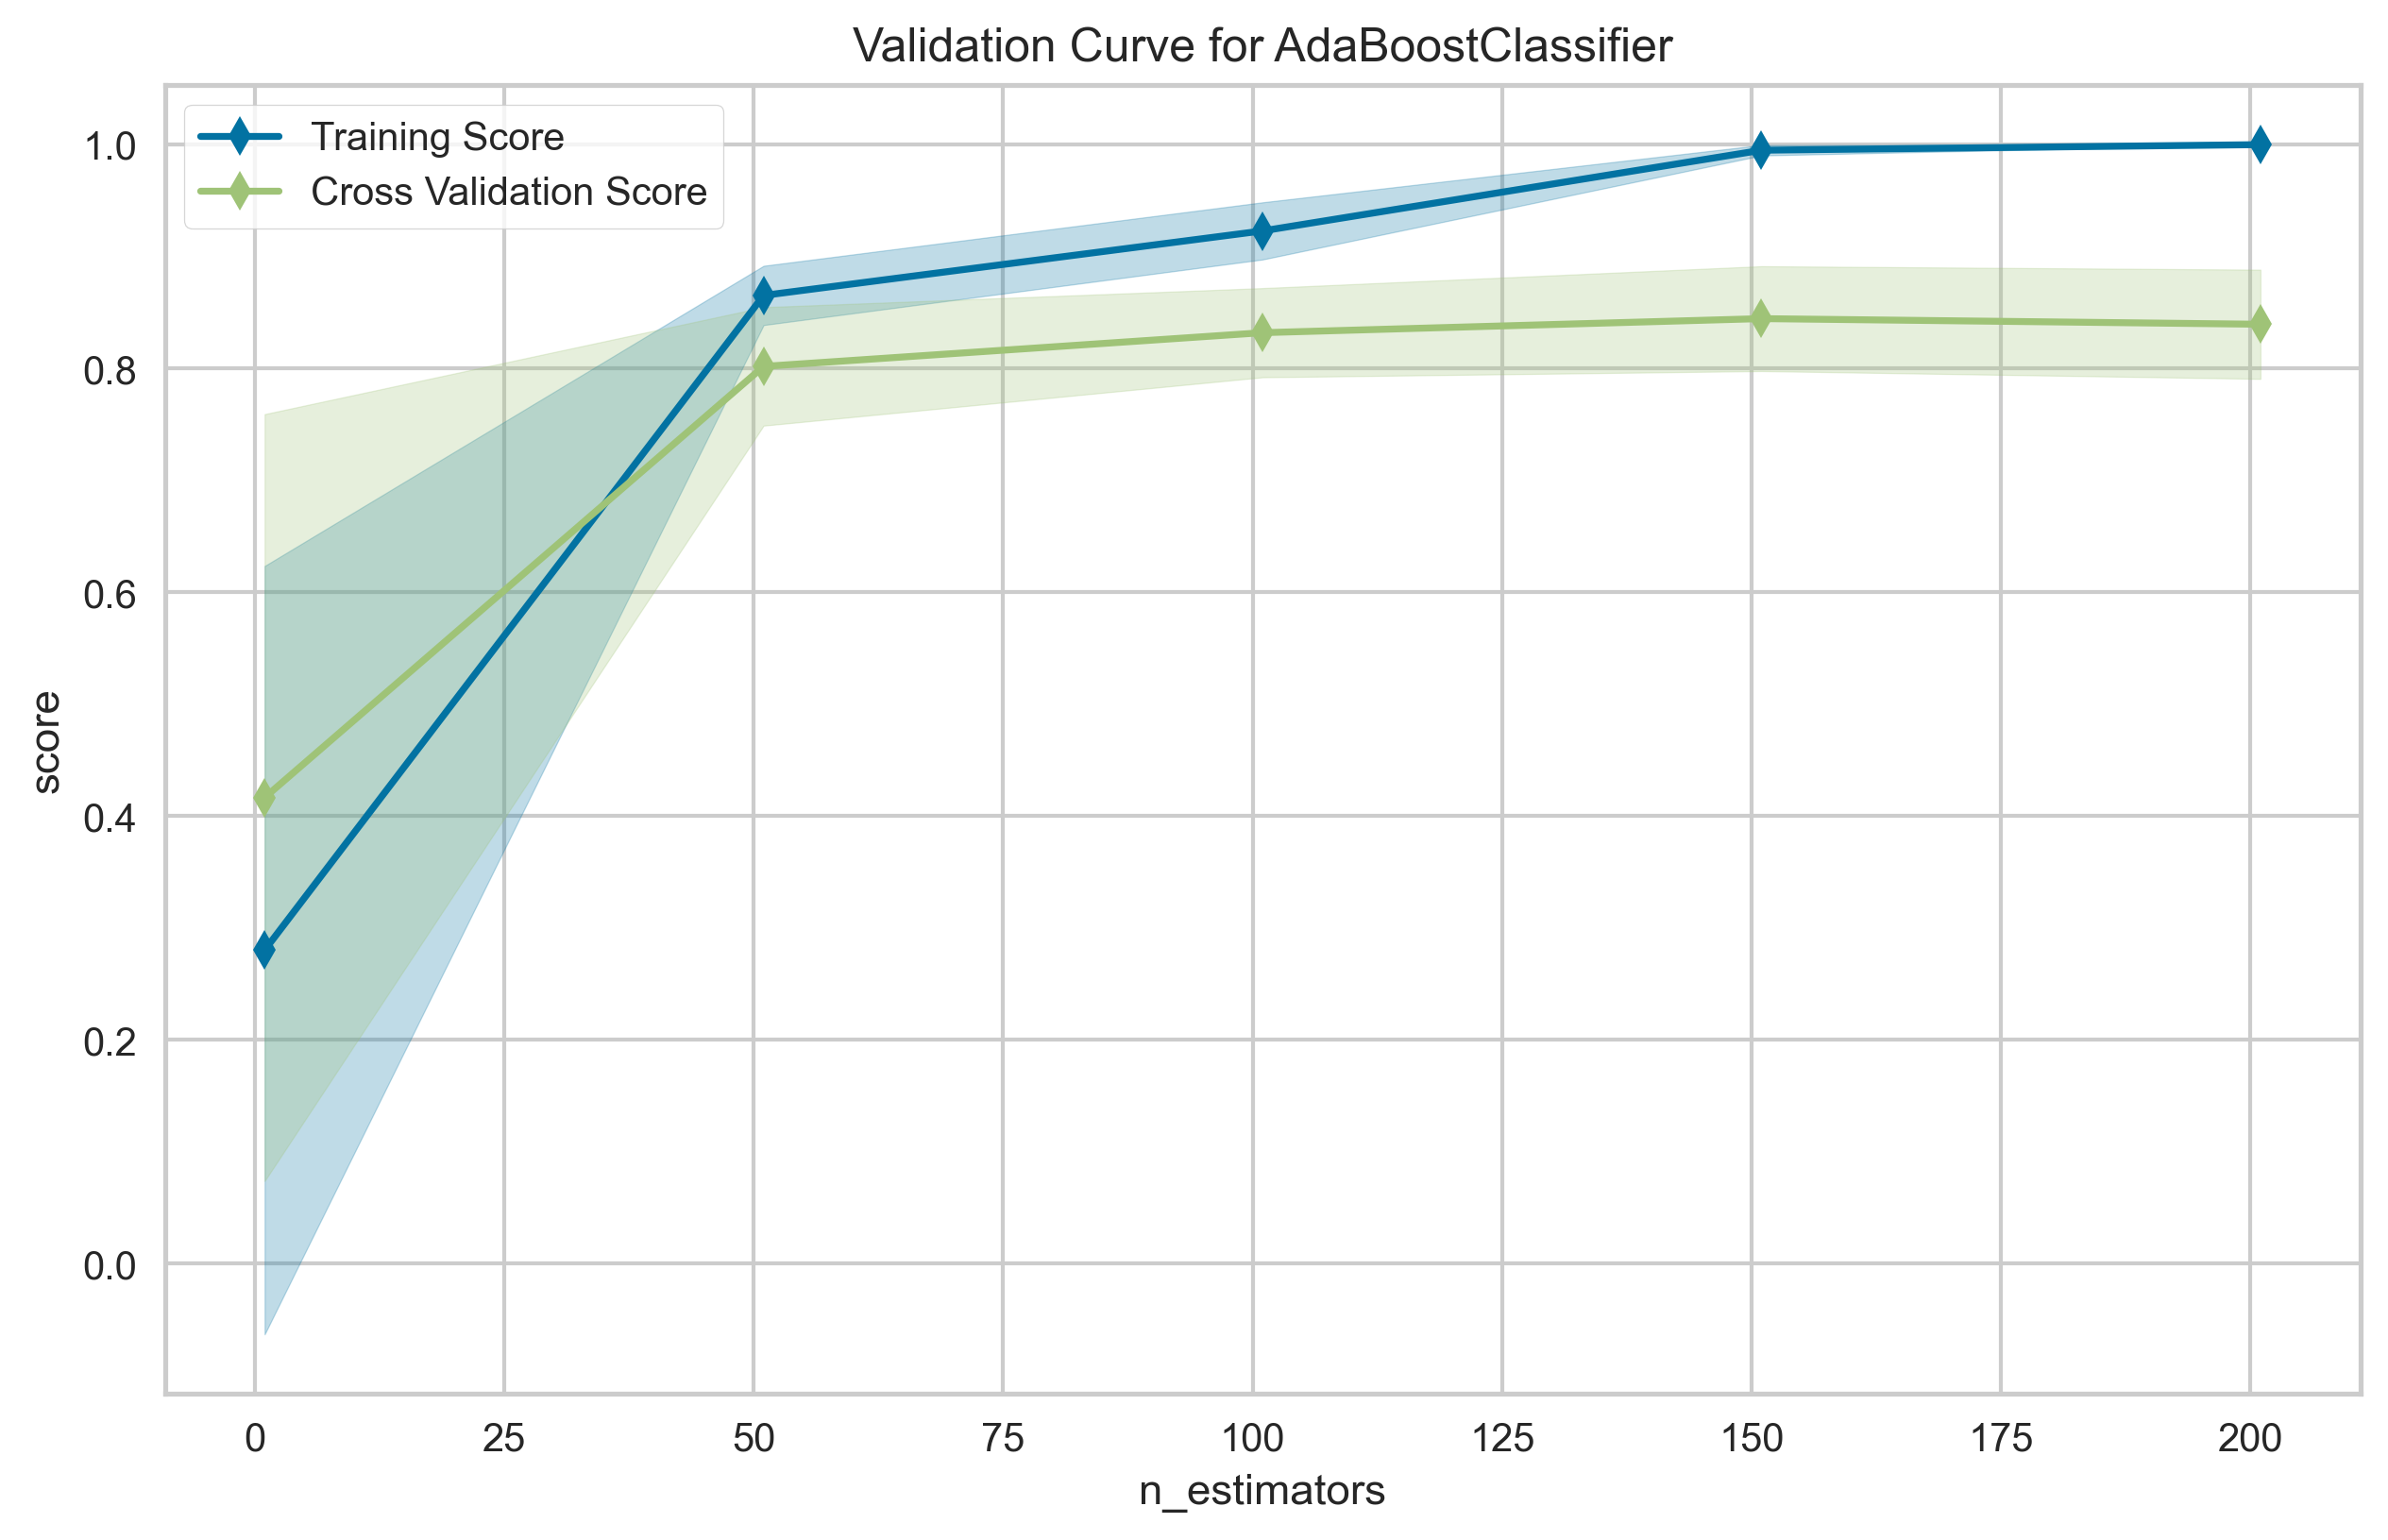

In [26]:
boost_clf = AdaBoostClassifier(random_state=SEED)
viz.validation_curve(
    clf=boost_clf,
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_name="n_estimators",
    param_range=np.arange(1, 250, 50),
    output_path=f"{CREDIT_CARDS_BOOST_PATH}/boost_n_estimators.png"
)

In [37]:
best_boost_params = training.perform_hyperparameter_tuning(
    clf=AdaBoostClassifier(random_state=SEED),
    X_tr=X_train,
    y_tr=y_train,
    cv=CV,
    param_space={
        "n_estimators": np.arange(50, 250, 50),
        "learning_rate": np.logspace(-4, 0, 4)
    },
    n_jobs=2
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [38]:
best_boost_params

{'learning_rate': 0.046415888336127774, 'n_estimators': 200}

In [39]:
def instantiate_best_boost_clf():
    return AdaBoostClassifier(learning_rate=best_boost_params['learning_rate'],
                              n_estimators=best_boost_params['n_estimators'],
                              random_state=SEED)

KeyboardInterrupt: 

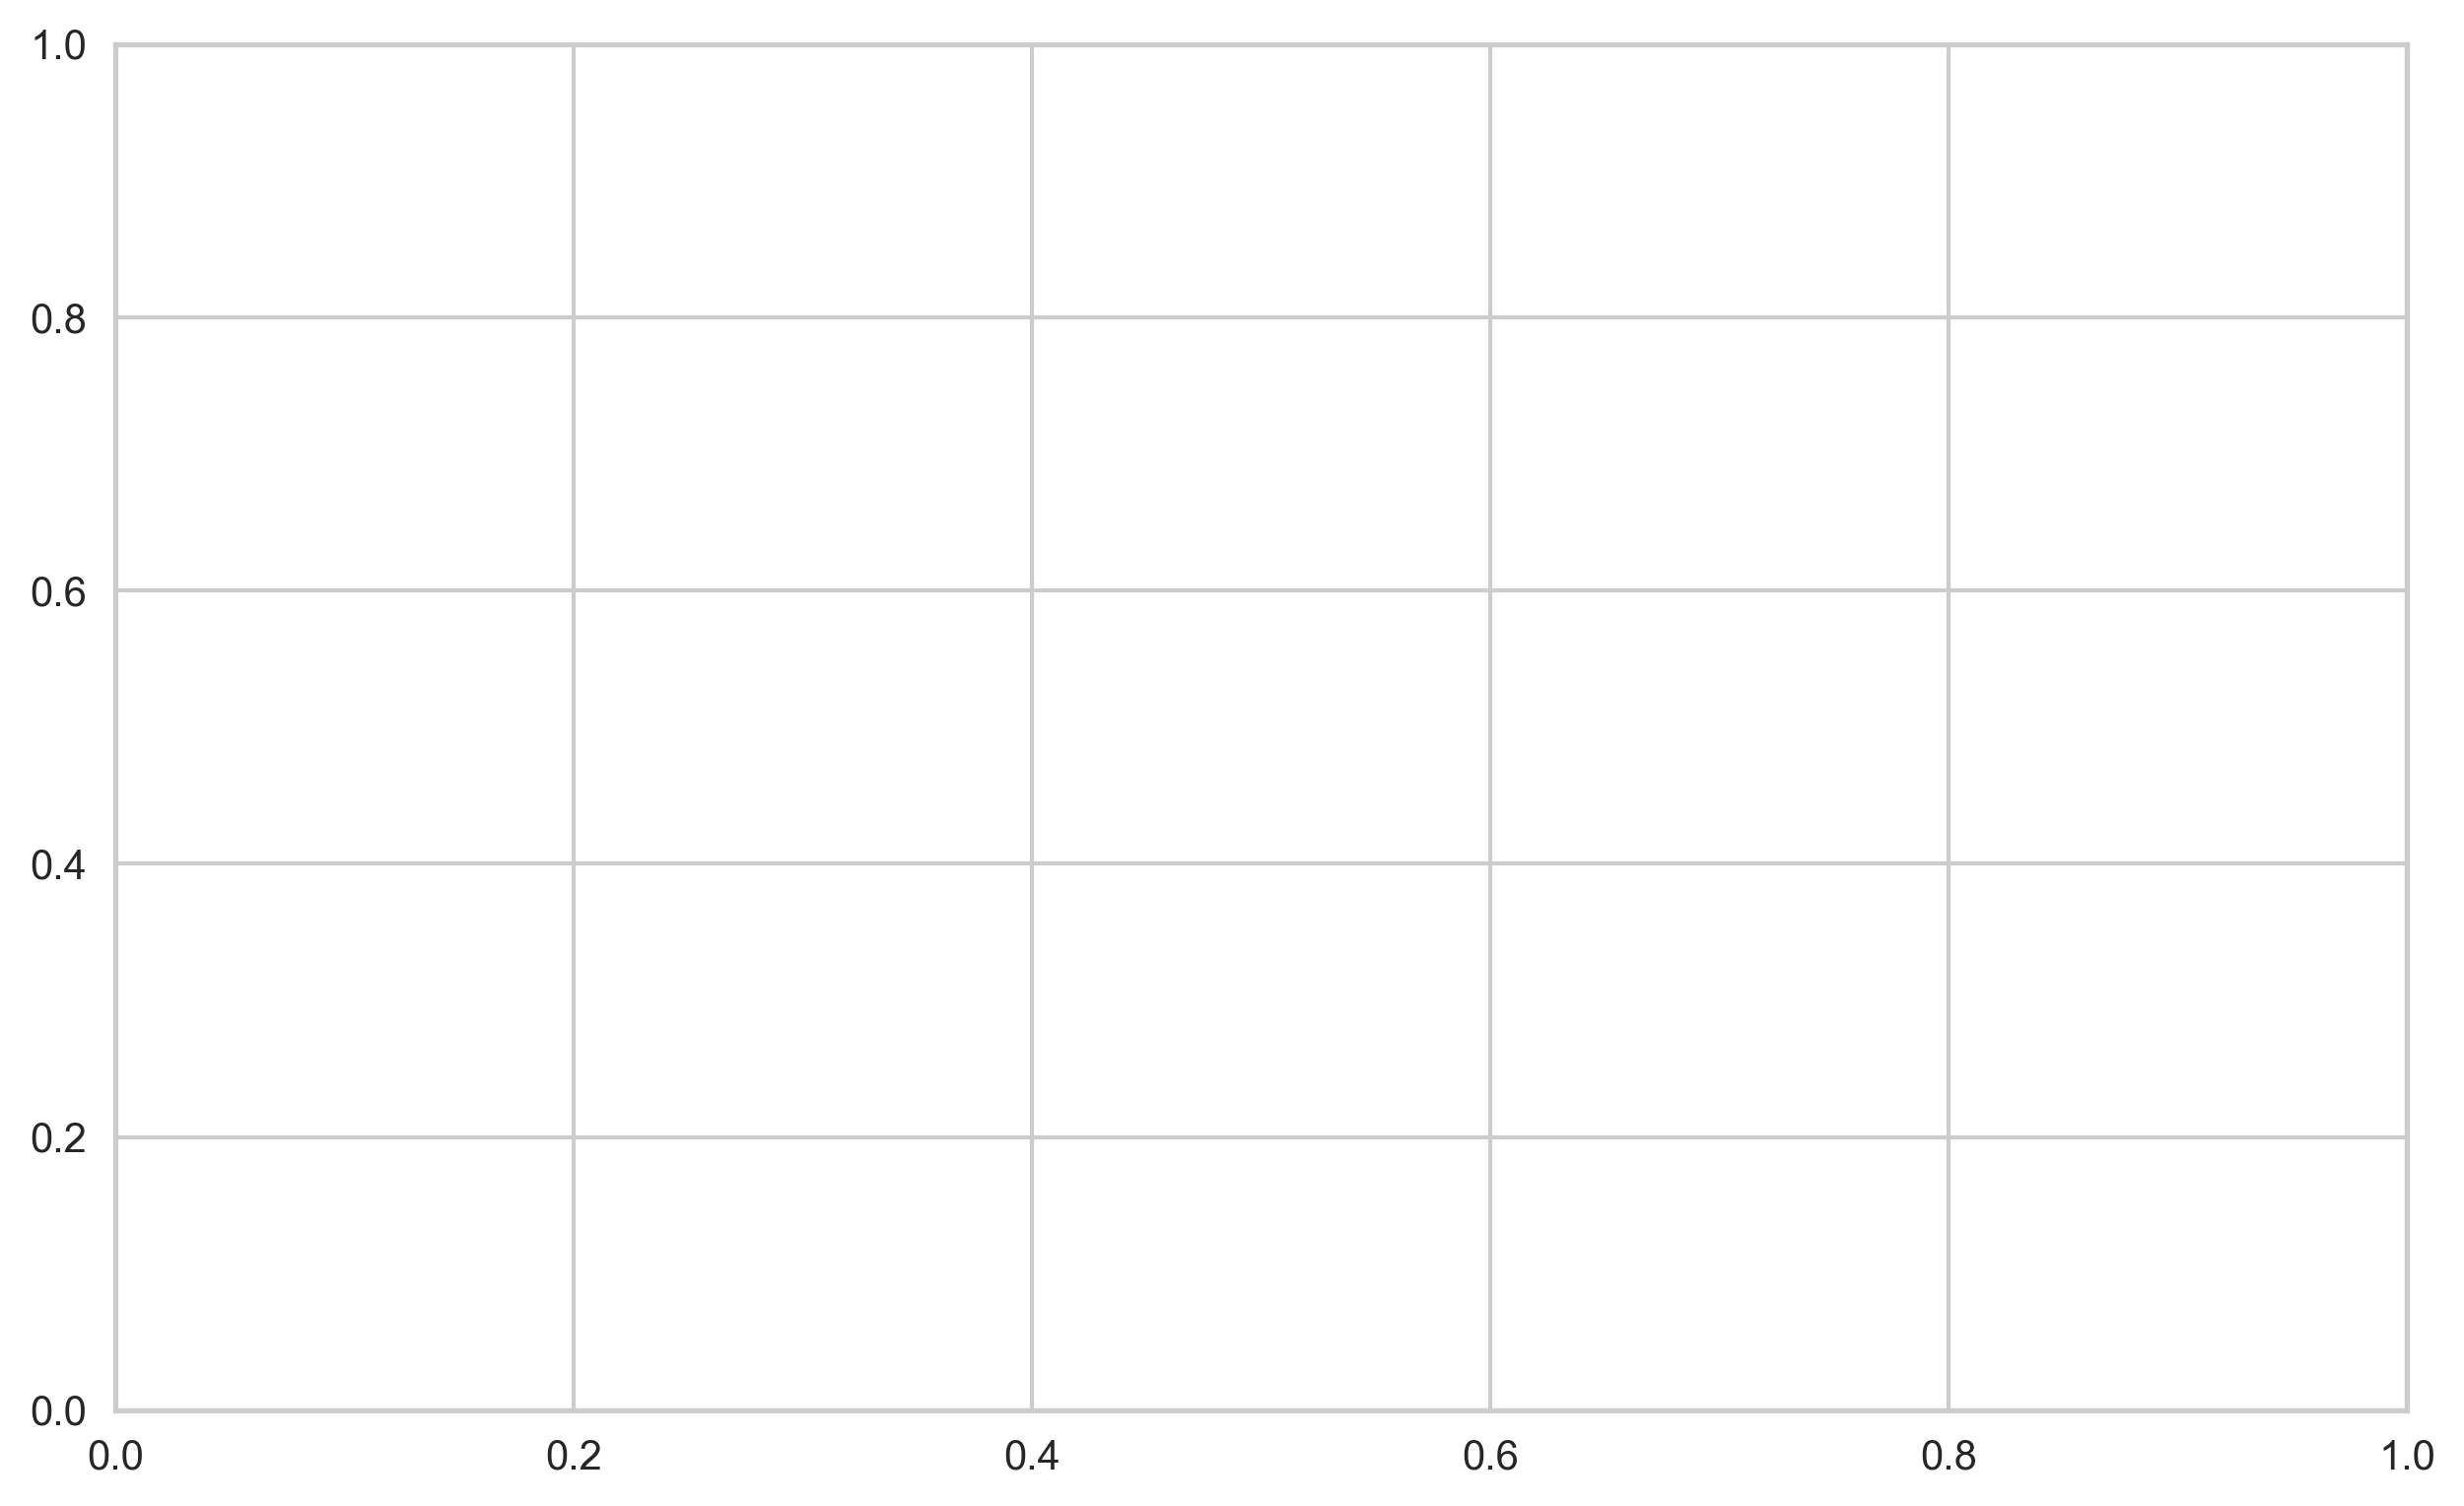

In [41]:
best_boost_clf = instantiate_best_boost_clf()
viz.learning_curve(clf=best_boost_clf,
                   X_tr=X_train,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{CREDIT_CARDS_BOOST_PATH}/boost_learning_curve.png")

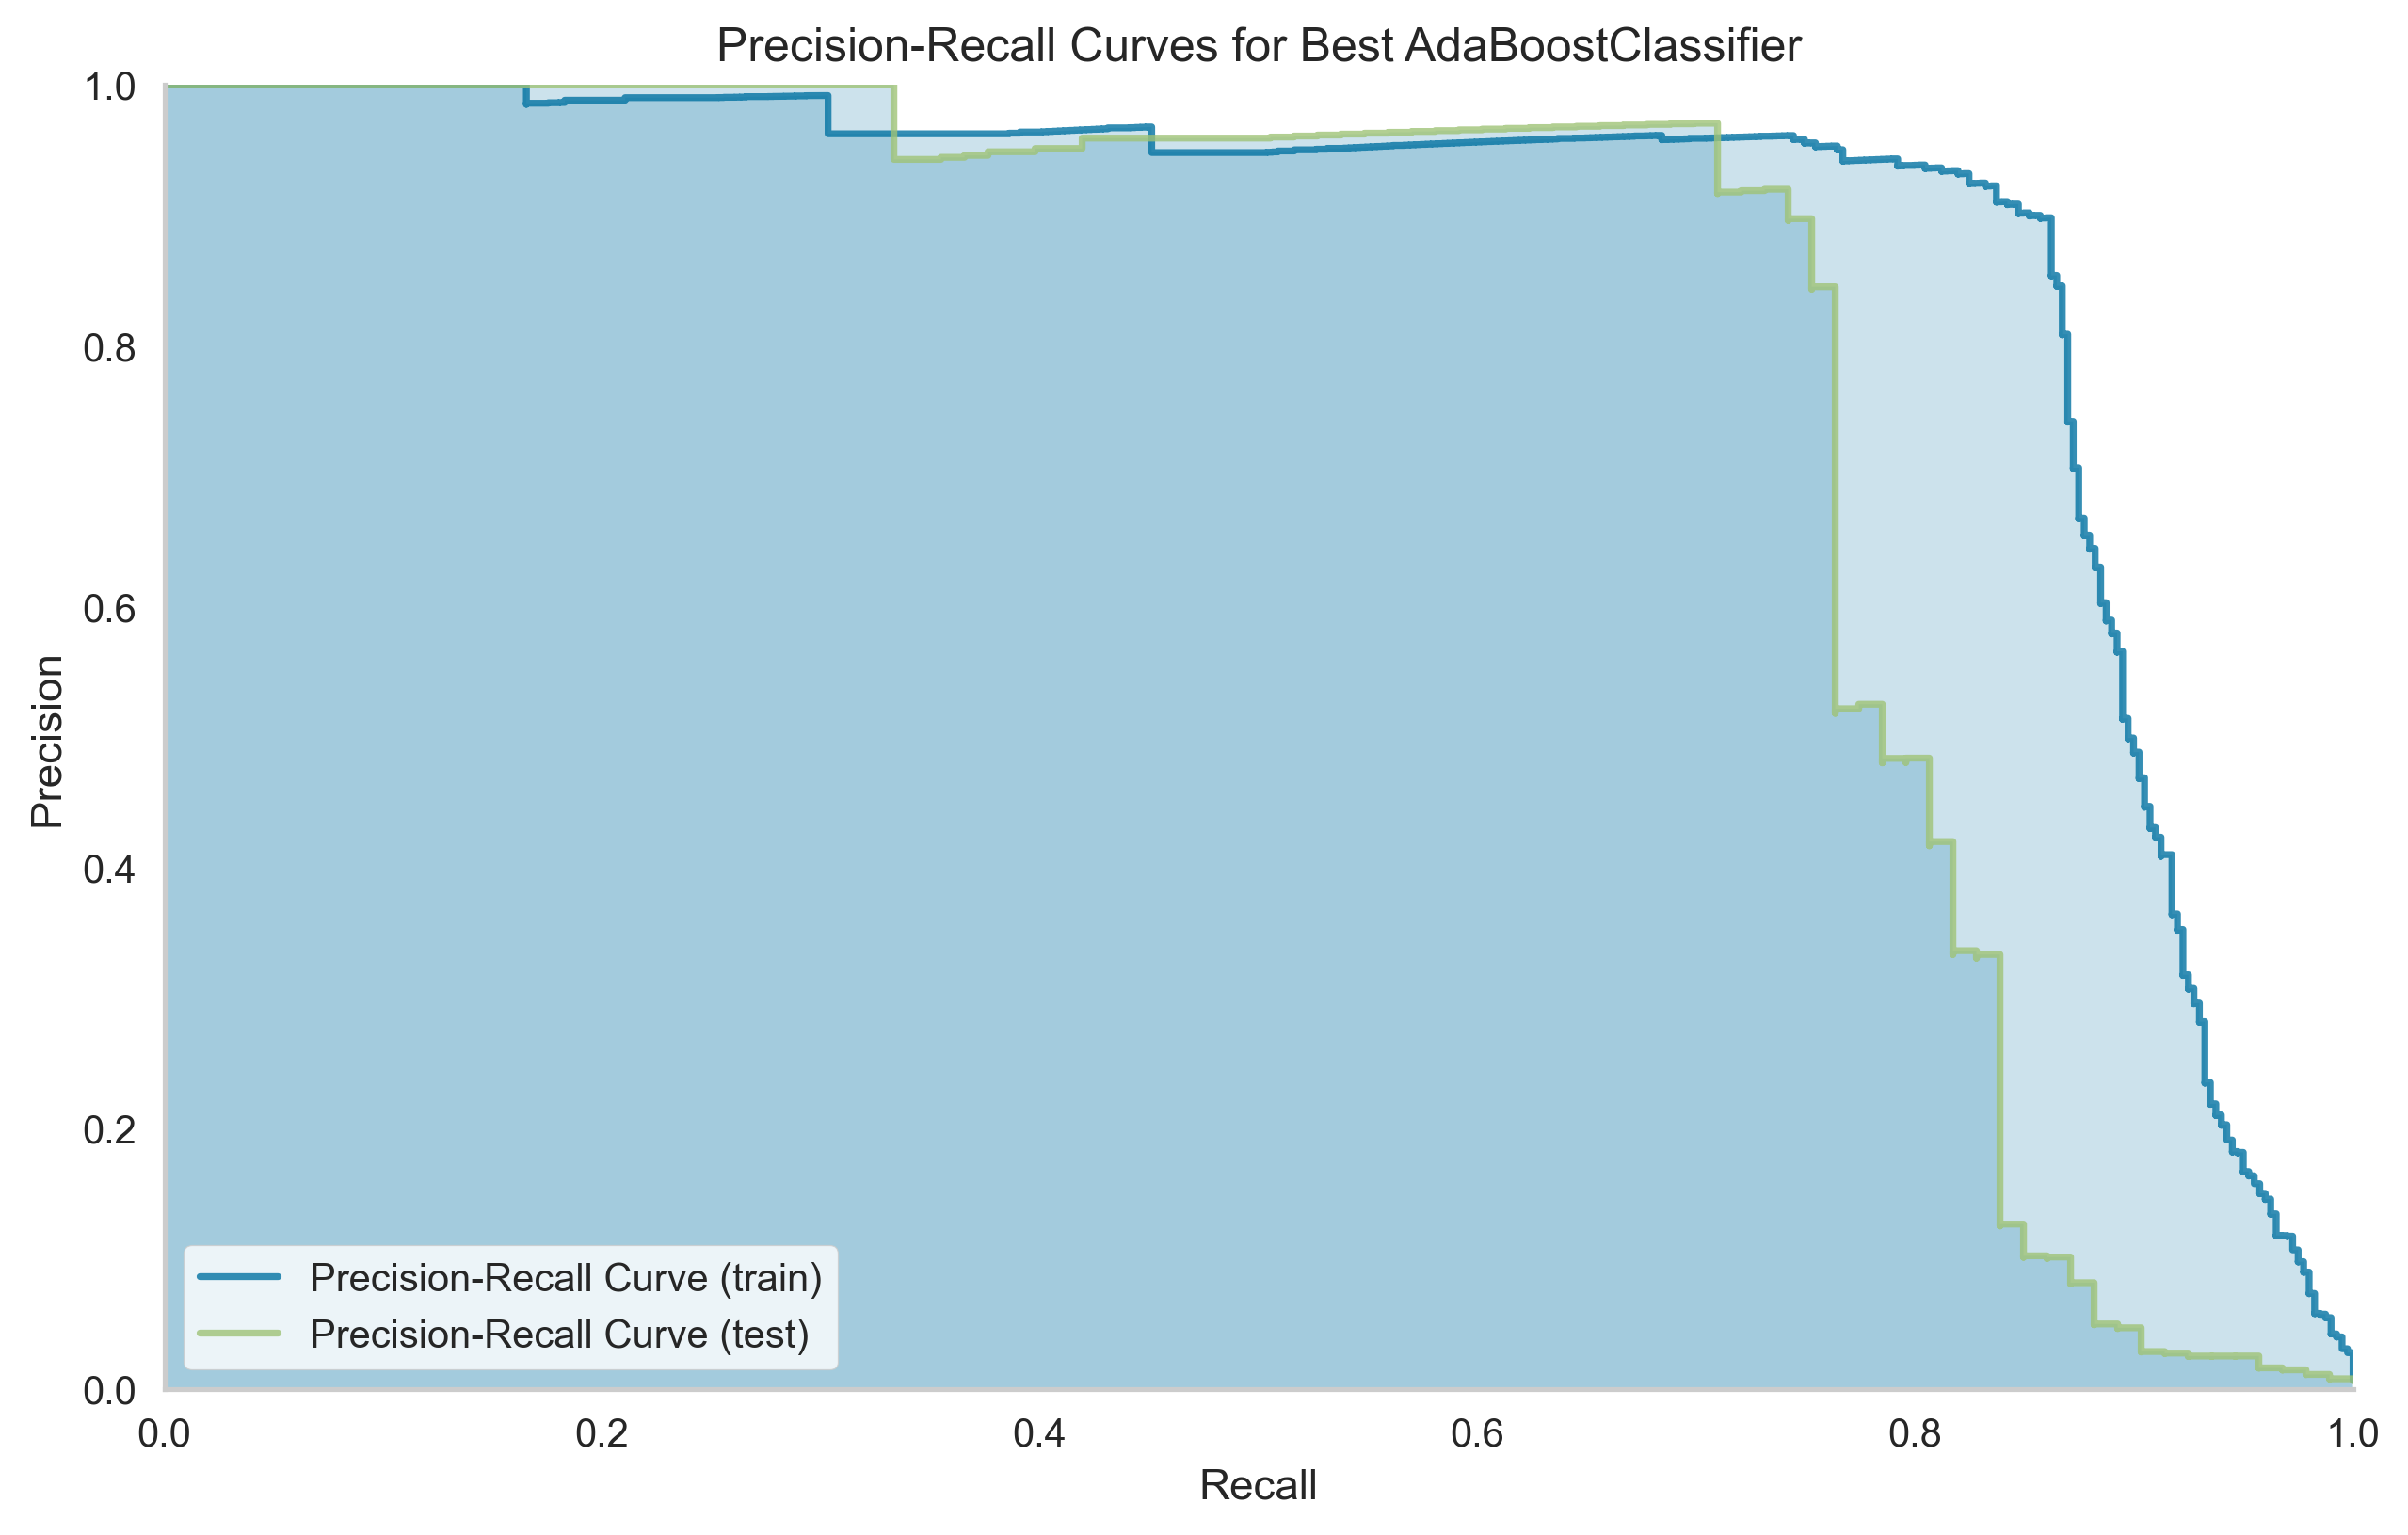

In [42]:
best_boost_clf = instantiate_best_boost_clf()
best_boost_clf.fit(X_train, y_train)
viz.precision_recall_curve(
    clf=best_boost_clf,
    X_tr=X_train,
    y_tr=y_train,
    X_t=X_test,
    y_t=y_test,
    title='Precision-Recall Curves for Best AdaBoostClassifier',
    output_path=f'{CREDIT_CARDS_BOOST_PATH}/best_boost_pr_curves.png')

In [43]:
metrics.recall_at_precision_stats(0.9,
                                  best_boost_clf,
                                  X_tr=X_train,
                                  y_tr=y_train,
                                  X_t=X_test,
                                  y_t=y_test)

Recall @ Precision 0.9 (train): 0.8571
Recall @ Precision 0.9 (test) : 0.7419


In [44]:
best_boost_clf = instantiate_best_boost_clf()
training.learning_time_stats(best_boost_clf,
                             X_tr=X_train,
                             y_tr=y_train,
                             )

Training time, total: 39.9236 seconds
Training time, normalized (per 1000 samples): 0.6973 seconds


In [45]:
training.inference_time_stats(best_boost_clf, X_train, dataset_name='train')
training.inference_time_stats(best_boost_clf, X_test, dataset_name='test')
training.inference_time_stats(best_boost_clf, X, dataset_name='all')

Inference time (train), total: 0.8013 seconds
Inference time (train), normalized (per 1000 samples): 0.0140 seconds
Inference time (test), total: 0.2090 seconds
Inference time (test), normalized (per 1000 samples): 0.0146 seconds
Inference time (all), total: 0.9963 seconds
Inference time (all), normalized (per 1000 samples): 0.0139 seconds


# K-NN

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `K`
    b. `p`in minkowski metric
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [75]:
CREDIT_CARDS_KNN_PATH = f'{CREDIT_CARDS_PATH}/knn'

In [76]:
knn_baseline_clf = KNeighborsClassifier()
knn_baseline_clf.fit(X_train_n, y_train)

KNeighborsClassifier()

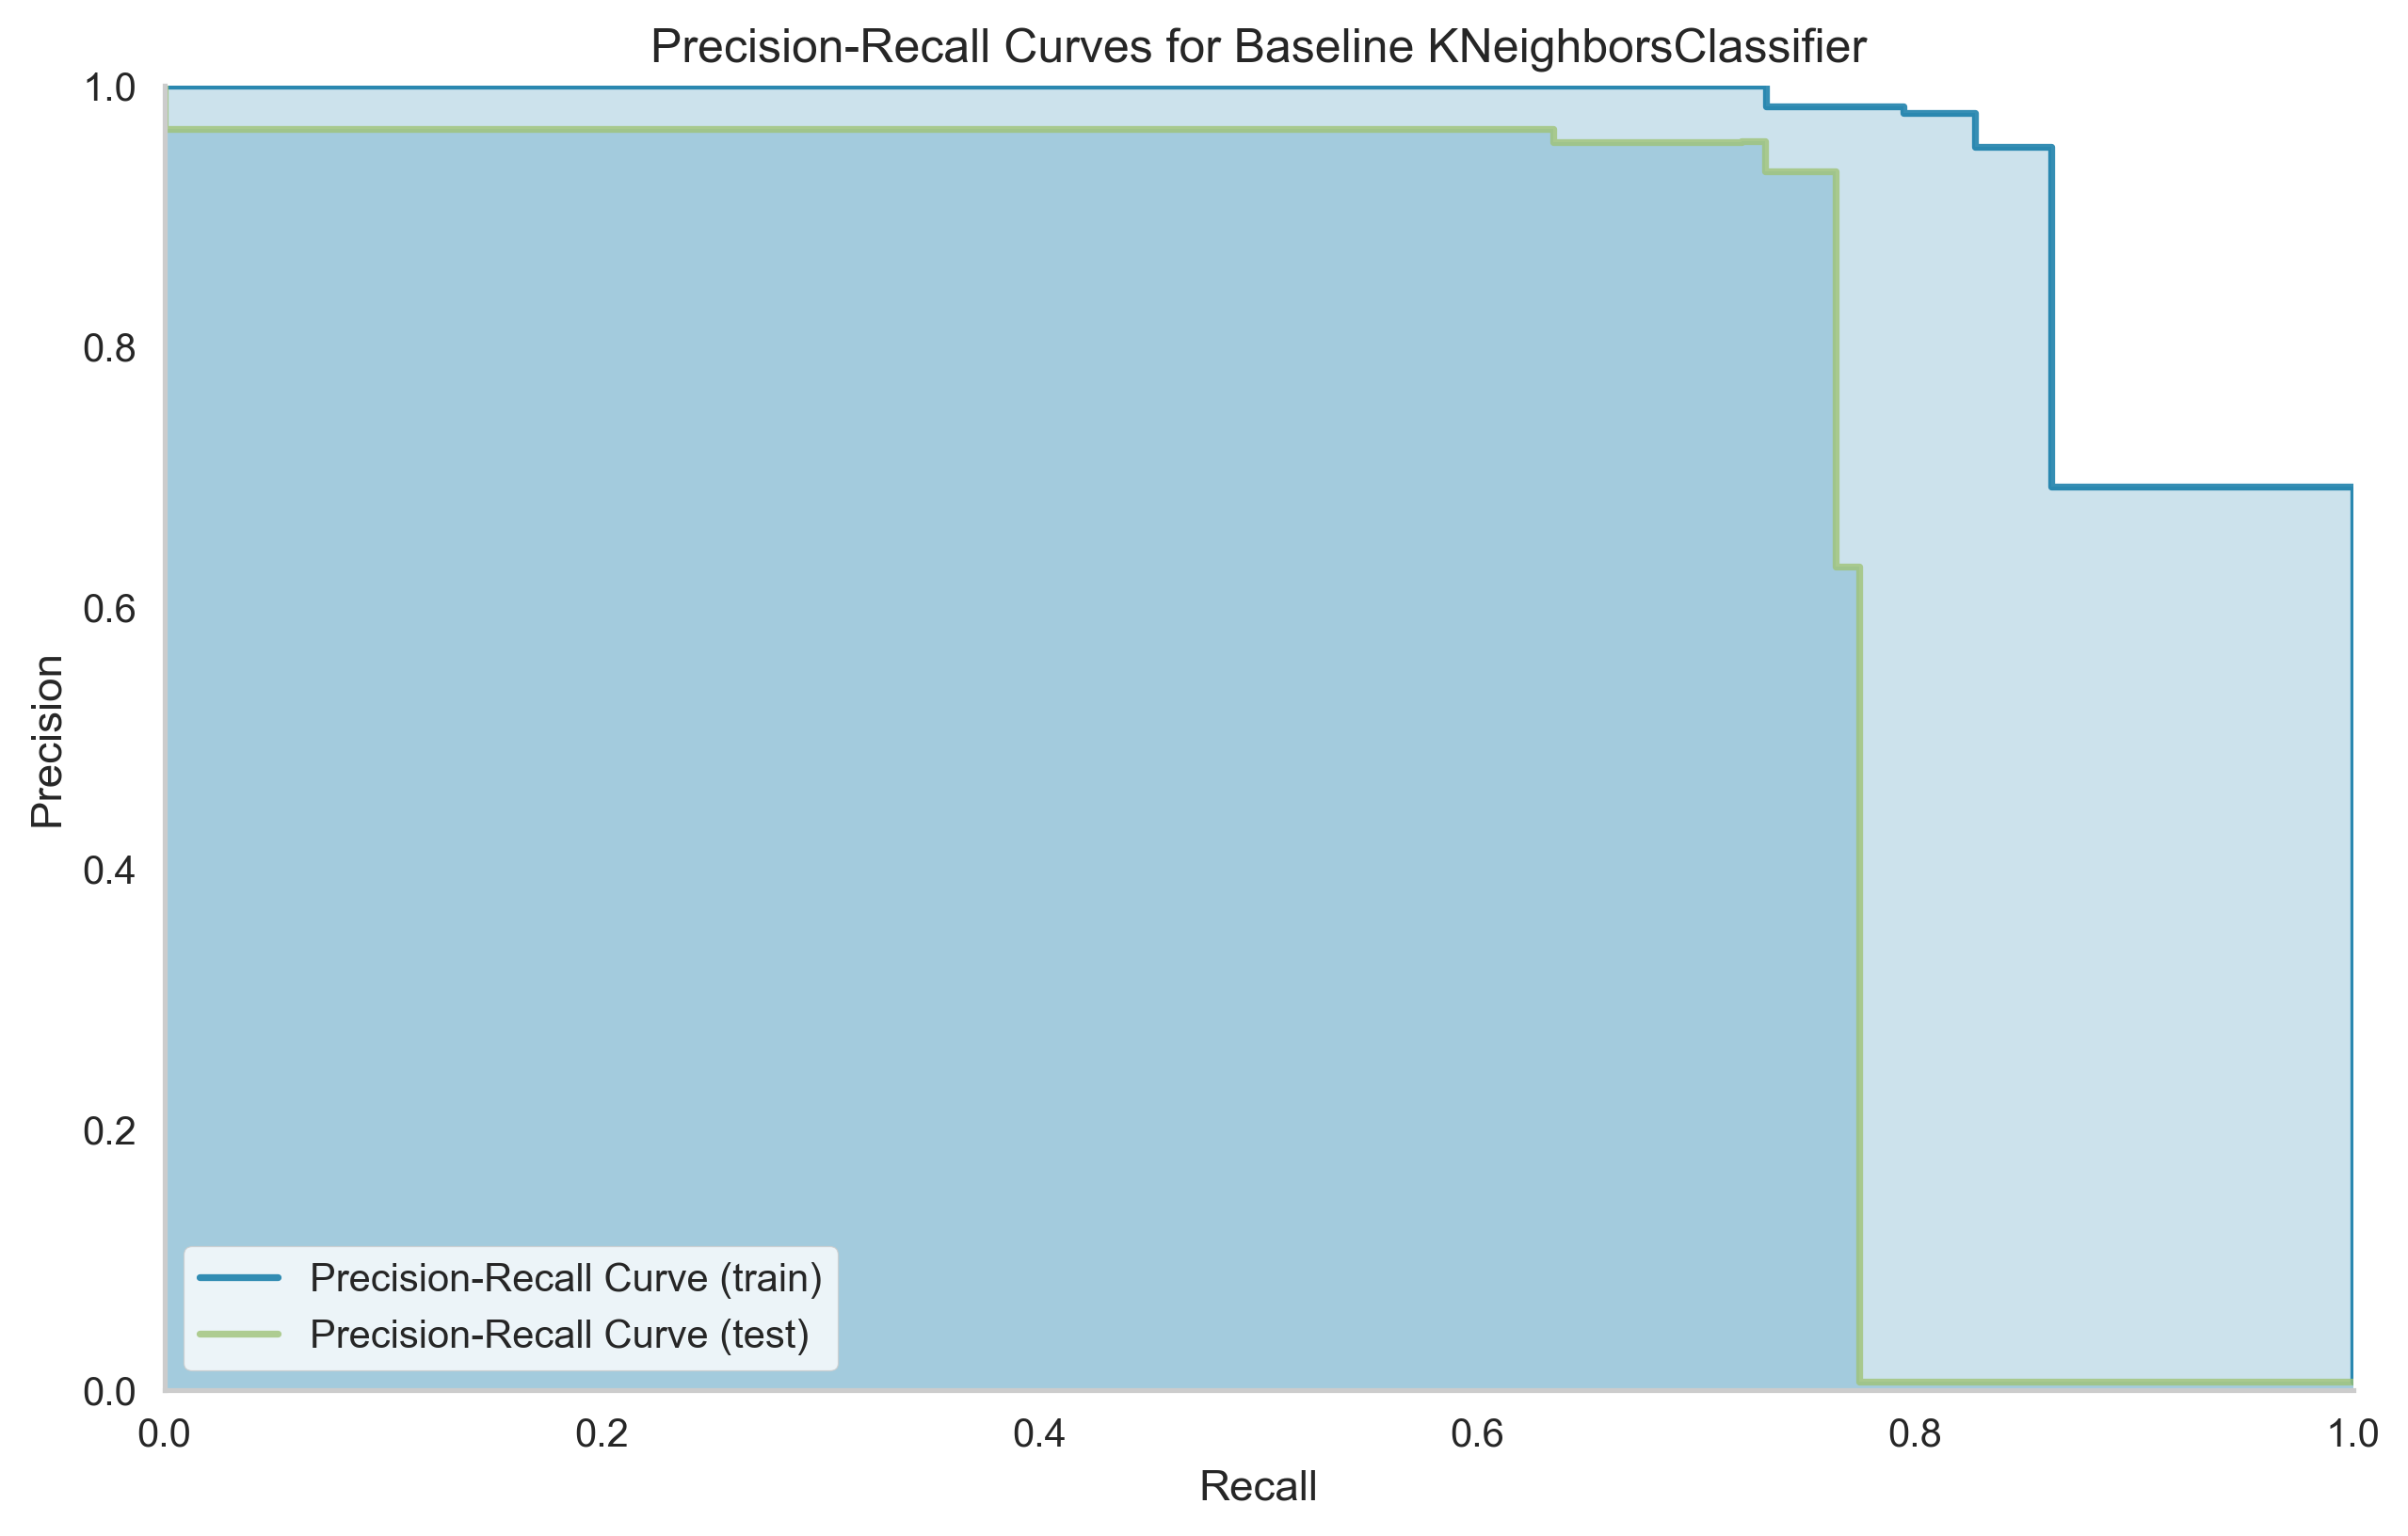

In [77]:
viz.precision_recall_curve(
    clf=knn_baseline_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Baseline KNeighborsClassifier',
    output_path=f'{CREDIT_CARDS_KNN_PATH}/baseline_knn_pr_curves.png', )

In [78]:
metrics.recall_at_precision_stats(
    0.9,
    knn_baseline_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
)

Recall @ Precision 0.9 (train): 0.8622
Recall @ Precision 0.9 (test) : 0.7634


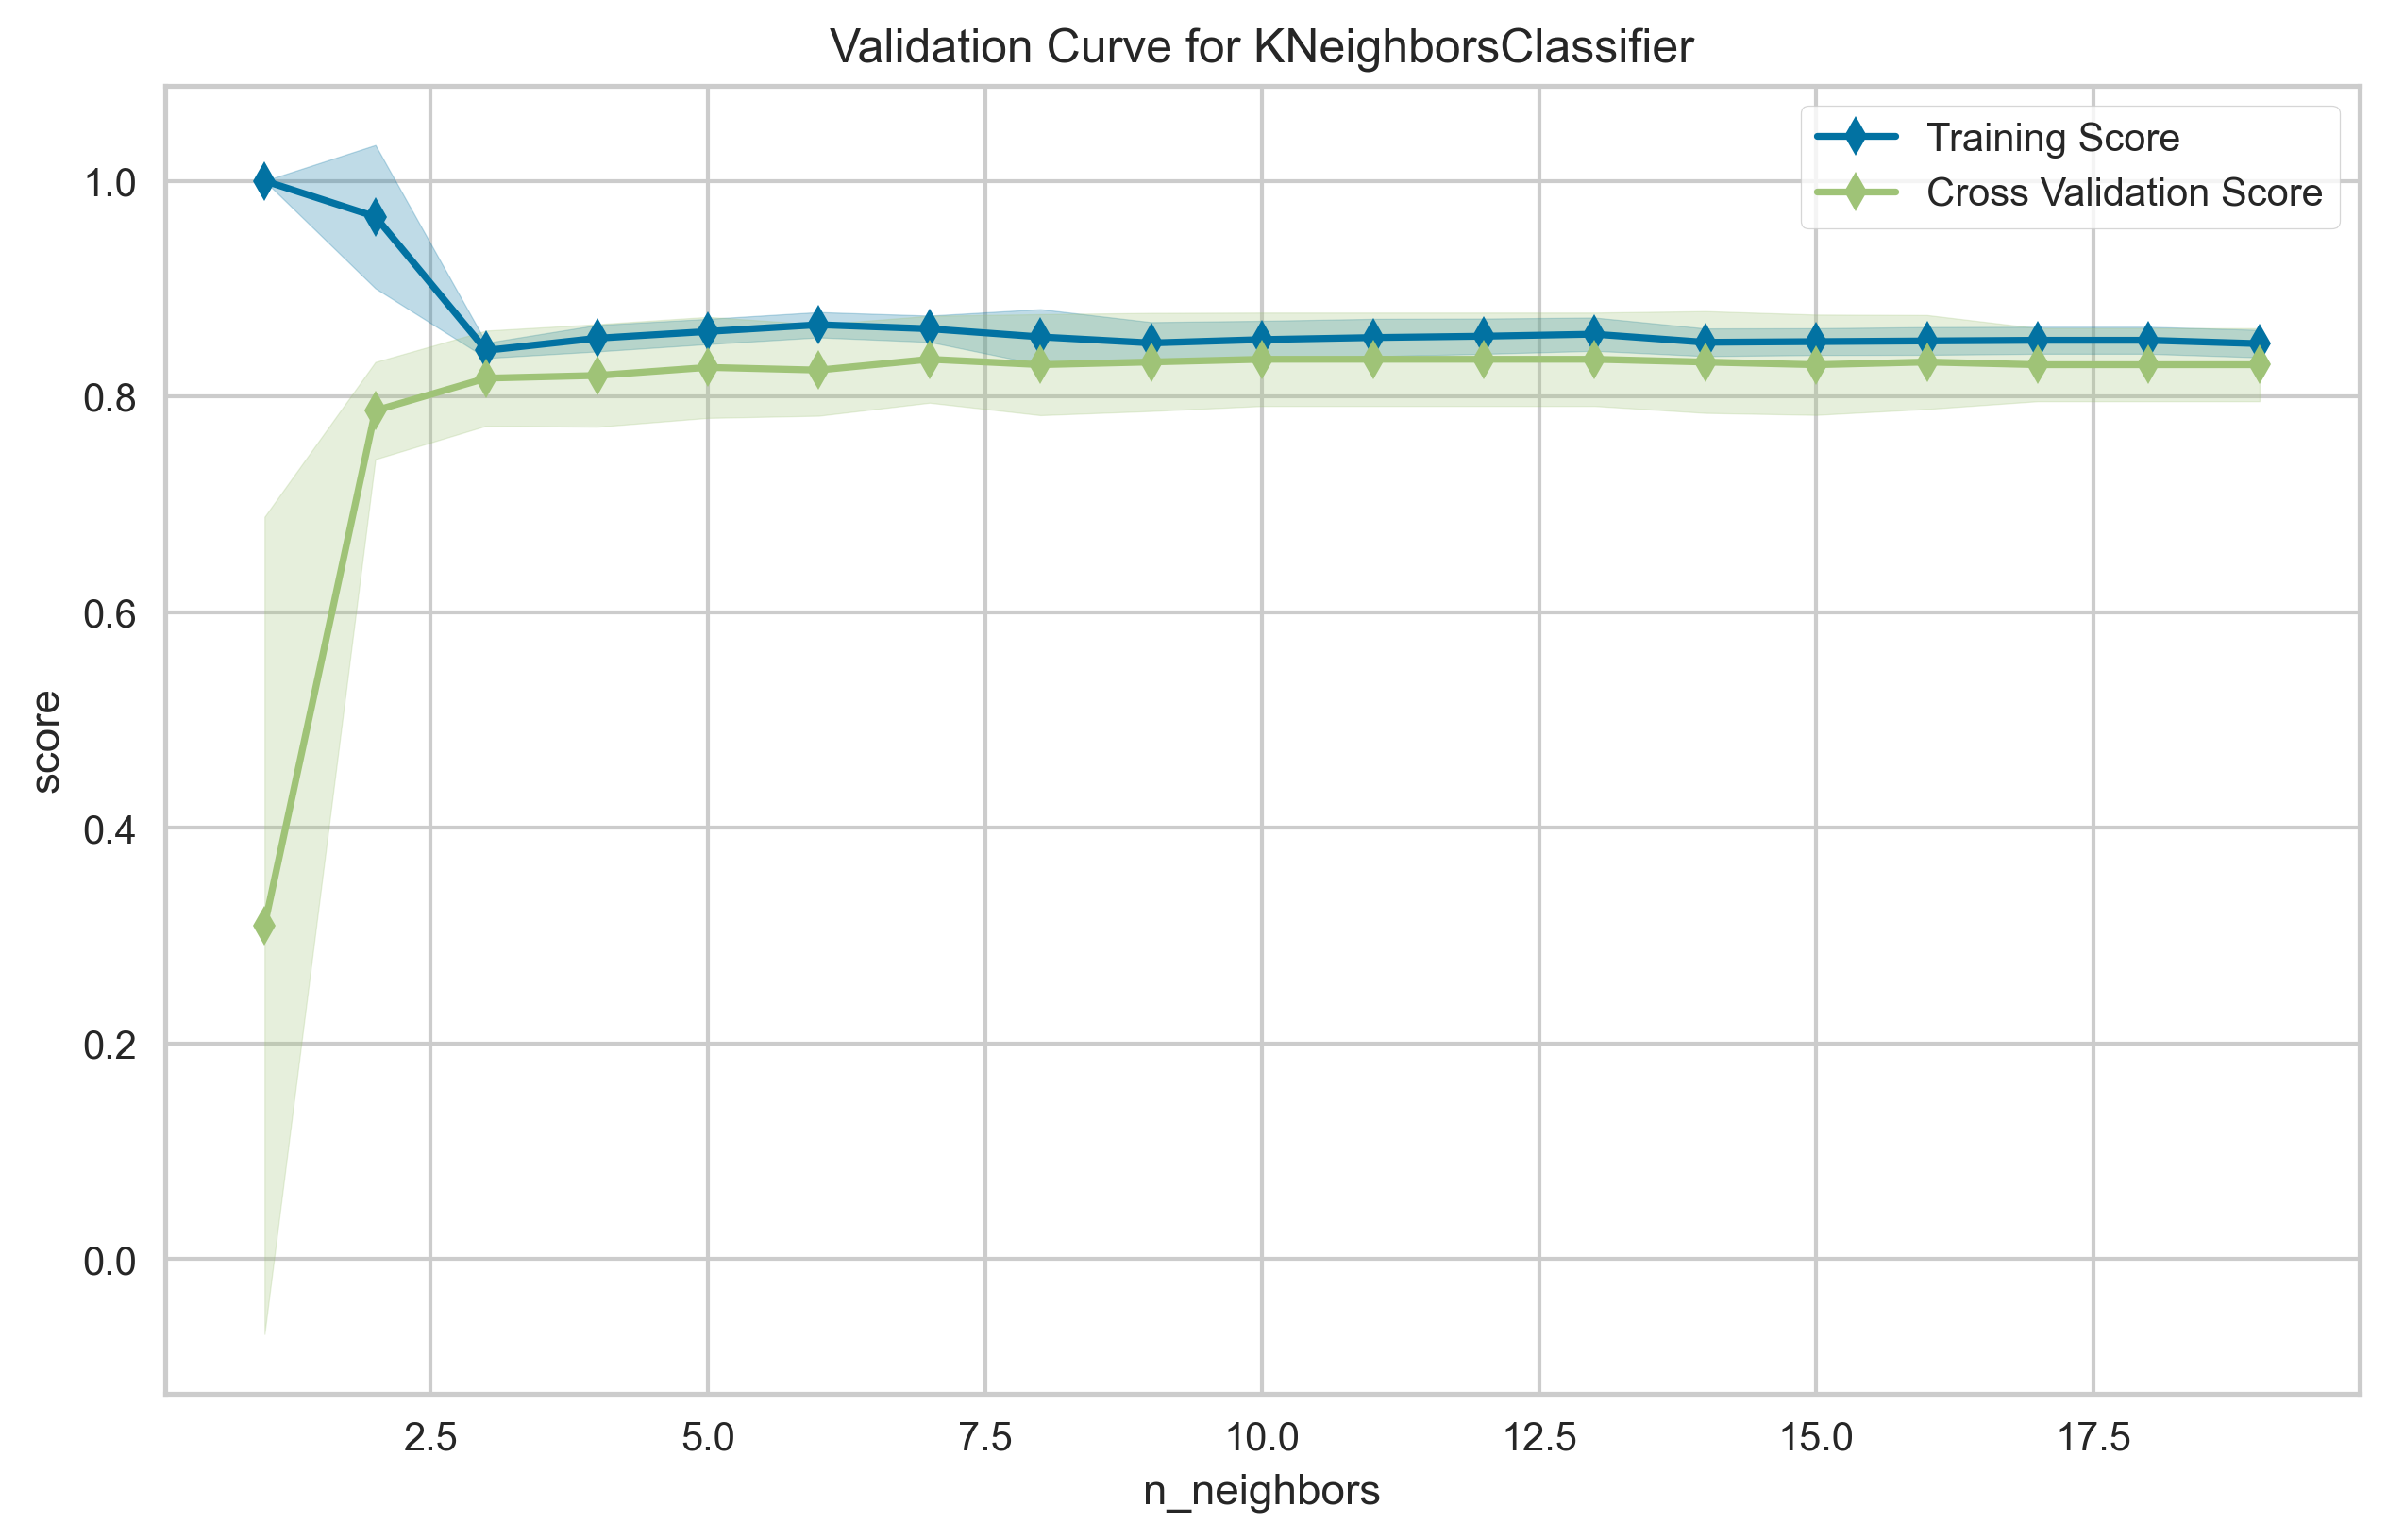

In [79]:
knn_clf = KNeighborsClassifier()
viz.validation_curve(
    clf=knn_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="n_neighbors",
    param_range=np.arange(1, 20, 1),
    output_path=f"{CREDIT_CARDS_KNN_PATH}/knn_n_neighbors.png",
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


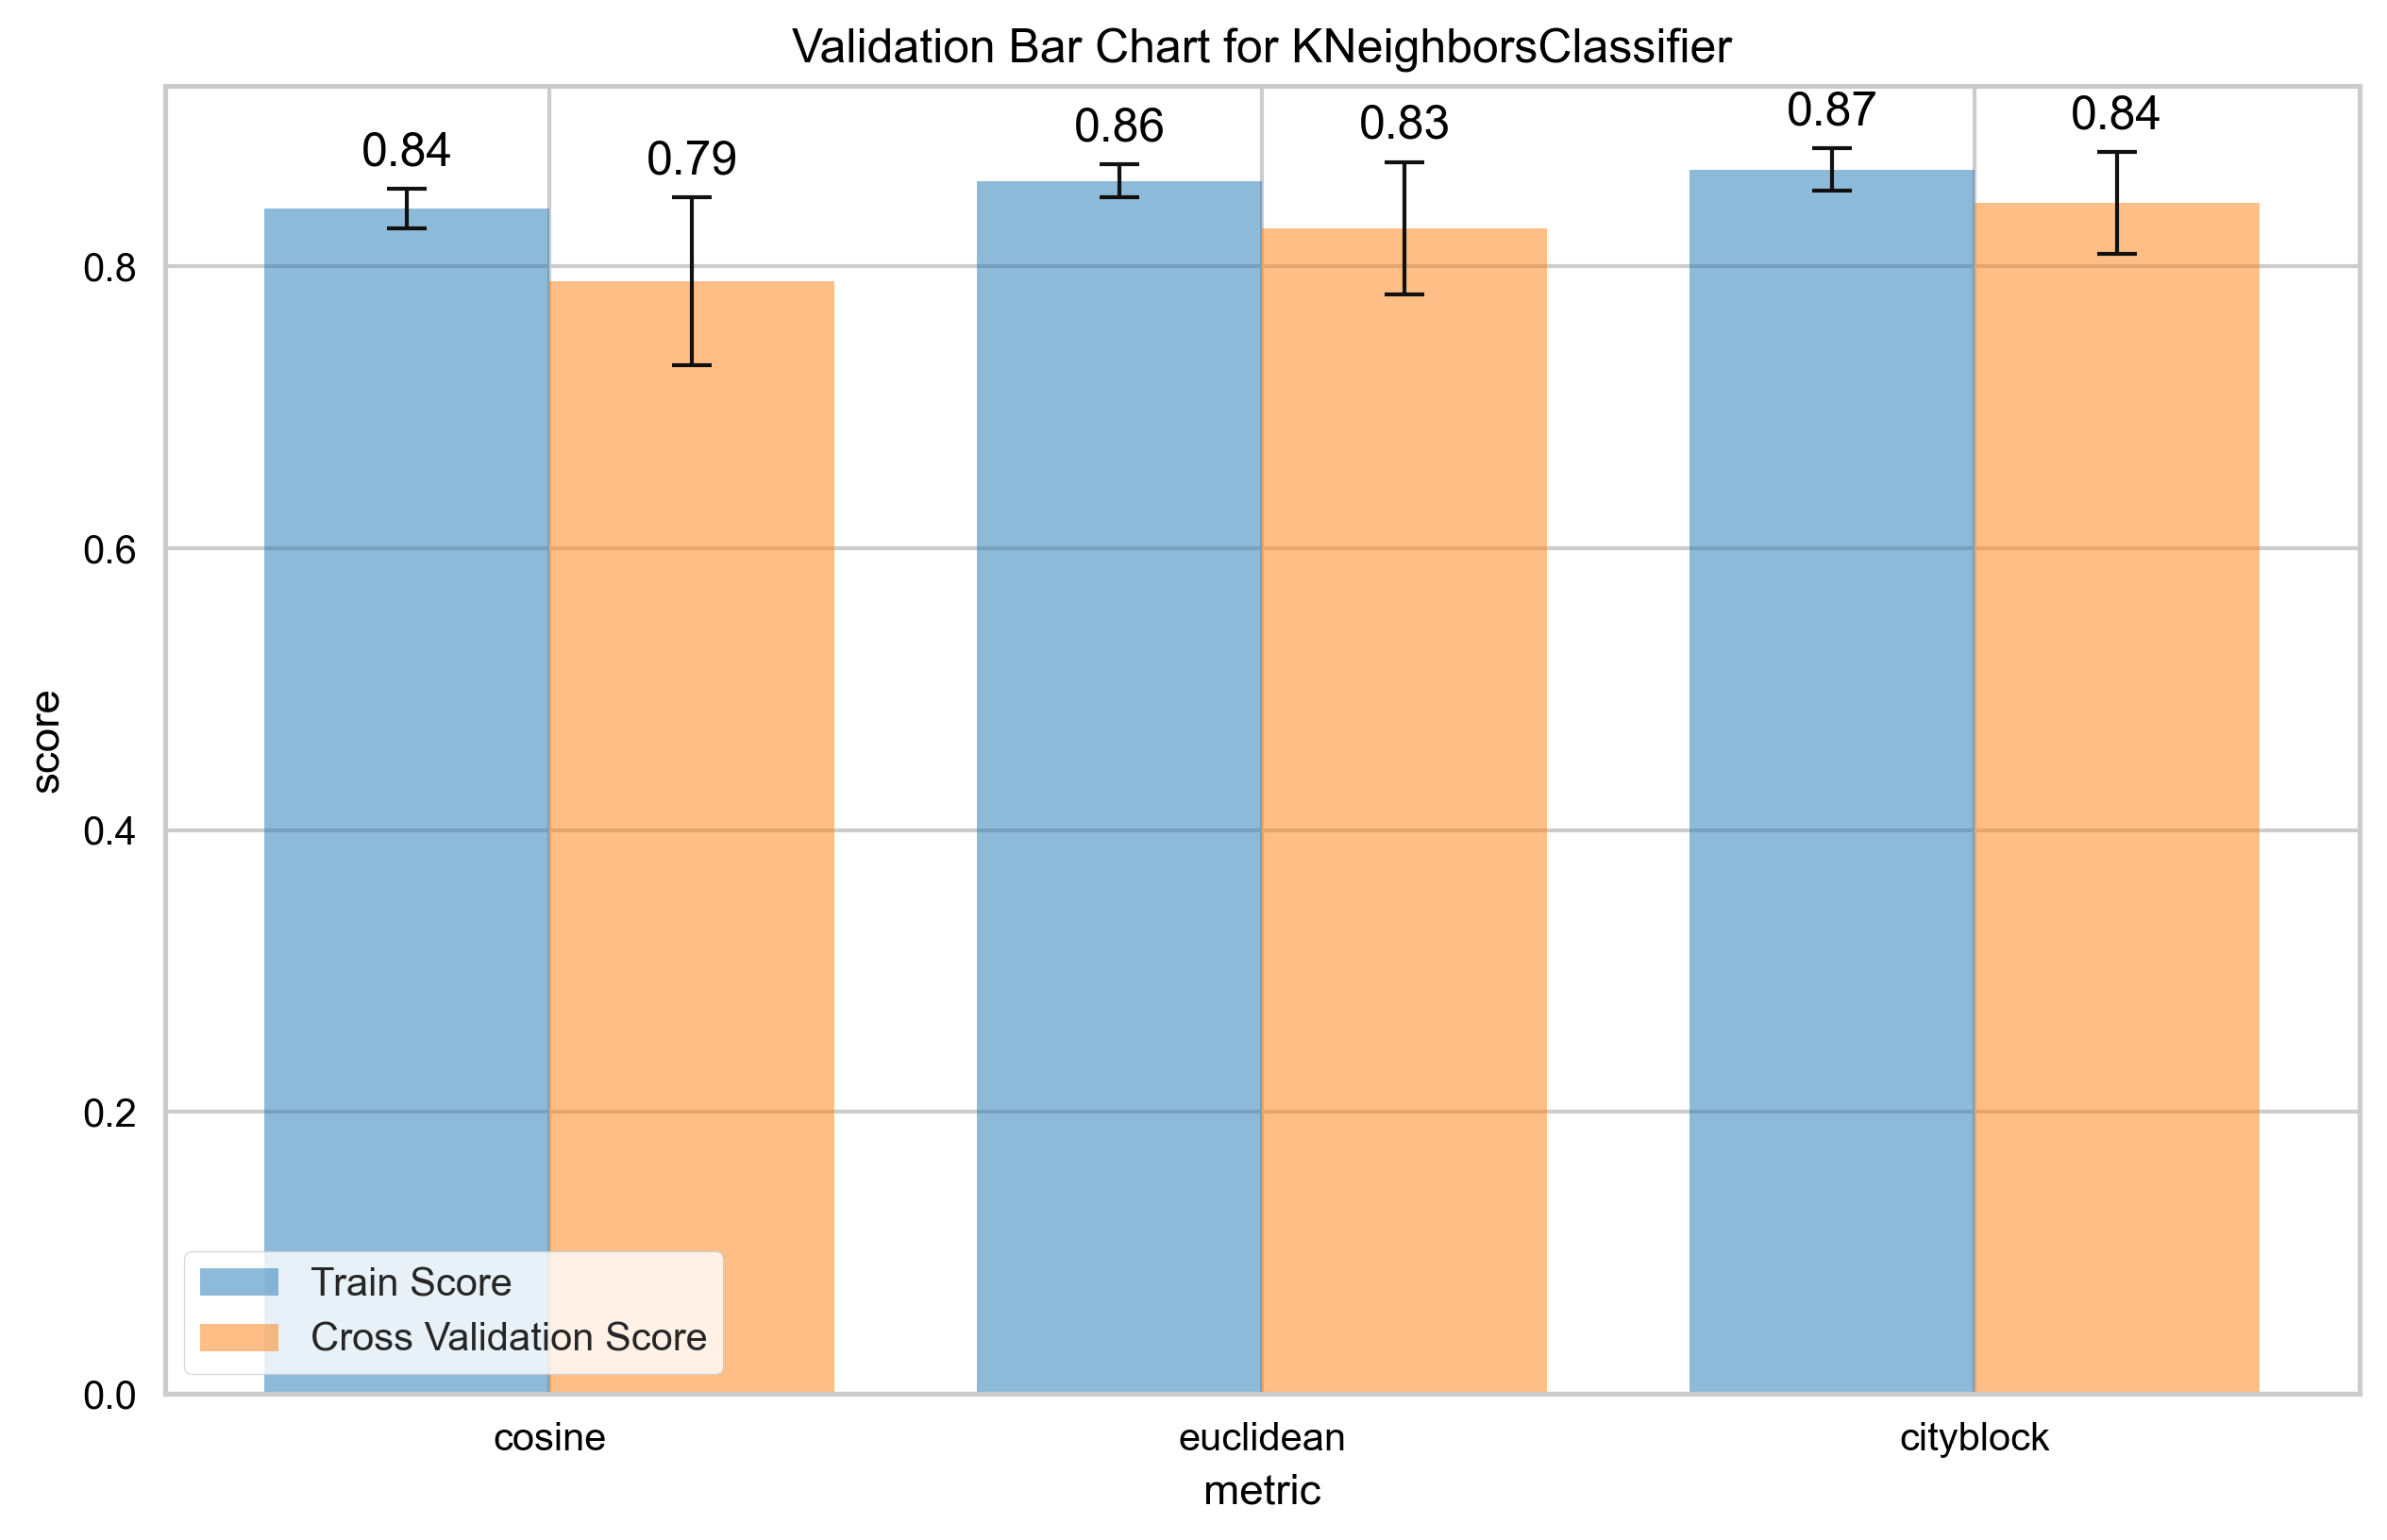

In [80]:
import importlib
#
importlib.reload(viz)

knn_clf = KNeighborsClassifier()
viz.validation_bar_chart(
    clf=knn_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="metric",
    param_range=['cosine', 'euclidean', 'cityblock'],
    output_path=f"{CREDIT_CARDS_KNN_PATH}/knn_metric.png",
    n_jobs=3,
)

In [81]:
best_knn_params = training.perform_hyperparameter_tuning(
    clf=KNeighborsClassifier(),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "n_neighbors": np.arange(1, 8, 1),
        "metric": ['cosine', 'euclidean', 'cityblock']
    },
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [82]:
best_knn_params


{'metric': 'cityblock', 'n_neighbors': 5}

In [83]:
def instantiate_best_knn_clf():
    return KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'],
                                metric=best_knn_params['metric'])

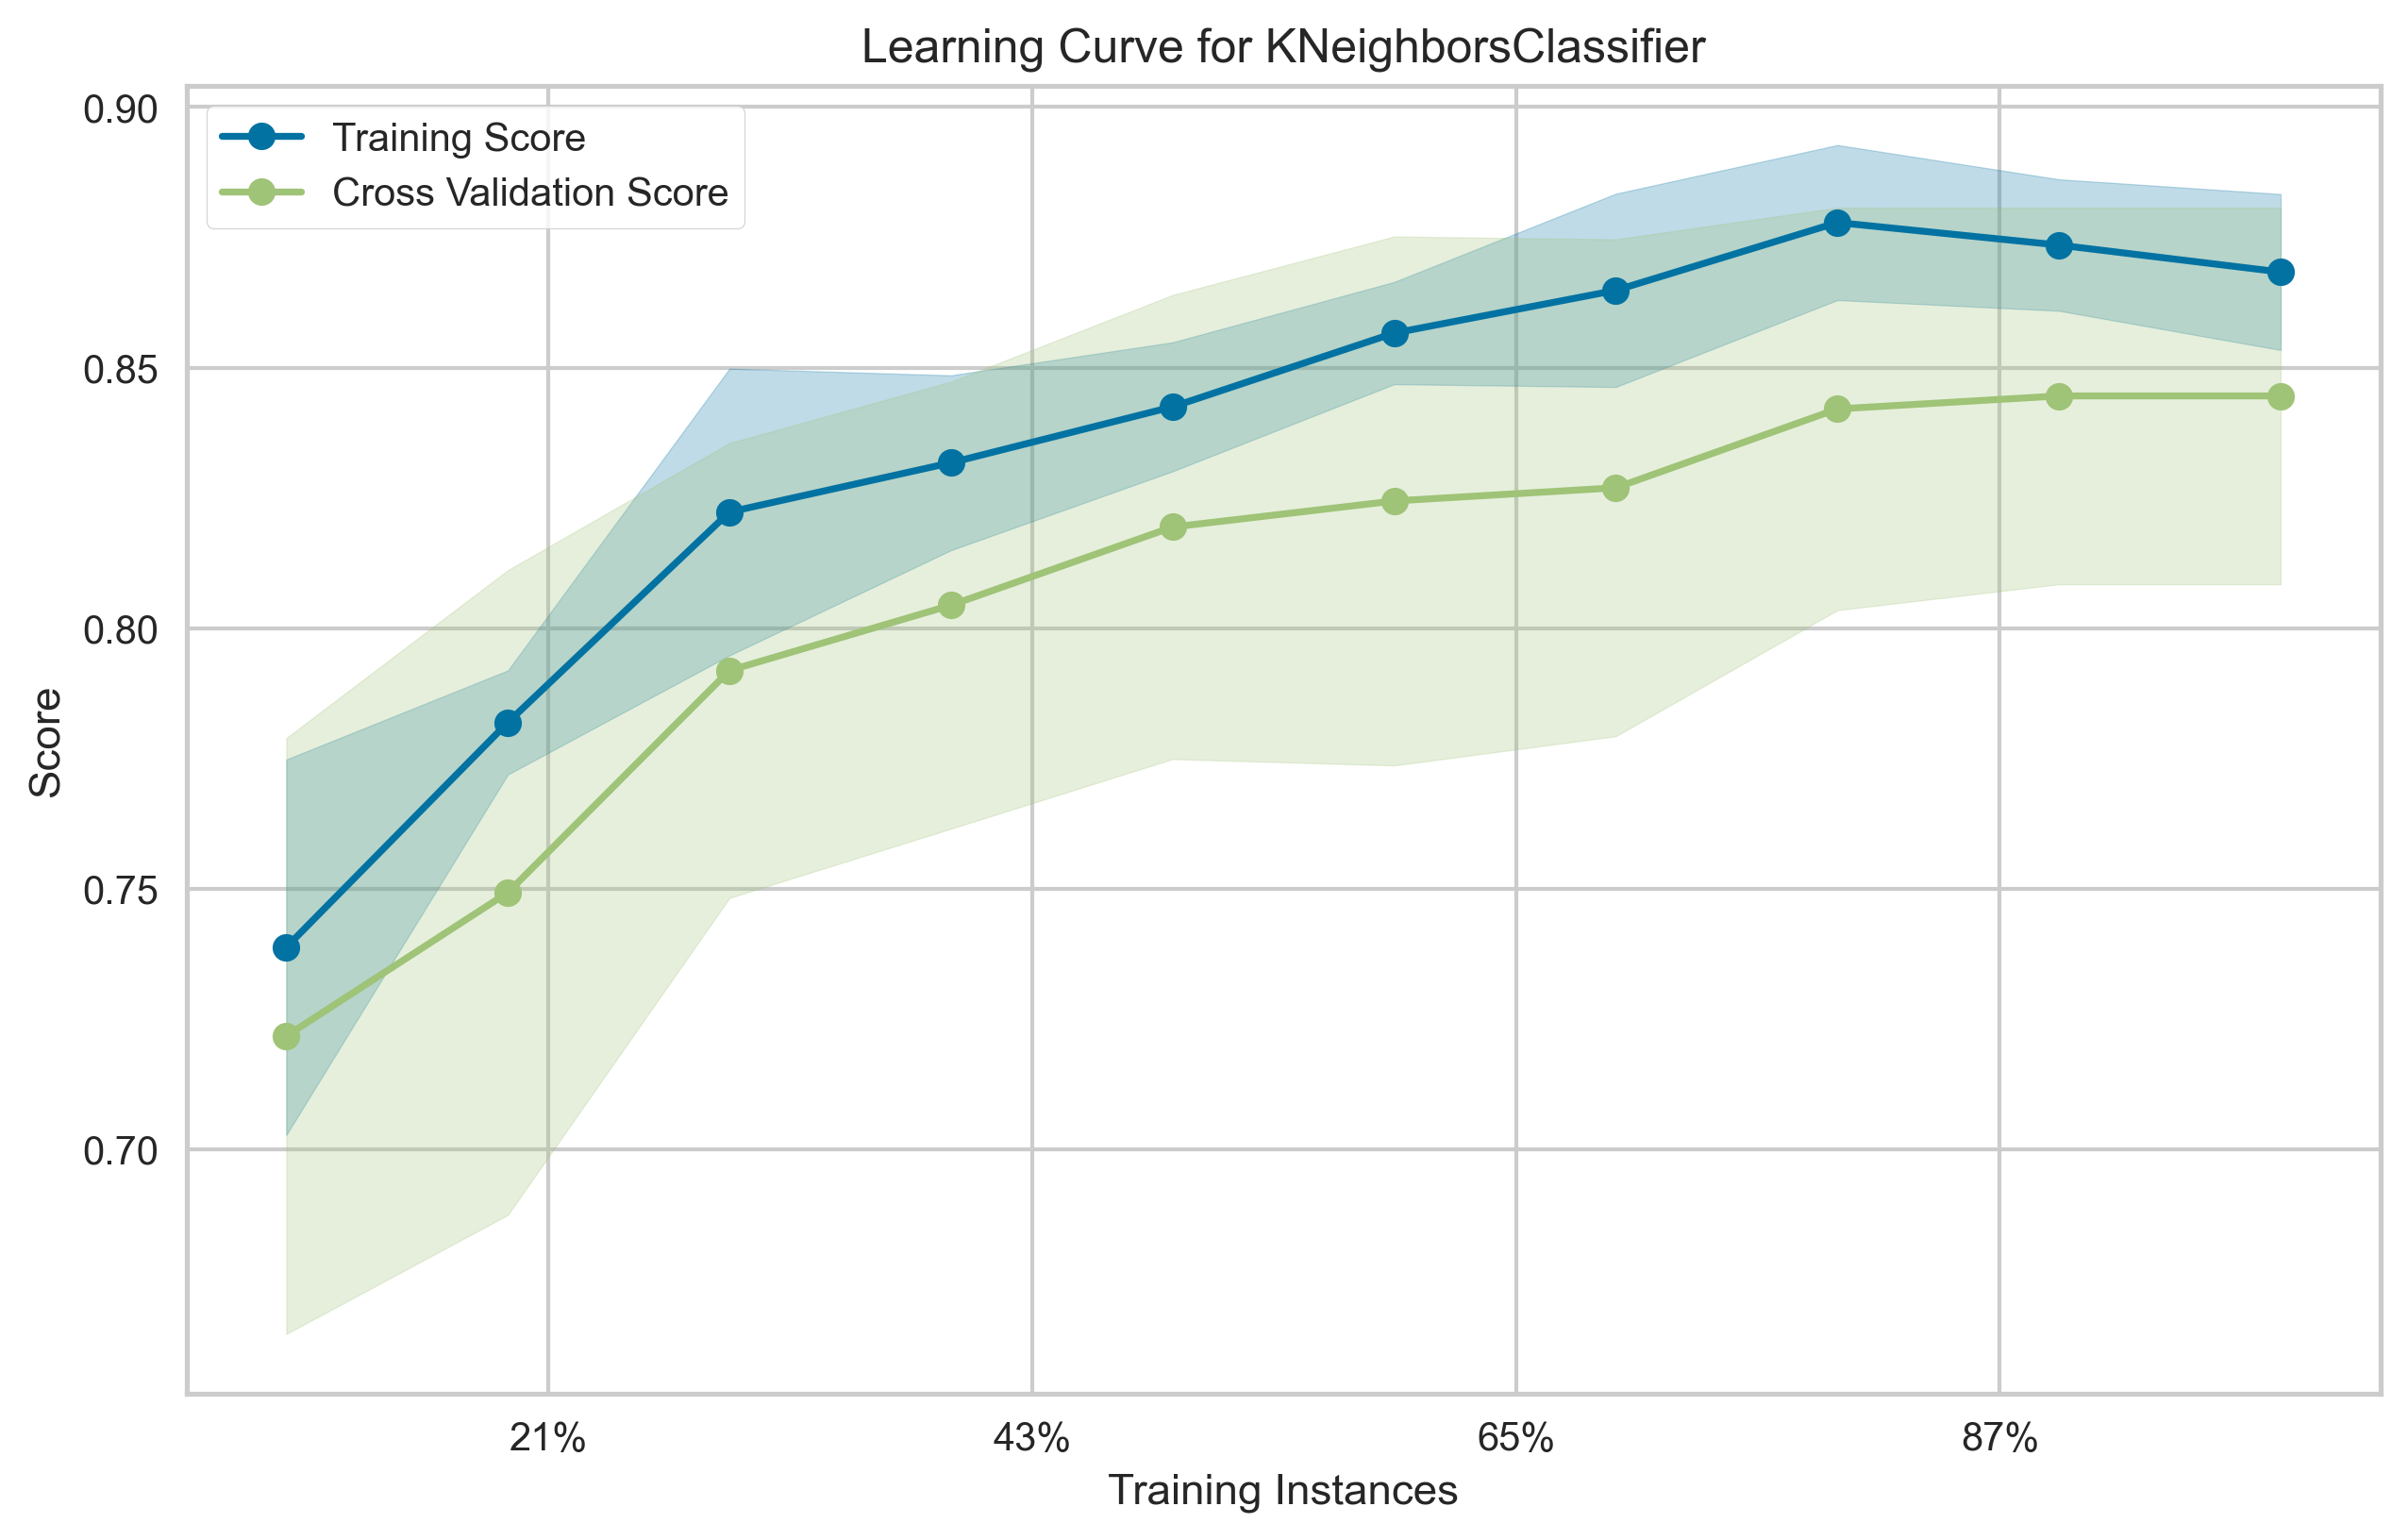

In [84]:
best_knn_clf = instantiate_best_knn_clf()
viz.learning_curve(clf=best_knn_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{CREDIT_CARDS_KNN_PATH}/knn_learning_curve.png")

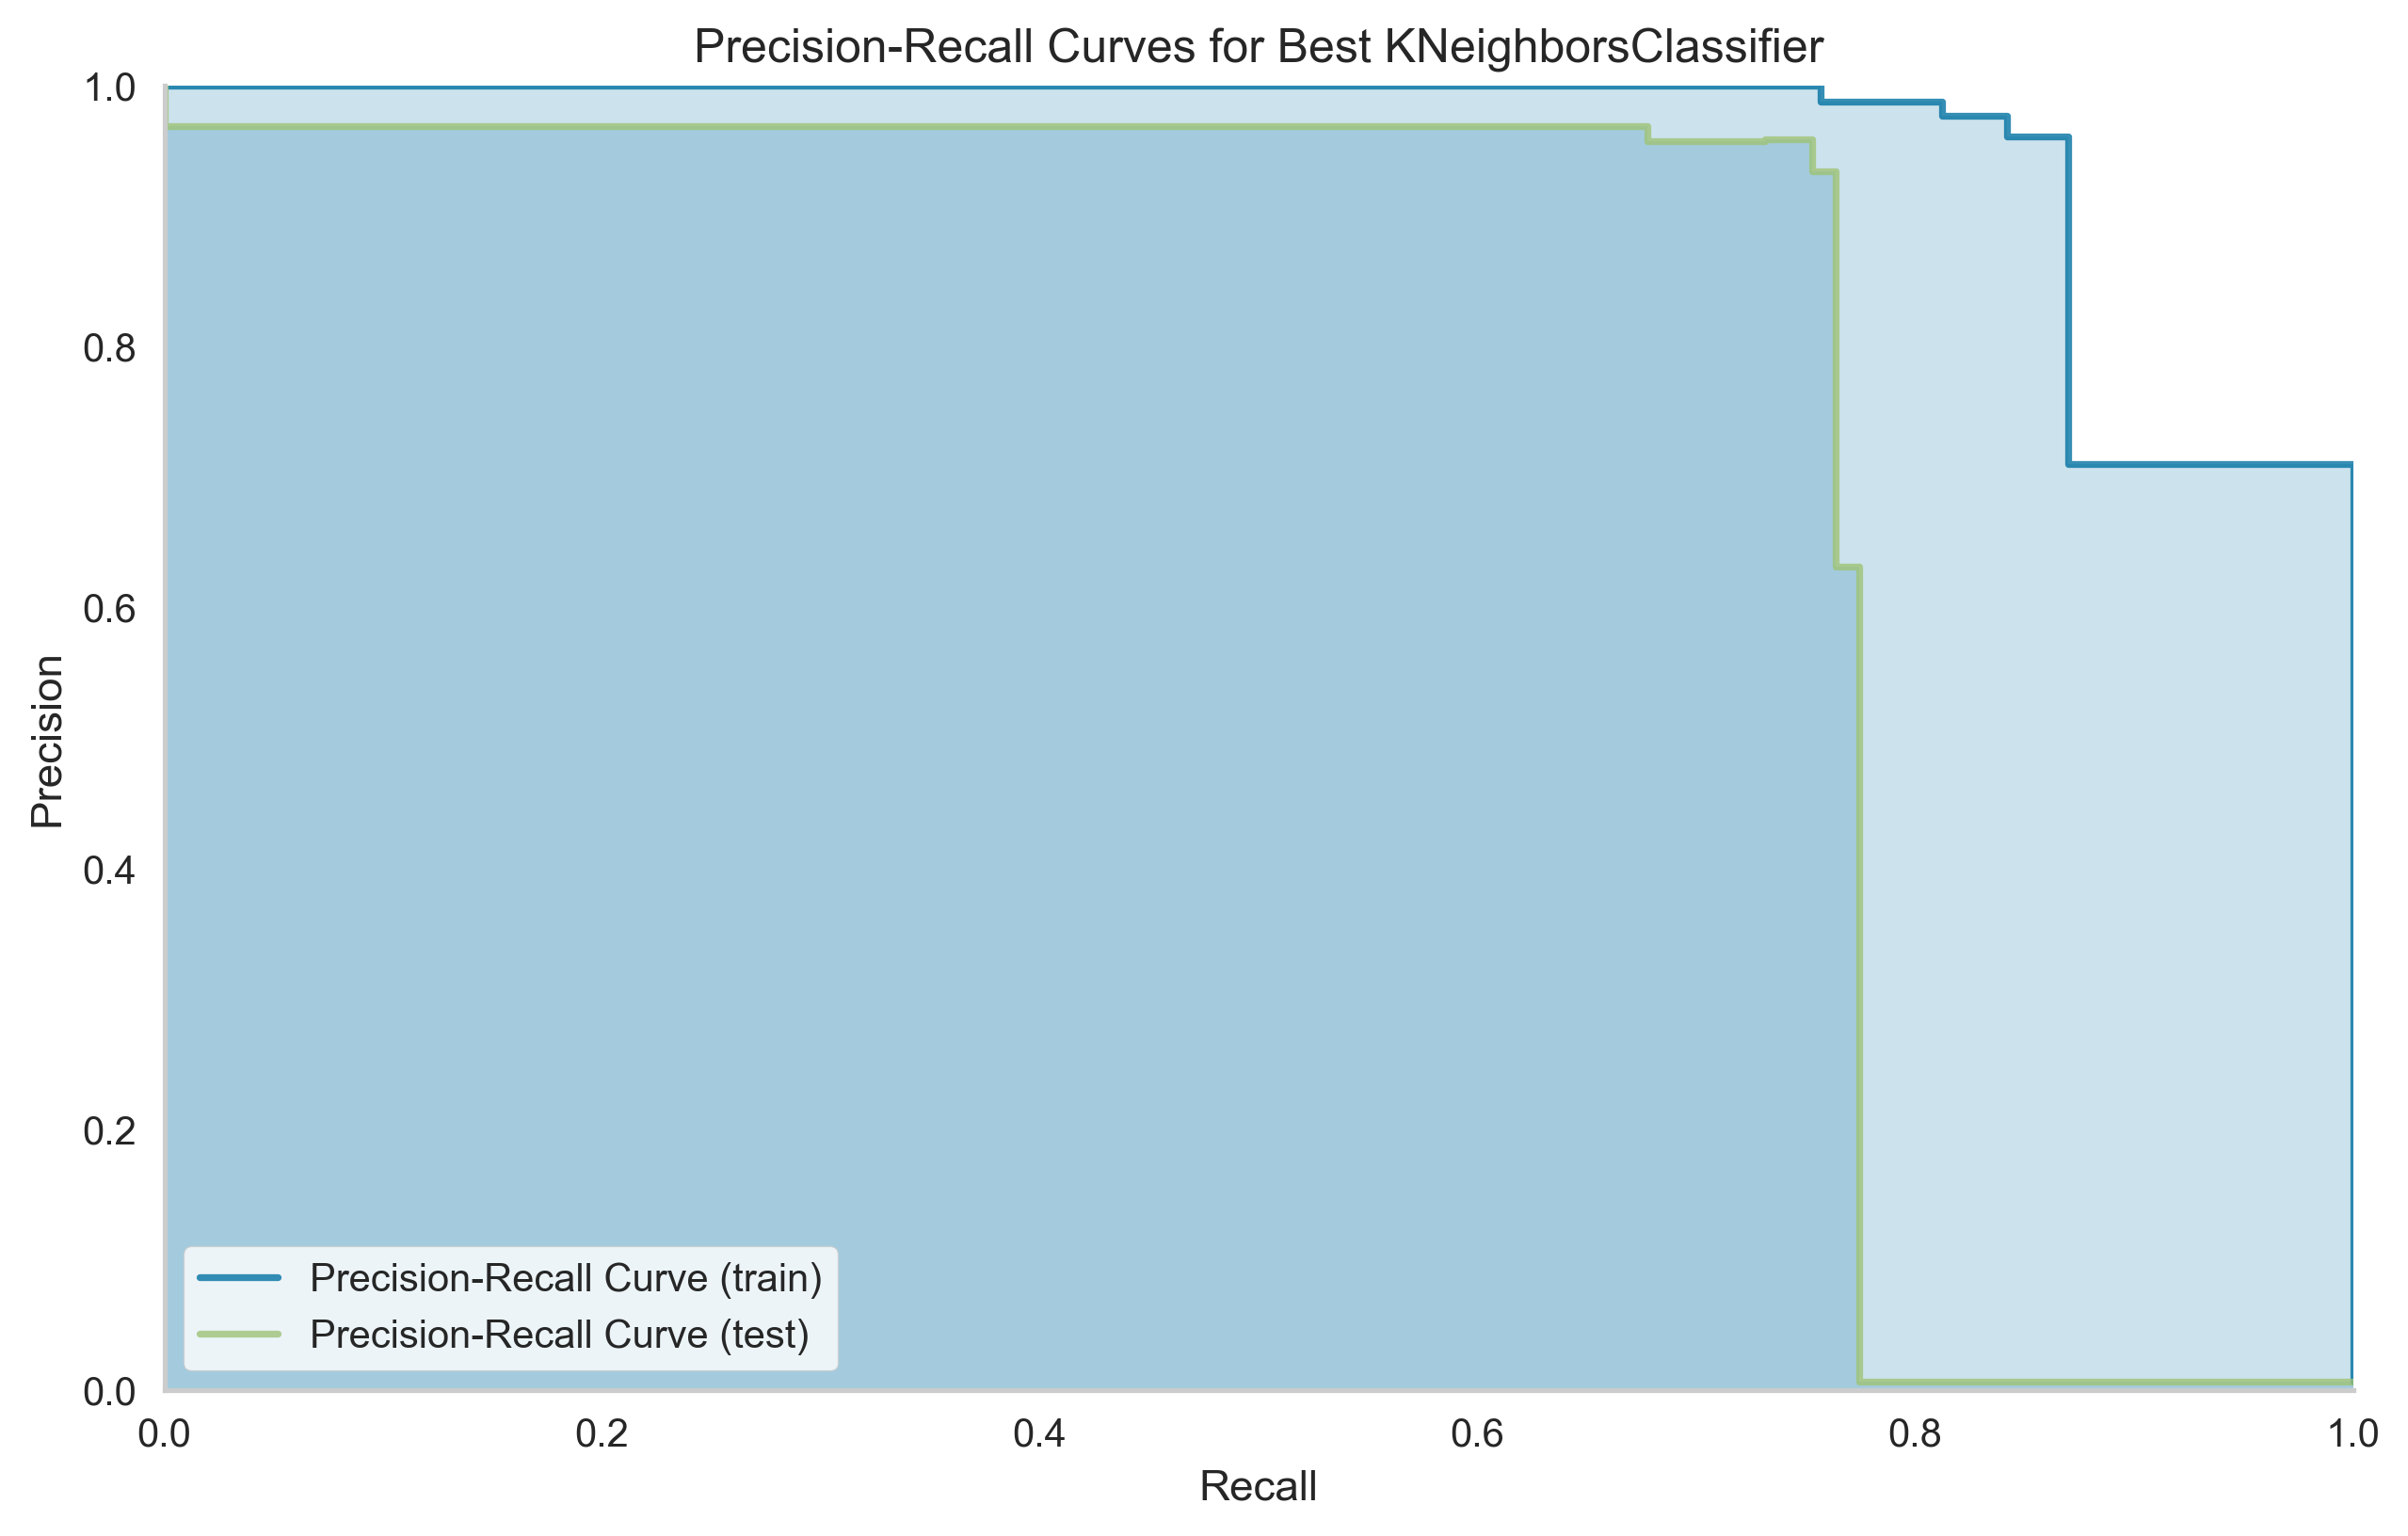

In [85]:
best_knn_clf = instantiate_best_knn_clf()
best_knn_clf.fit(X_train_n, y_train)
viz.precision_recall_curve(
    clf=best_knn_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Best KNeighborsClassifier',
    output_path=f'{CREDIT_CARDS_KNN_PATH}/best_knn_pr_curves.png'
)

In [86]:
metrics.recall_at_precision_stats(0.9,
                                  best_knn_clf,
                                  X_tr=X_train_n,
                                  y_tr=y_train,
                                  X_t=X_test_n,
                                  y_t=y_test)


Recall @ Precision 0.9 (train): 0.8697
Recall @ Precision 0.9 (test) : 0.7634


In [87]:
best_knn_clf = instantiate_best_knn_clf()
training.learning_time_stats(best_knn_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 0.0034 seconds
Training time, normalized (per 1000 samples): 0.0001 seconds


In [88]:
training.inference_time_stats(best_knn_clf, X_train_n, dataset_name='train')
training.inference_time_stats(best_knn_clf, X_test_n, dataset_name='test')
training.inference_time_stats(best_knn_clf, X_n, dataset_name='all')

Inference time (train), total: 8.2721 seconds
Inference time (train), normalized (per 1000 samples): 0.1445 seconds
Inference time (test), total: 2.2354 seconds
Inference time (test), normalized (per 1000 samples): 0.1562 seconds
Inference time (all), total: 10.4463 seconds
Inference time (all), normalized (per 1000 samples): 0.1460 seconds


# SVM

## Plan
1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `kernel`
    b. `C`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [89]:
CREDIT_CARDS_SVM_PATH = f'{CREDIT_CARDS_PATH}/svm'


In [90]:
svc_baseline_clf = SVC(random_state=SEED, probability=True)
svc_baseline_clf.fit(X_train_n, y_train)

SVC(probability=True, random_state=42)

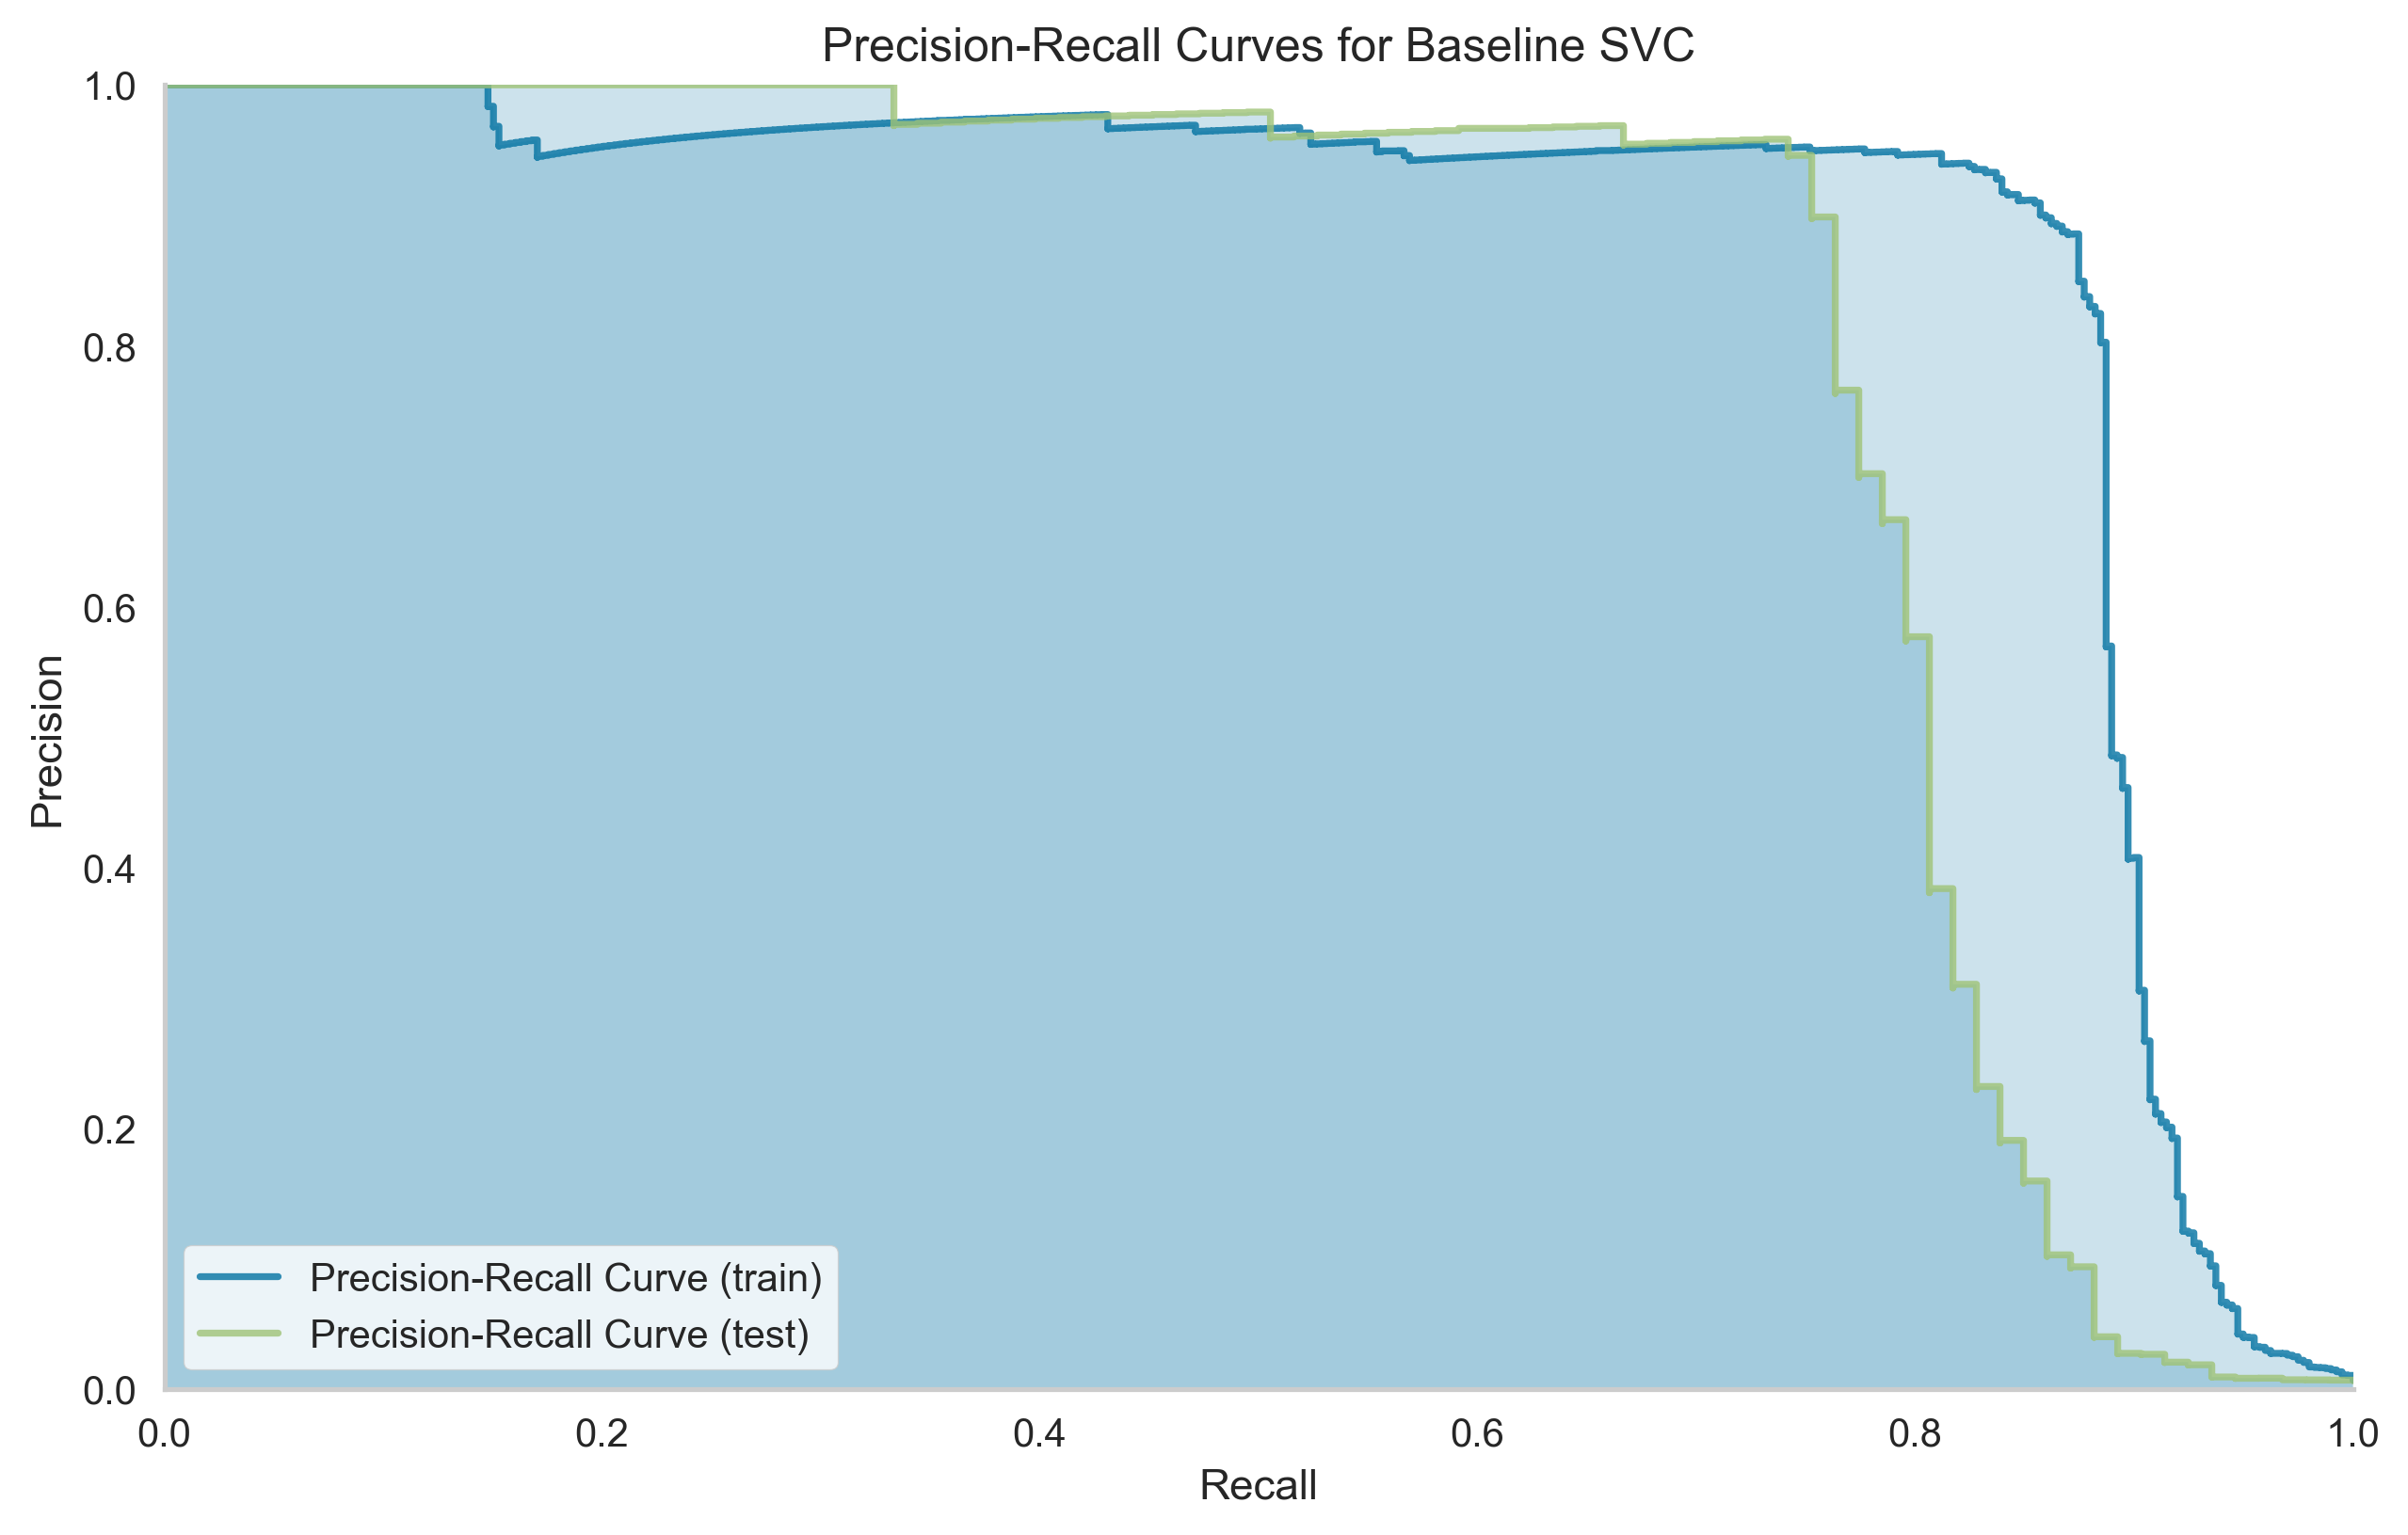

In [91]:
viz.precision_recall_curve(
    clf=svc_baseline_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Baseline SVC',
    output_path=f'{CREDIT_CARDS_SVM_PATH}/baseline_svc_pr_curves.png', )

In [92]:
metrics.recall_at_precision_stats(
    0.9,
    svc_baseline_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
)

Recall @ Precision 0.9 (train): 0.8596
Recall @ Precision 0.9 (test) : 0.7527


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


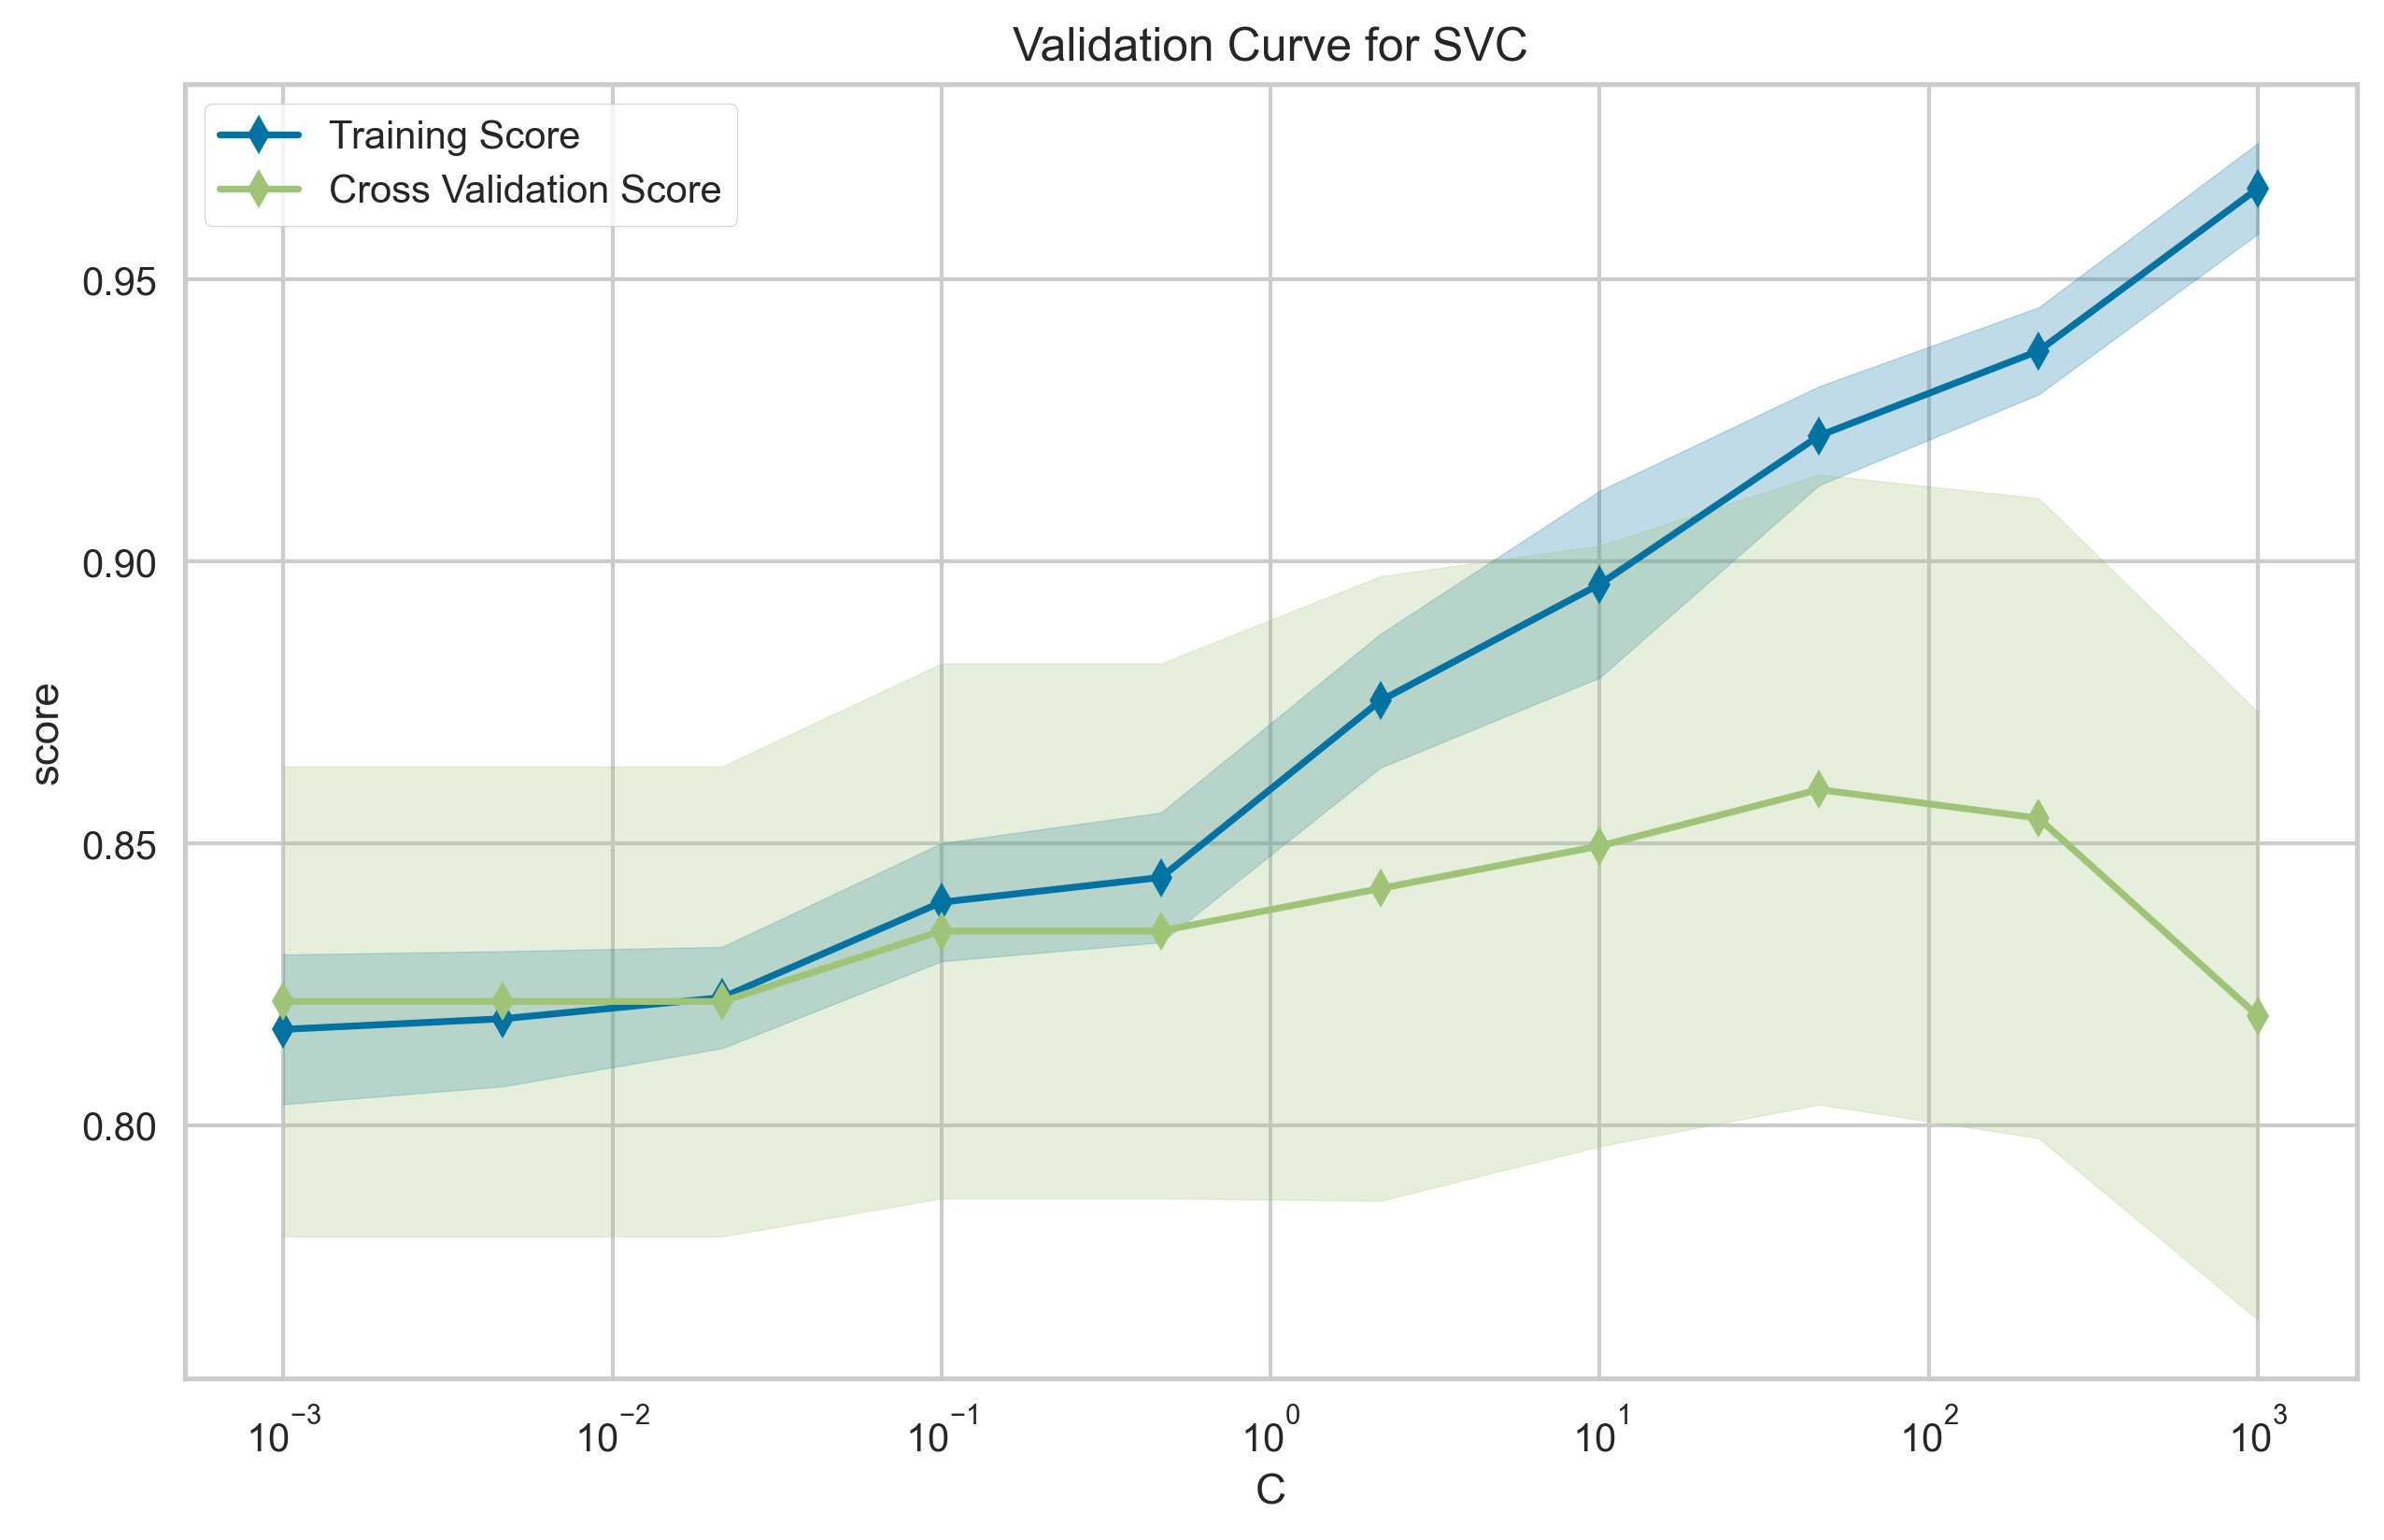

In [93]:
svc_clf = SVC(random_state=SEED, probability=True)
viz.validation_curve(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="C",
    param_range=np.logspace(-3, 3, 10),
    output_path=f"{CREDIT_CARDS_SVM_PATH}/svm_c.png",
    logx=True,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


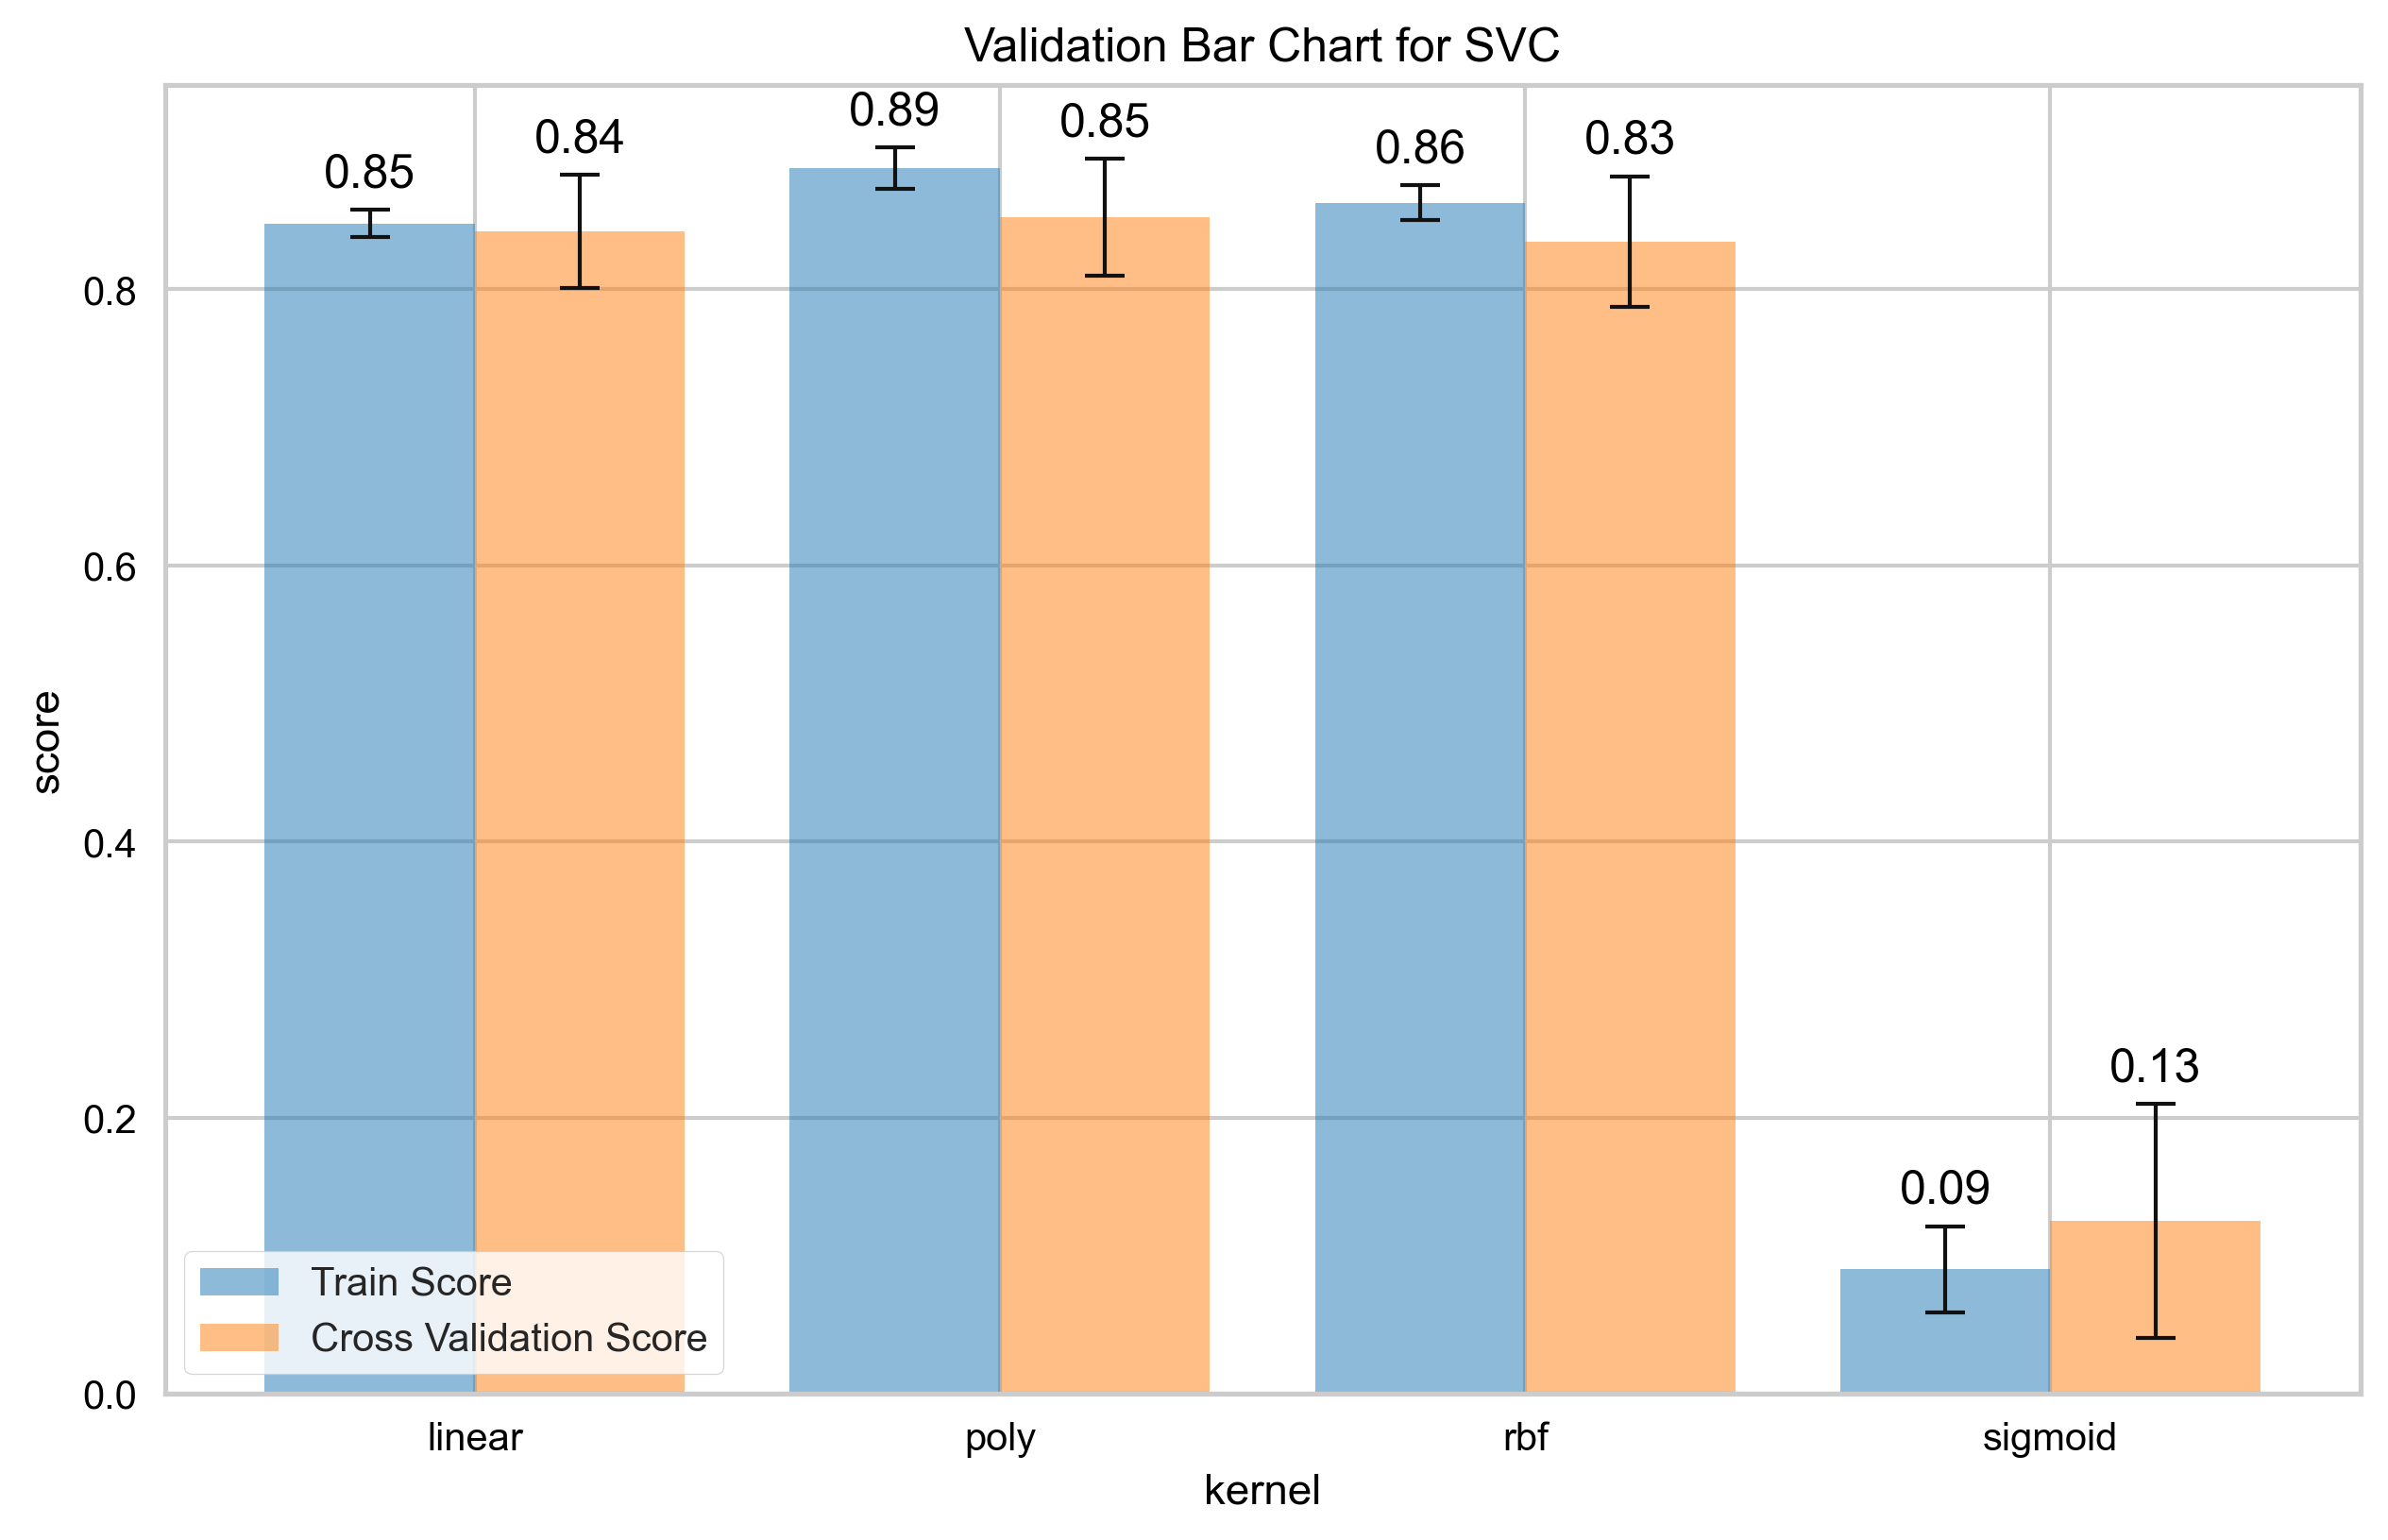

In [94]:
svc_clf = SVC(random_state=SEED, probability=True)
viz.validation_bar_chart(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="kernel",
    param_range=['linear', 'poly', 'rbf', 'sigmoid'],
    output_path=f"{CREDIT_CARDS_SVM_PATH}/svm_kernel.png",
    n_jobs=3,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


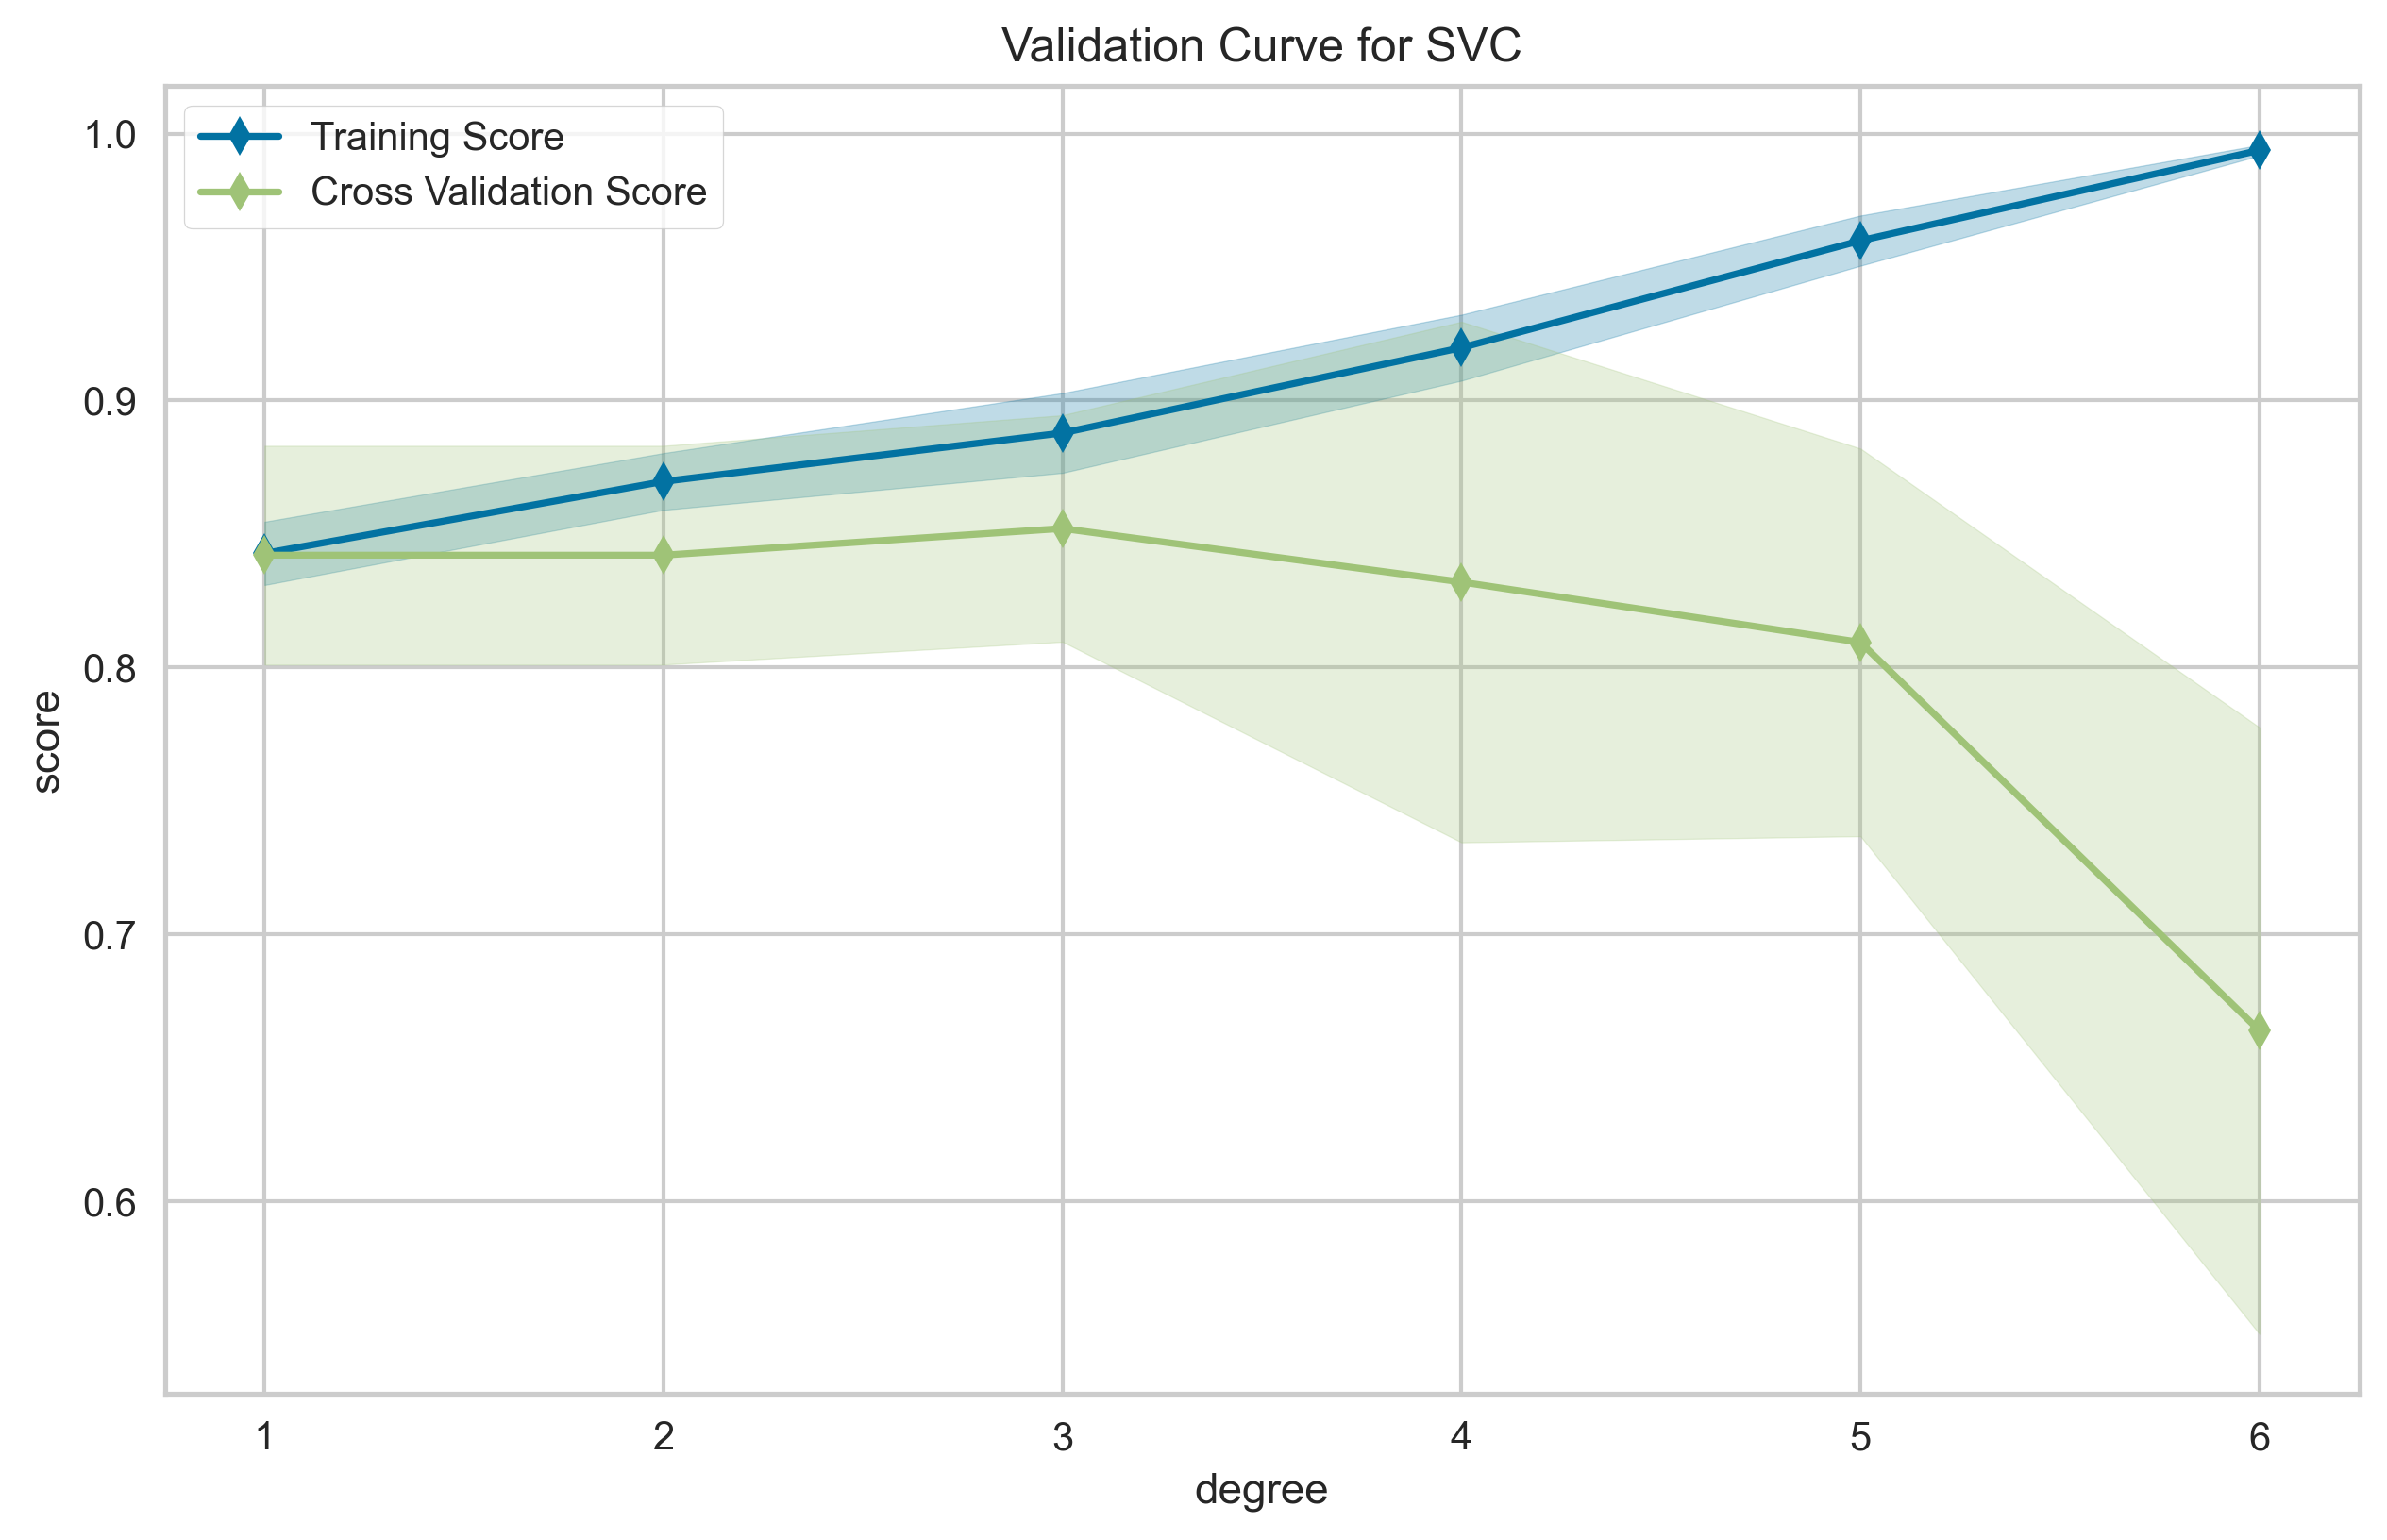

In [95]:
svc_clf = SVC(random_state=SEED, probability=True, kernel='poly')
viz.validation_curve(
    clf=svc_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="degree",
    param_range=np.arange(1, 7, 1),
    output_path=f"{CREDIT_CARDS_SVM_PATH}/svm_poly_degree.png",
)

In [96]:
best_svm_params = training.perform_hyperparameter_tuning(
    clf=SVC(random_state=SEED, probability=True),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "C": np.concatenate((np.logspace(-1.5, 1.5, 12), np.logspace(1, 2, 8))),
        "kernel": ['linear', 'poly', 'rbf'],
    },
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [97]:
best_svm_params

{'C': 71.96856730011521, 'kernel': 'rbf'}

In [98]:
def instantiate_best_svm_clf():
    return SVC(random_state=SEED, probability=True, C=best_svm_params['C'],
               kernel=best_svm_params['kernel'])

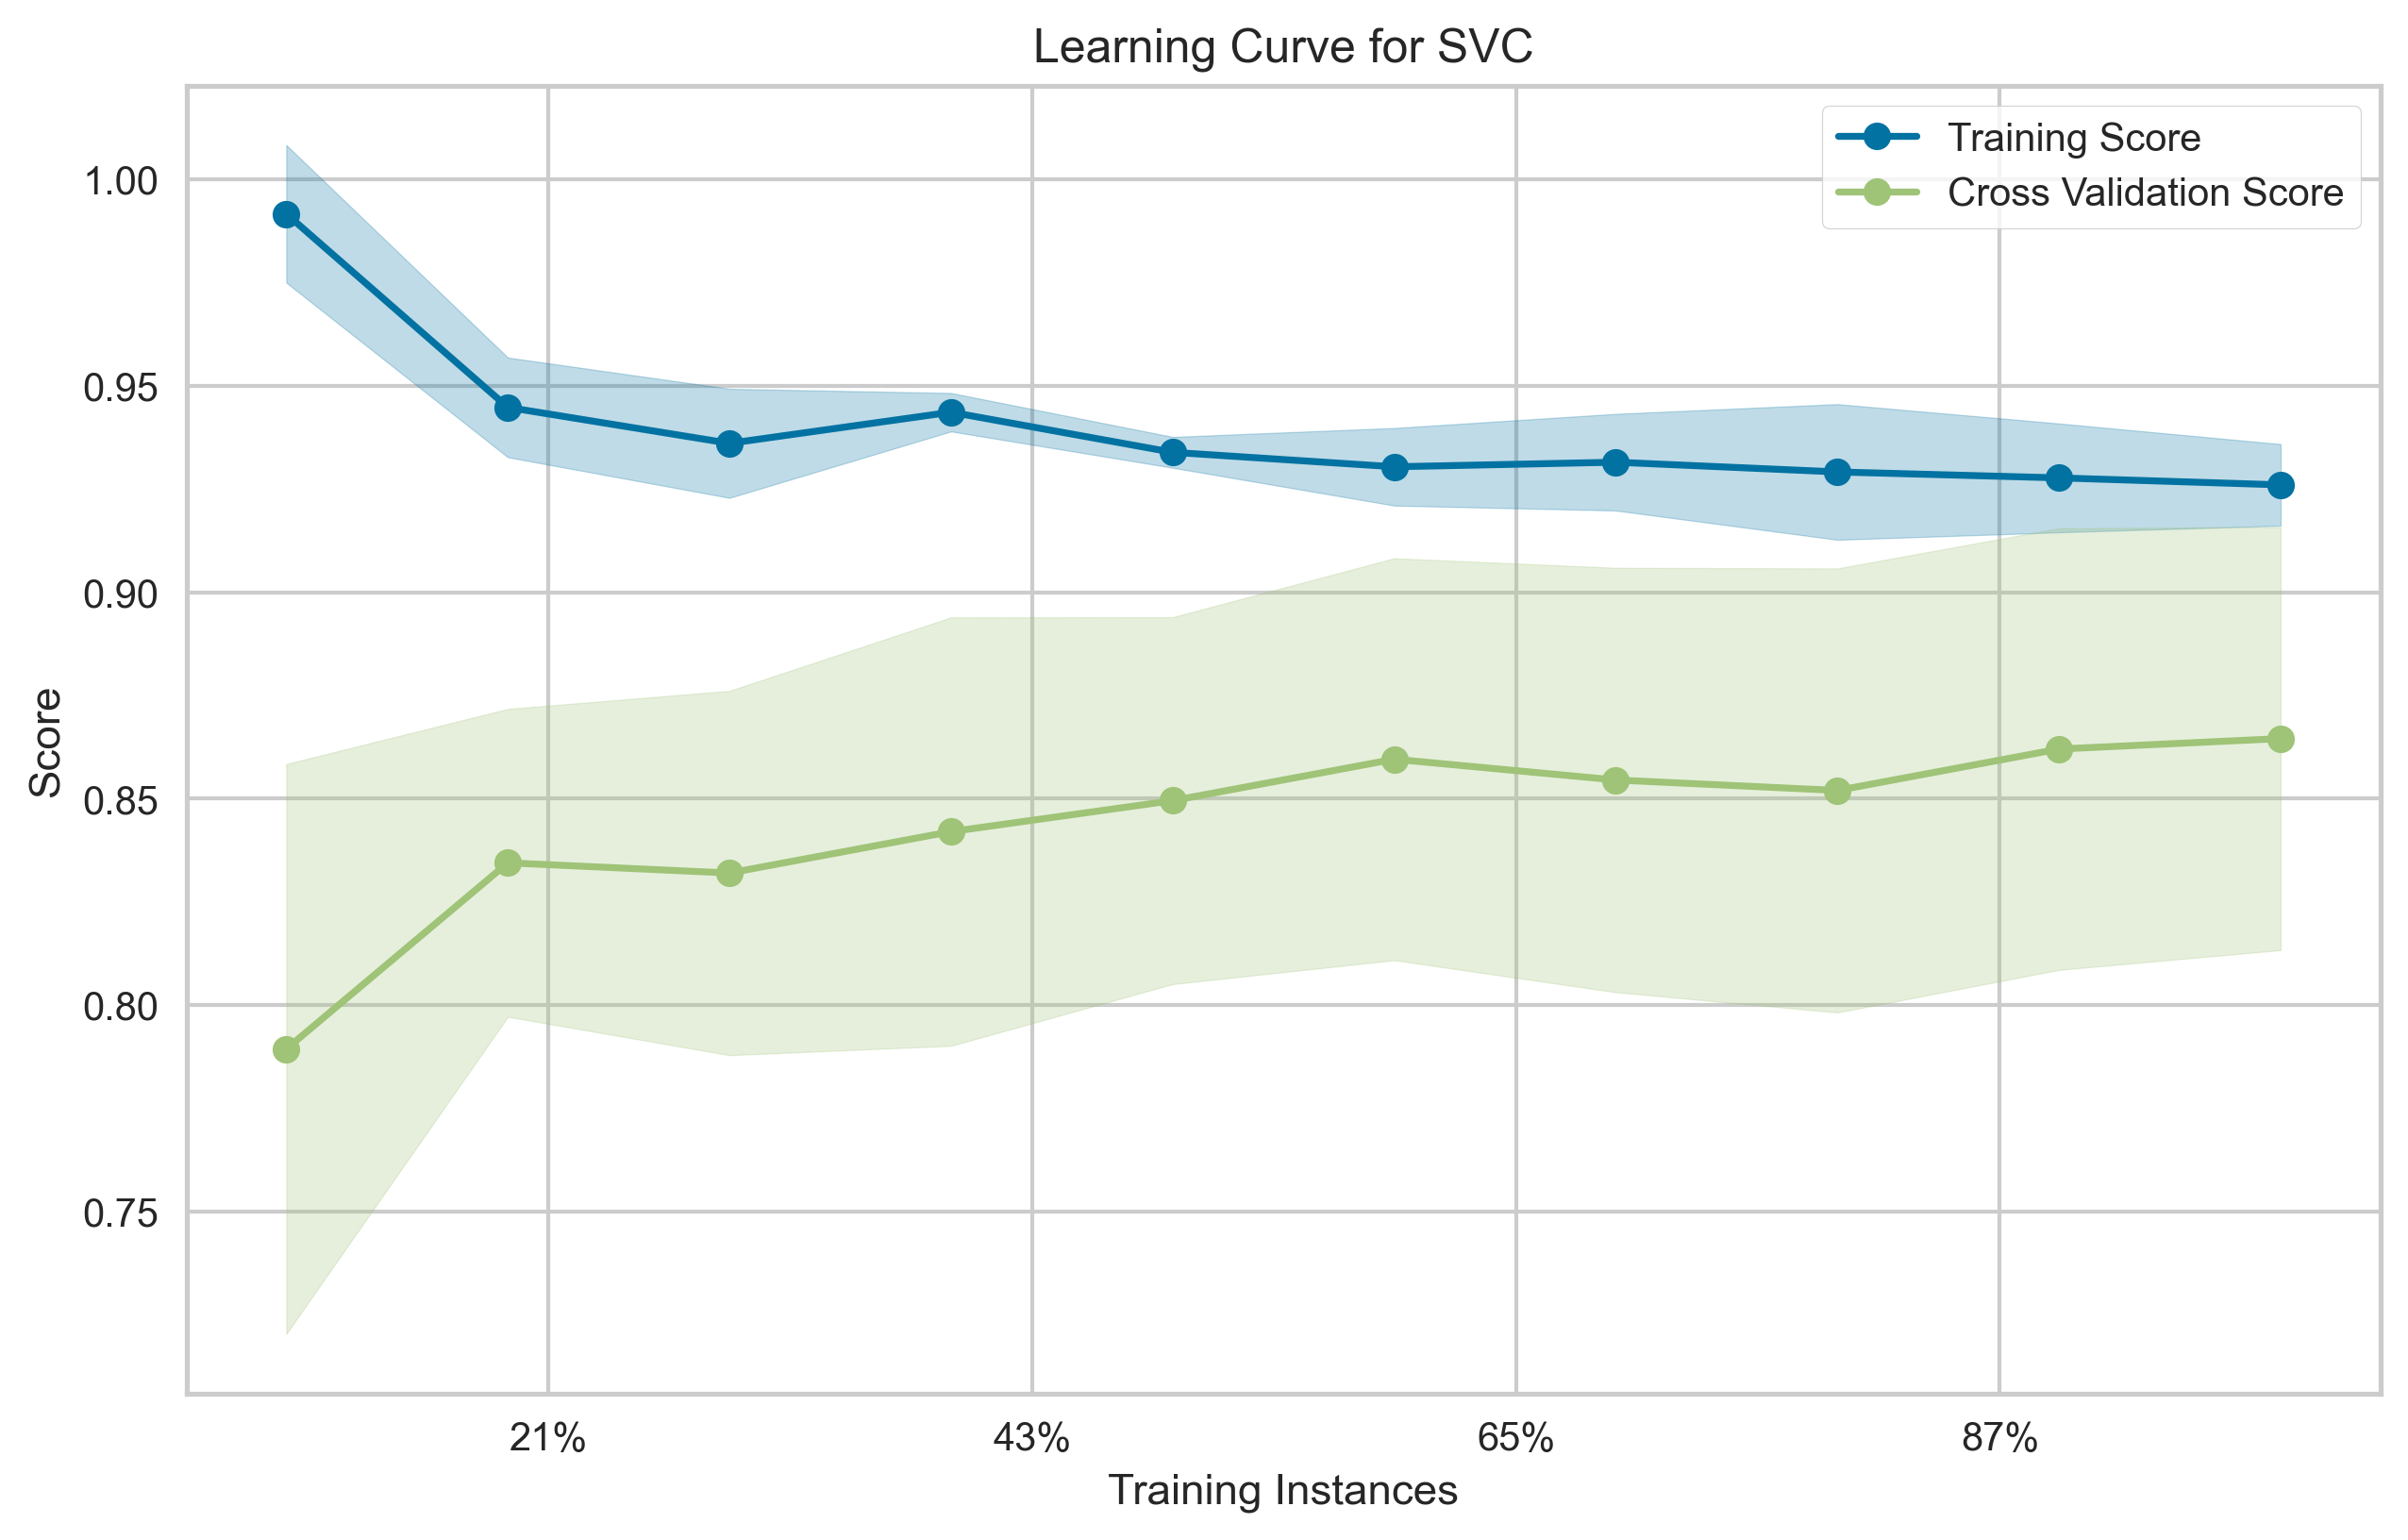

In [99]:
best_svm_clf = instantiate_best_svm_clf()
viz.learning_curve(clf=best_svm_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{CREDIT_CARDS_SVM_PATH}/svm_learning_curve.png")

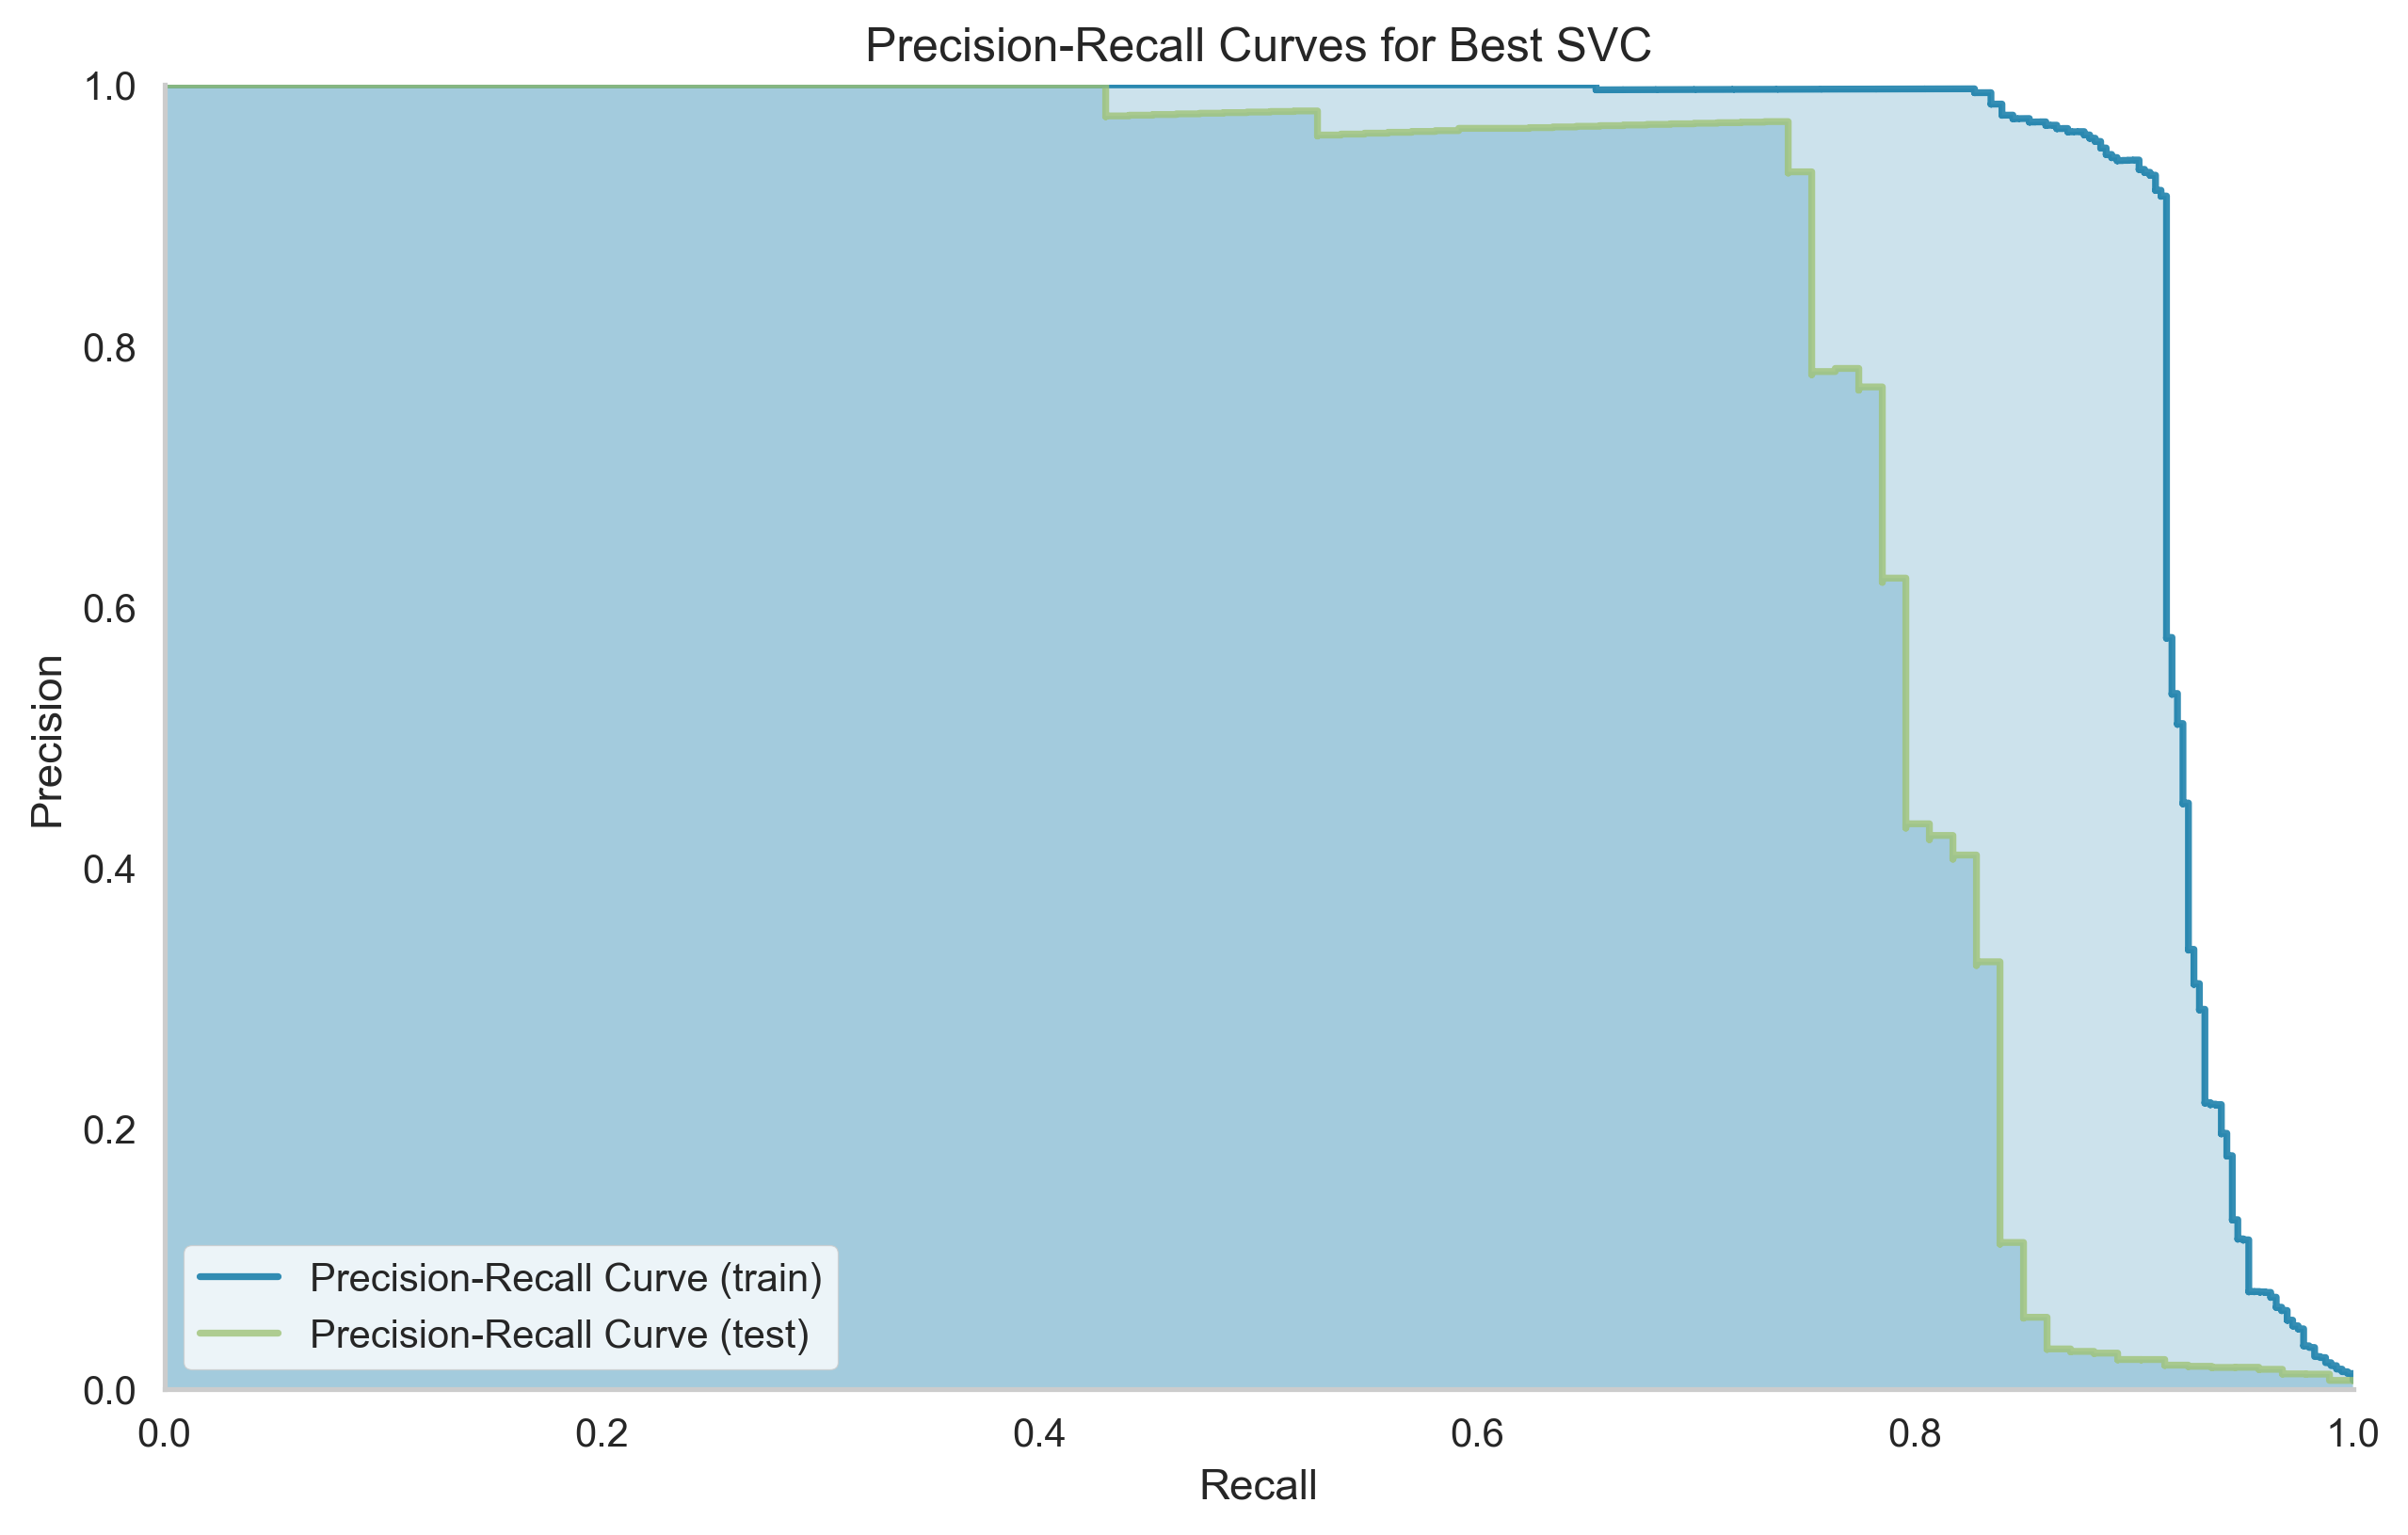

In [100]:
best_svm_clf = instantiate_best_svm_clf()
best_svm_clf.fit(X_train_n, y_train)
viz.precision_recall_curve(
    clf=best_svm_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Best SVC',
    output_path=f'{CREDIT_CARDS_SVM_PATH}/best_svc_pr_curves.png'
)

In [101]:
metrics.recall_at_precision_stats(0.9,
                                  best_svm_clf,
                                  X_tr=X_train_n,
                                  y_tr=y_train,
                                  X_t=X_test_n,
                                  y_t=y_test)


Recall @ Precision 0.9 (train): 0.9148
Recall @ Precision 0.9 (test) : 0.7527


In [102]:
best_svm_clf = instantiate_best_svm_clf()
training.learning_time_stats(best_svm_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 14.1791 seconds
Training time, normalized (per 1000 samples): 0.2476 seconds


In [103]:
training.inference_time_stats(best_svm_clf, X_train_n, dataset_name='train')
training.inference_time_stats(best_svm_clf, X_test_n, dataset_name='test')
training.inference_time_stats(best_svm_clf, X_n, dataset_name='all')

Inference time (train), total: 2.2159 seconds
Inference time (train), normalized (per 1000 samples): 0.0387 seconds
Inference time (test), total: 0.5562 seconds
Inference time (test), normalized (per 1000 samples): 0.0389 seconds
Inference time (all), total: 2.7670 seconds
Inference time (all), normalized (per 1000 samples): 0.0387 seconds


# Neural Network

### Plan

1. Train baseline boosting without hyperparameter tuning, look at the precision/recall at train and test sets
2. Validate how different individual hyperparameters affect performance of the model wrt recall@precision
    a. `Hidden Layer Size (width & depth)`
    b. `TODO`
3. Perform hyperparameter tuning of multiple parameters
4. Analyse performance of the best decision tree with hyperparameter tuning

In [6]:
CREDIT_CARDS_MLP_PATH = f'{CREDIT_CARDS_PATH}/mlp'

In [7]:
baseline_mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
baseline_mlp_clf.fit(X_train_n, y_train)

MLPClassifier(hidden_layer_sizes=[30], max_iter=400, random_state=42)

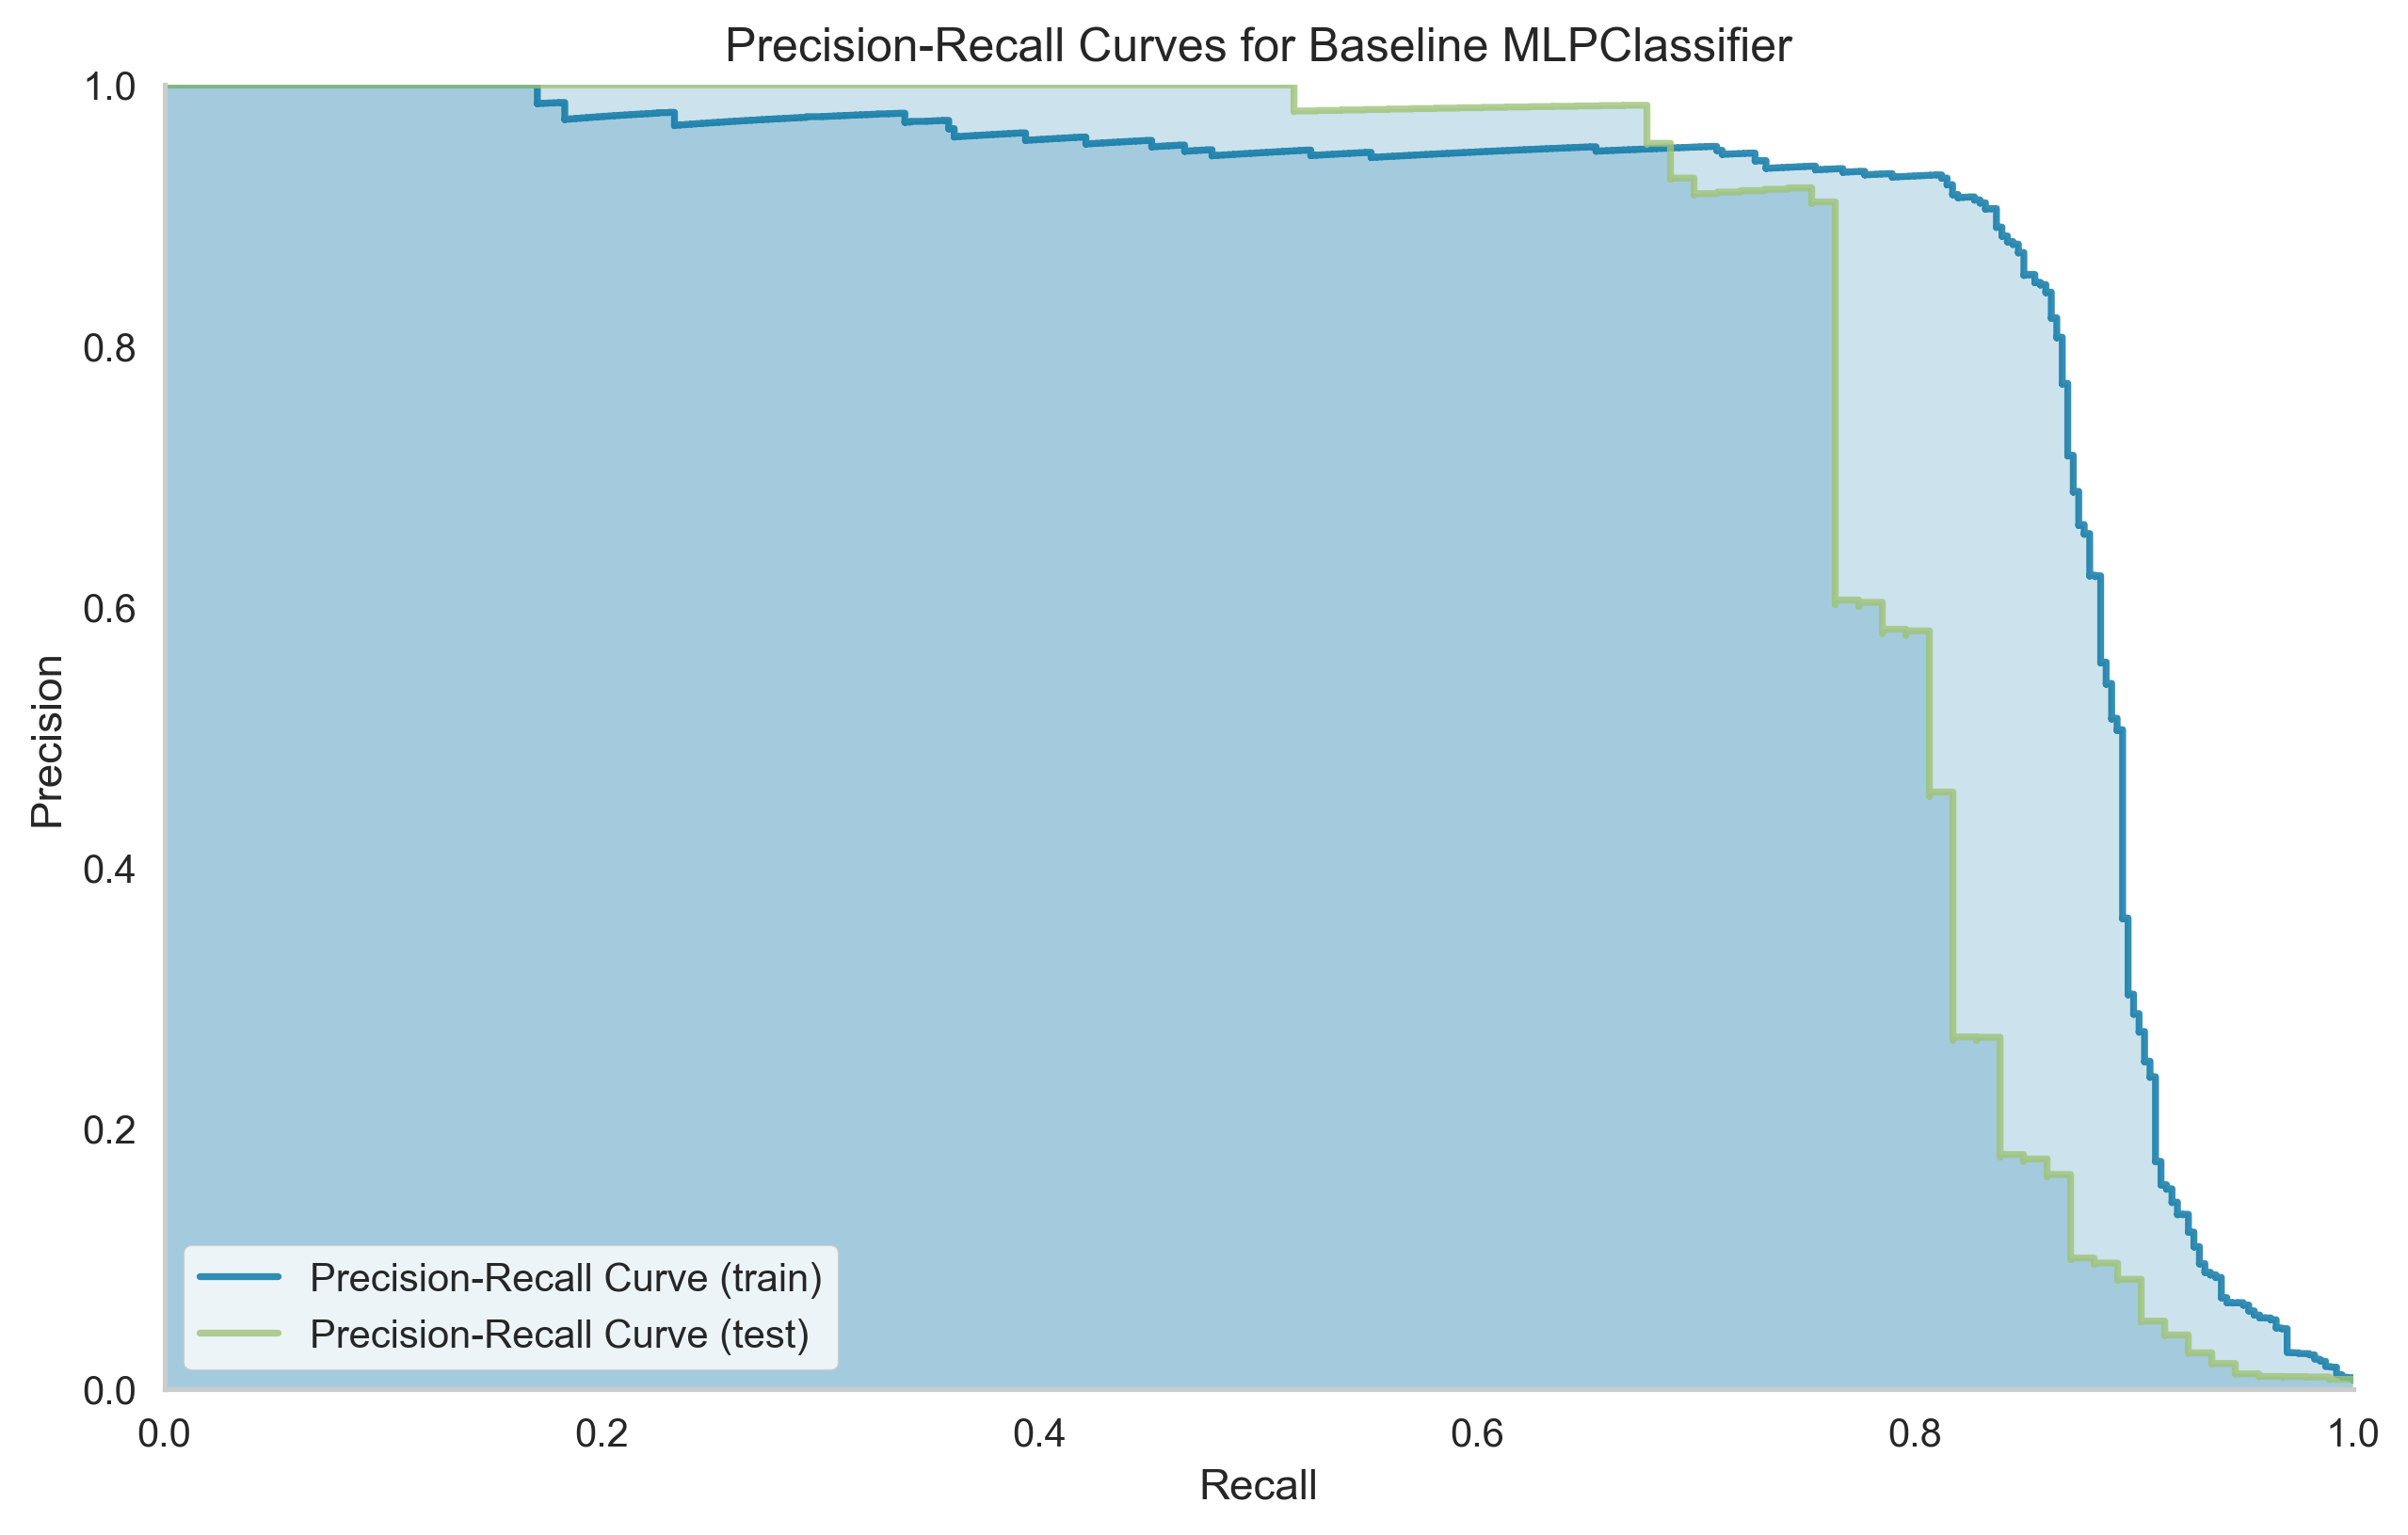

In [8]:
viz.precision_recall_curve(
    clf=baseline_mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Baseline MLPClassifier',
    output_path=f'{CREDIT_CARDS_MLP_PATH}/baseline_mlp_pr_curves.png')

In [9]:
metrics.recall_at_precision_stats(0.9,
                                  baseline_mlp_clf,
                                  X_tr=X_train_n,
                                  y_tr=y_train,
                                  X_t=X_test_n,
                                  y_t=y_test)


Recall @ Precision 0.9 (train): 0.8371
Recall @ Precision 0.9 (test) : 0.7634


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


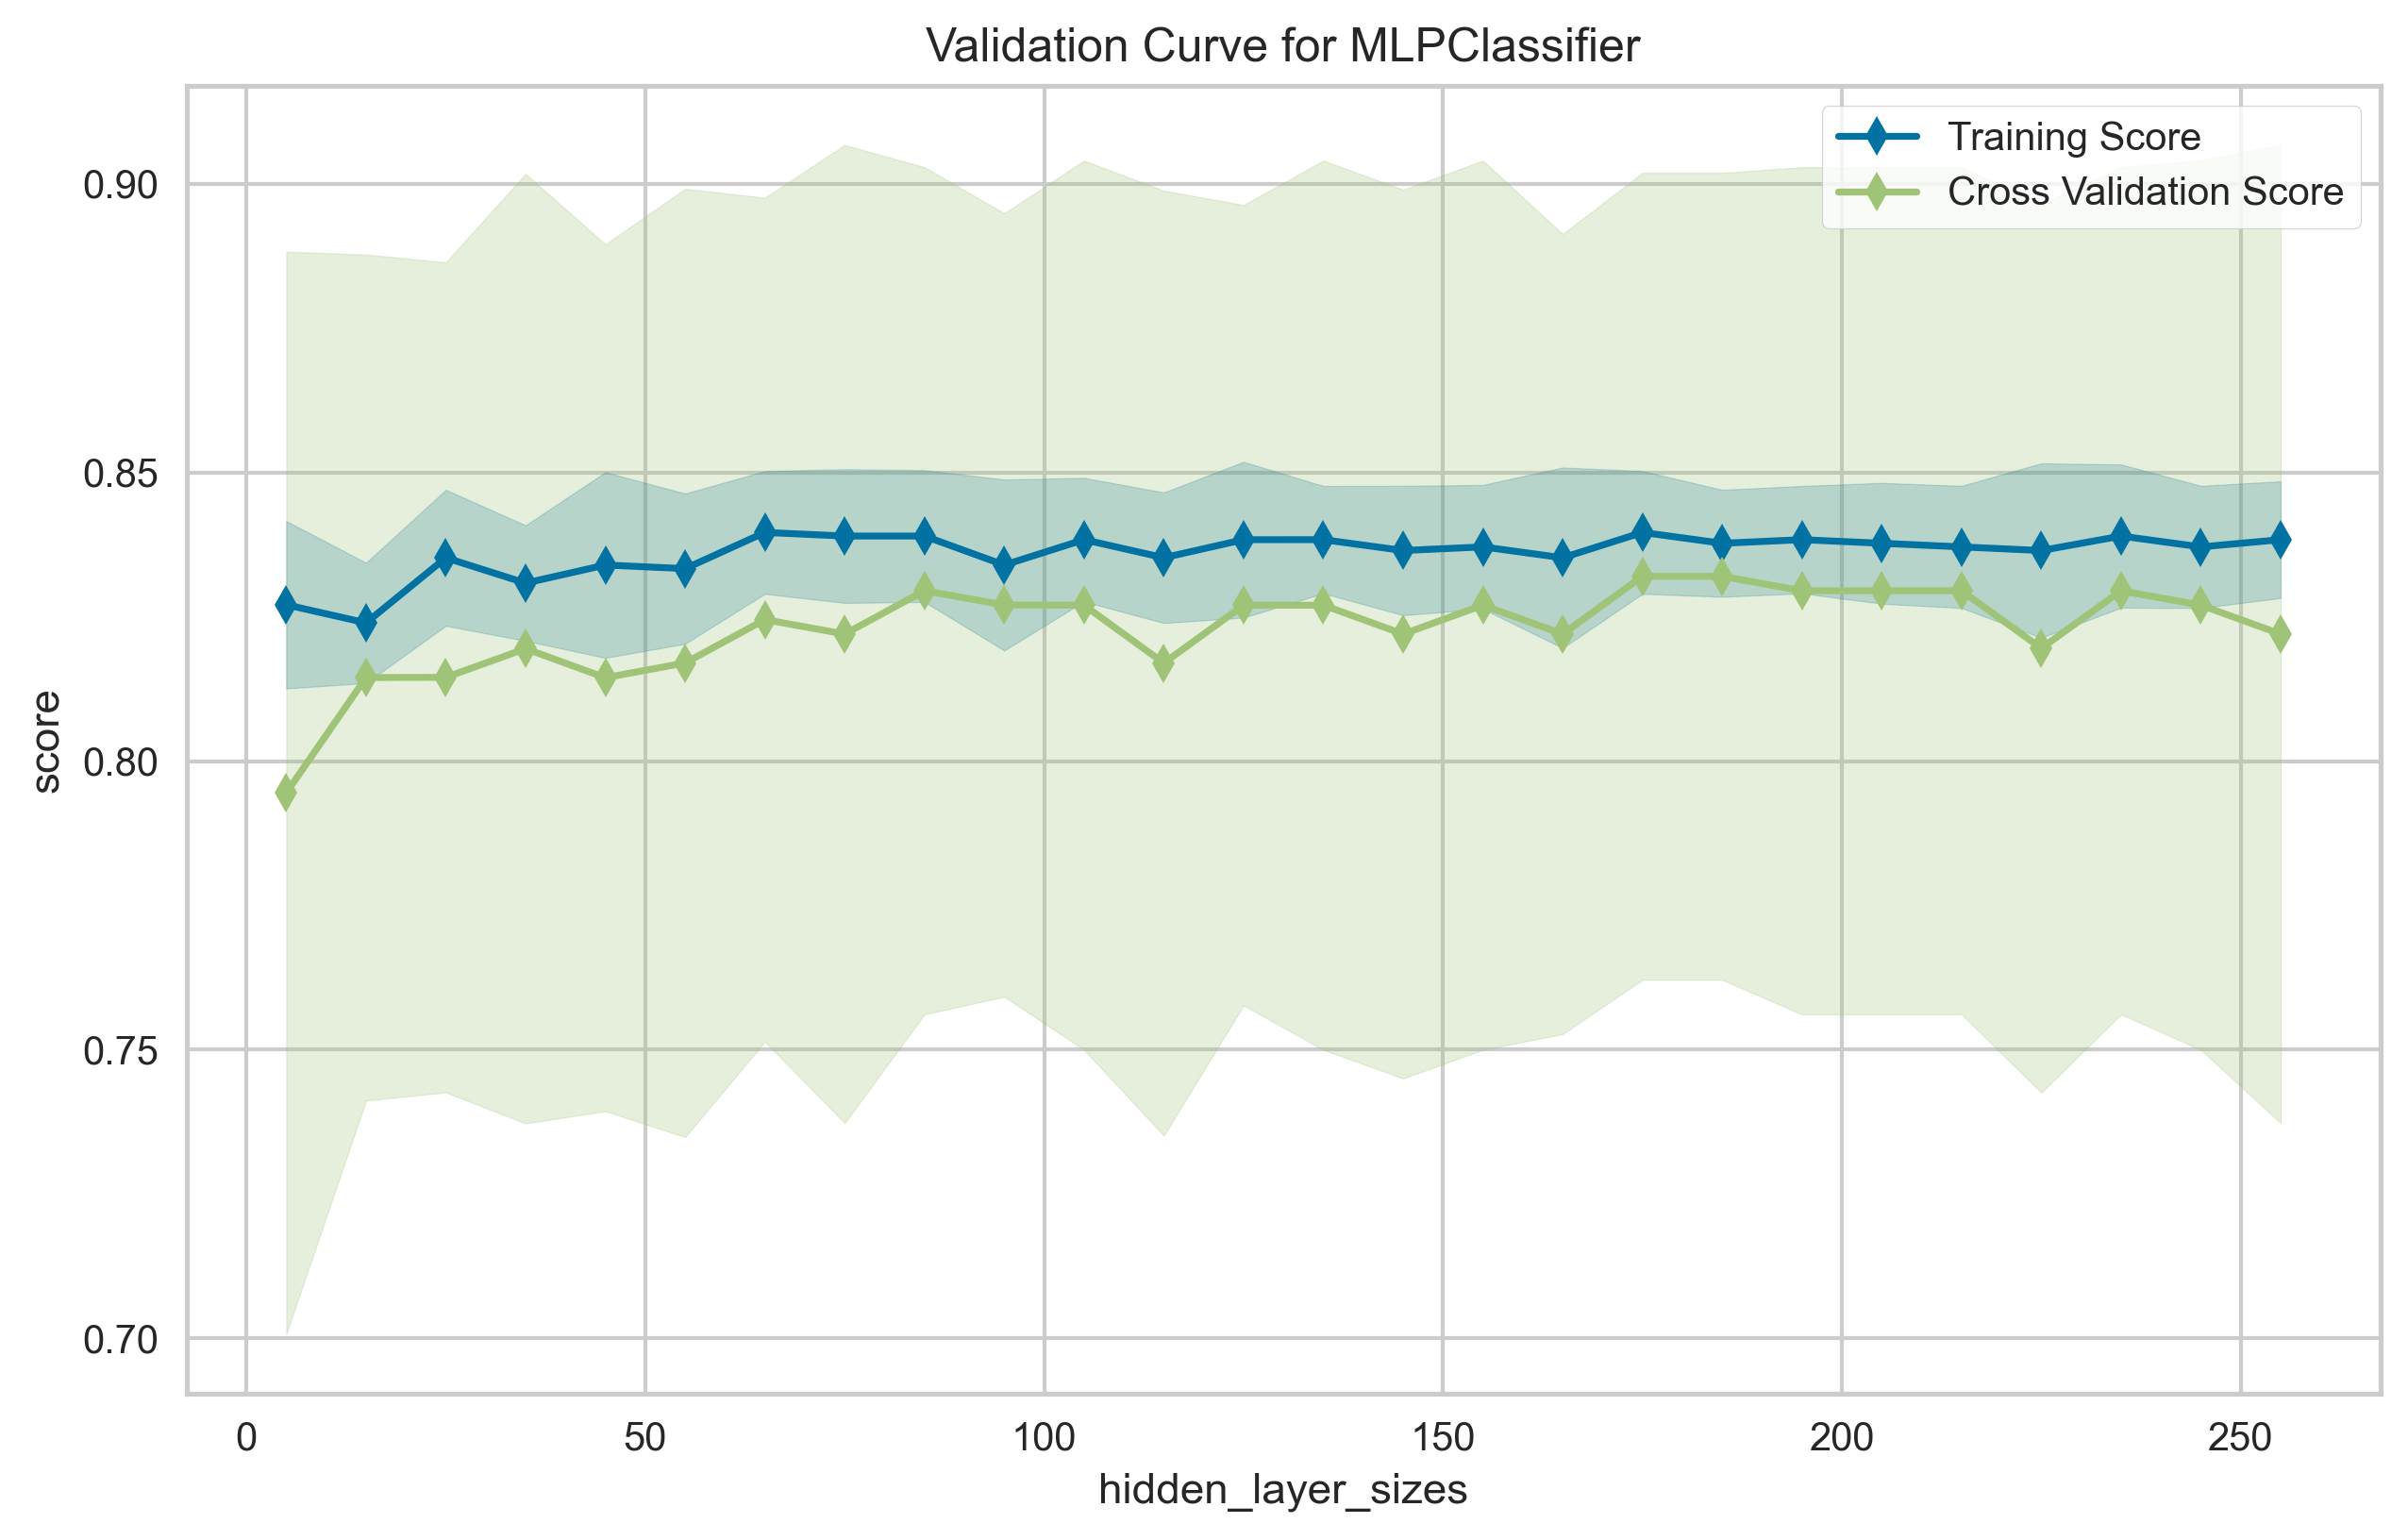

In [10]:
mlp_clf = MLPClassifier(random_state=SEED, max_iter=400)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="hidden_layer_sizes",
    param_range=np.arange(5, 256, 10),
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_hidden_height.png",
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/pavponn/opt/anaconda3/envs/assignment-1/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


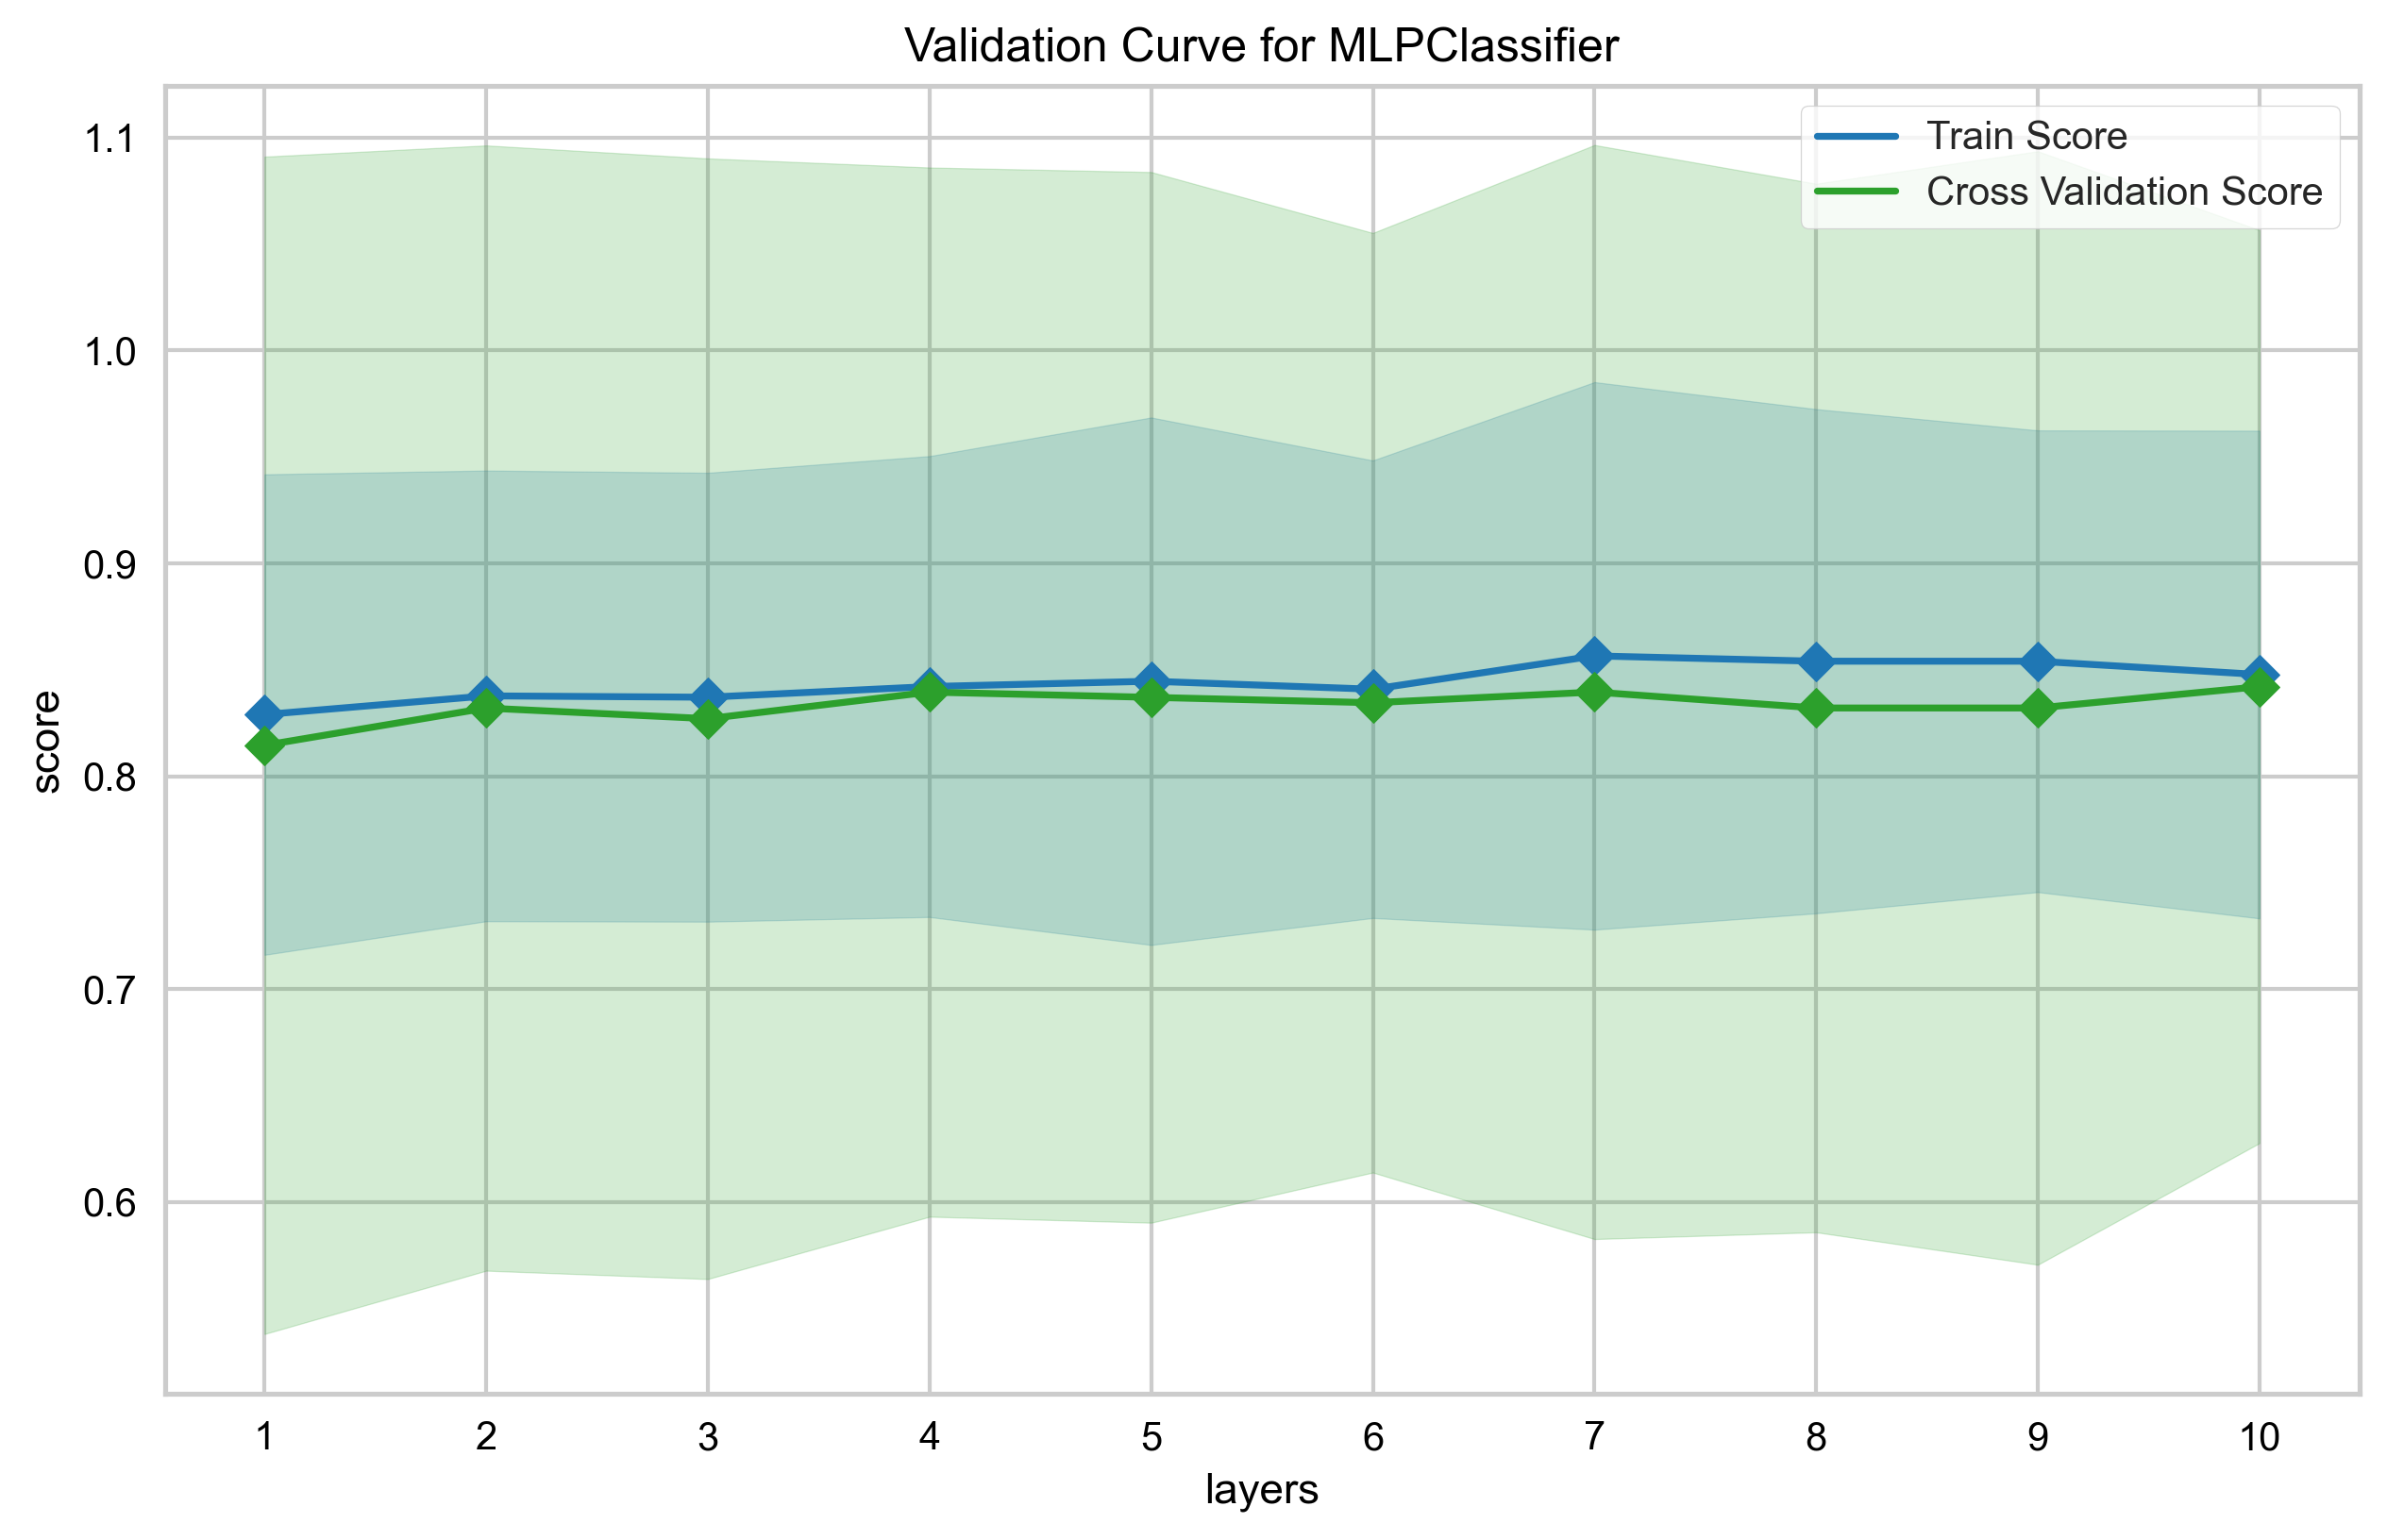

In [11]:
import importlib

importlib.reload(viz)

mlp_clf = MLPClassifier(random_state=SEED, max_iter=400)

layers_range = np.arange(1, 11, 1)
param_range = [(NUMBER_OF_FEATURES,) * num_layers for num_layers in layers_range]

viz.validation_curve_complex(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="hidden_layer_sizes",
    param_name_print="layers",
    param_range=param_range,
    param_range_print=layers_range,
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_hidden_width.png",
    legend_loc='upper right'
)

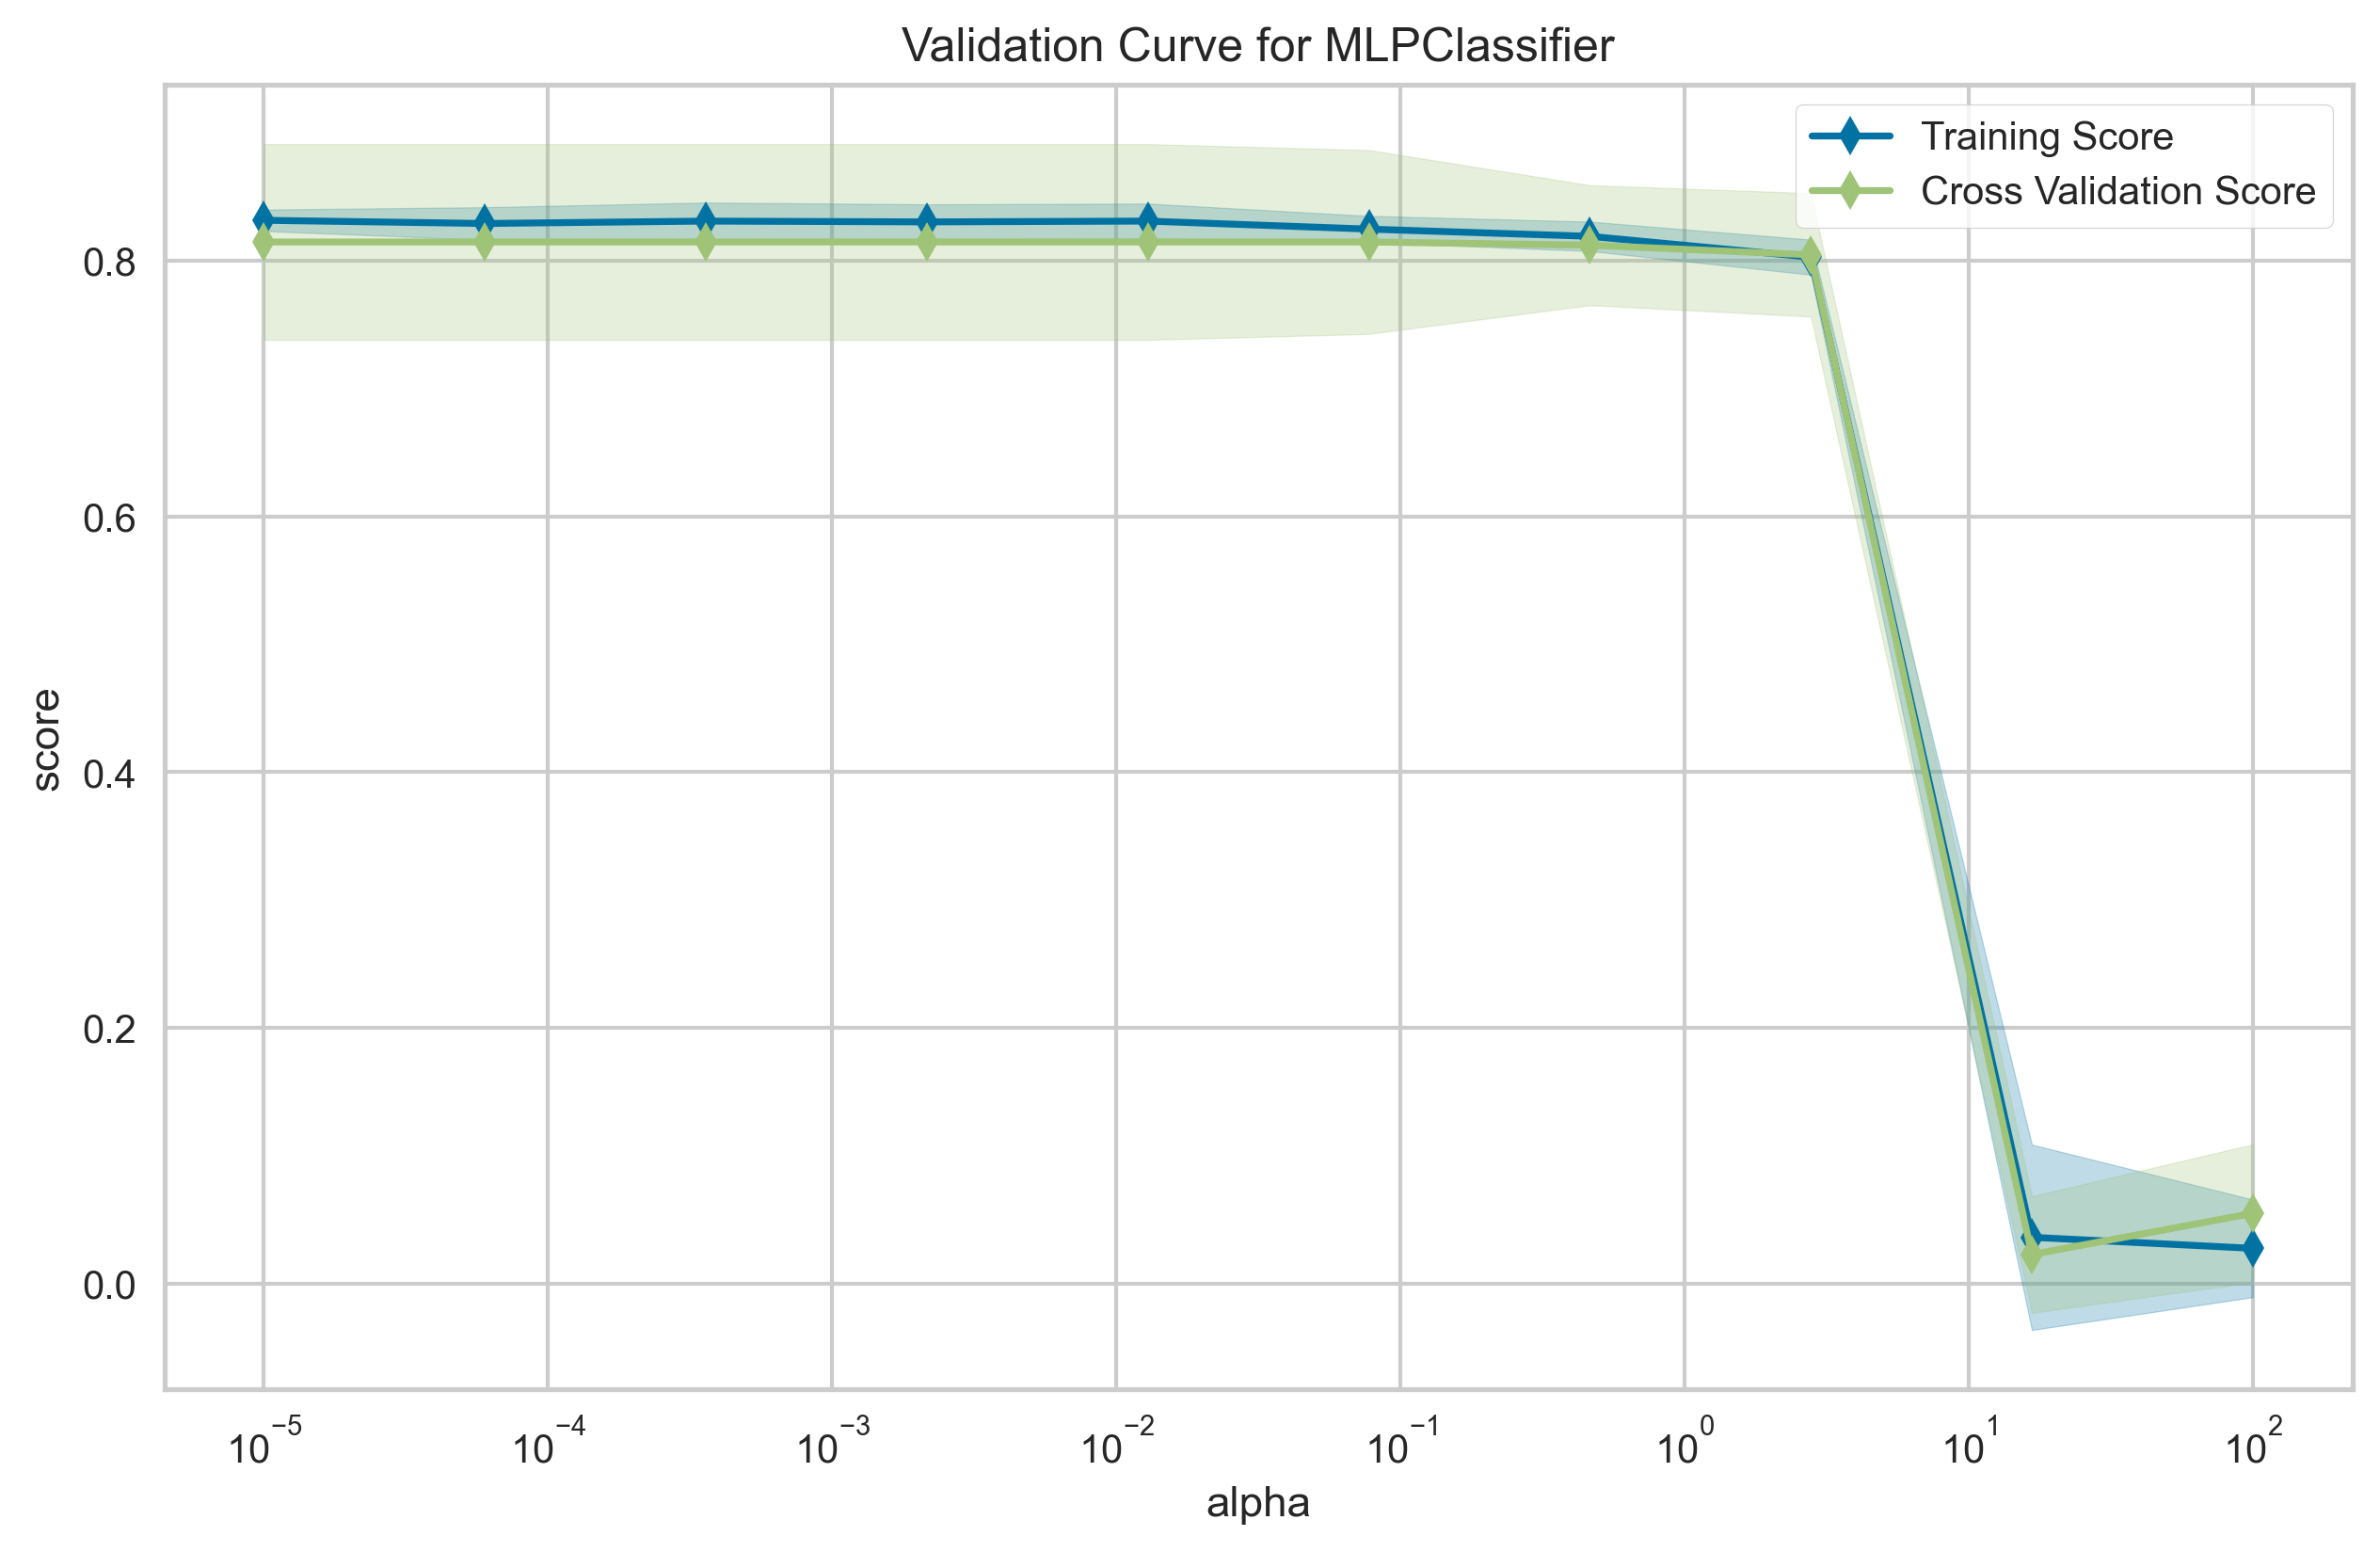

In [12]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="alpha",
    param_range=np.logspace(-5, 2, 10),
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_alpha.png",
    logx=True,
)

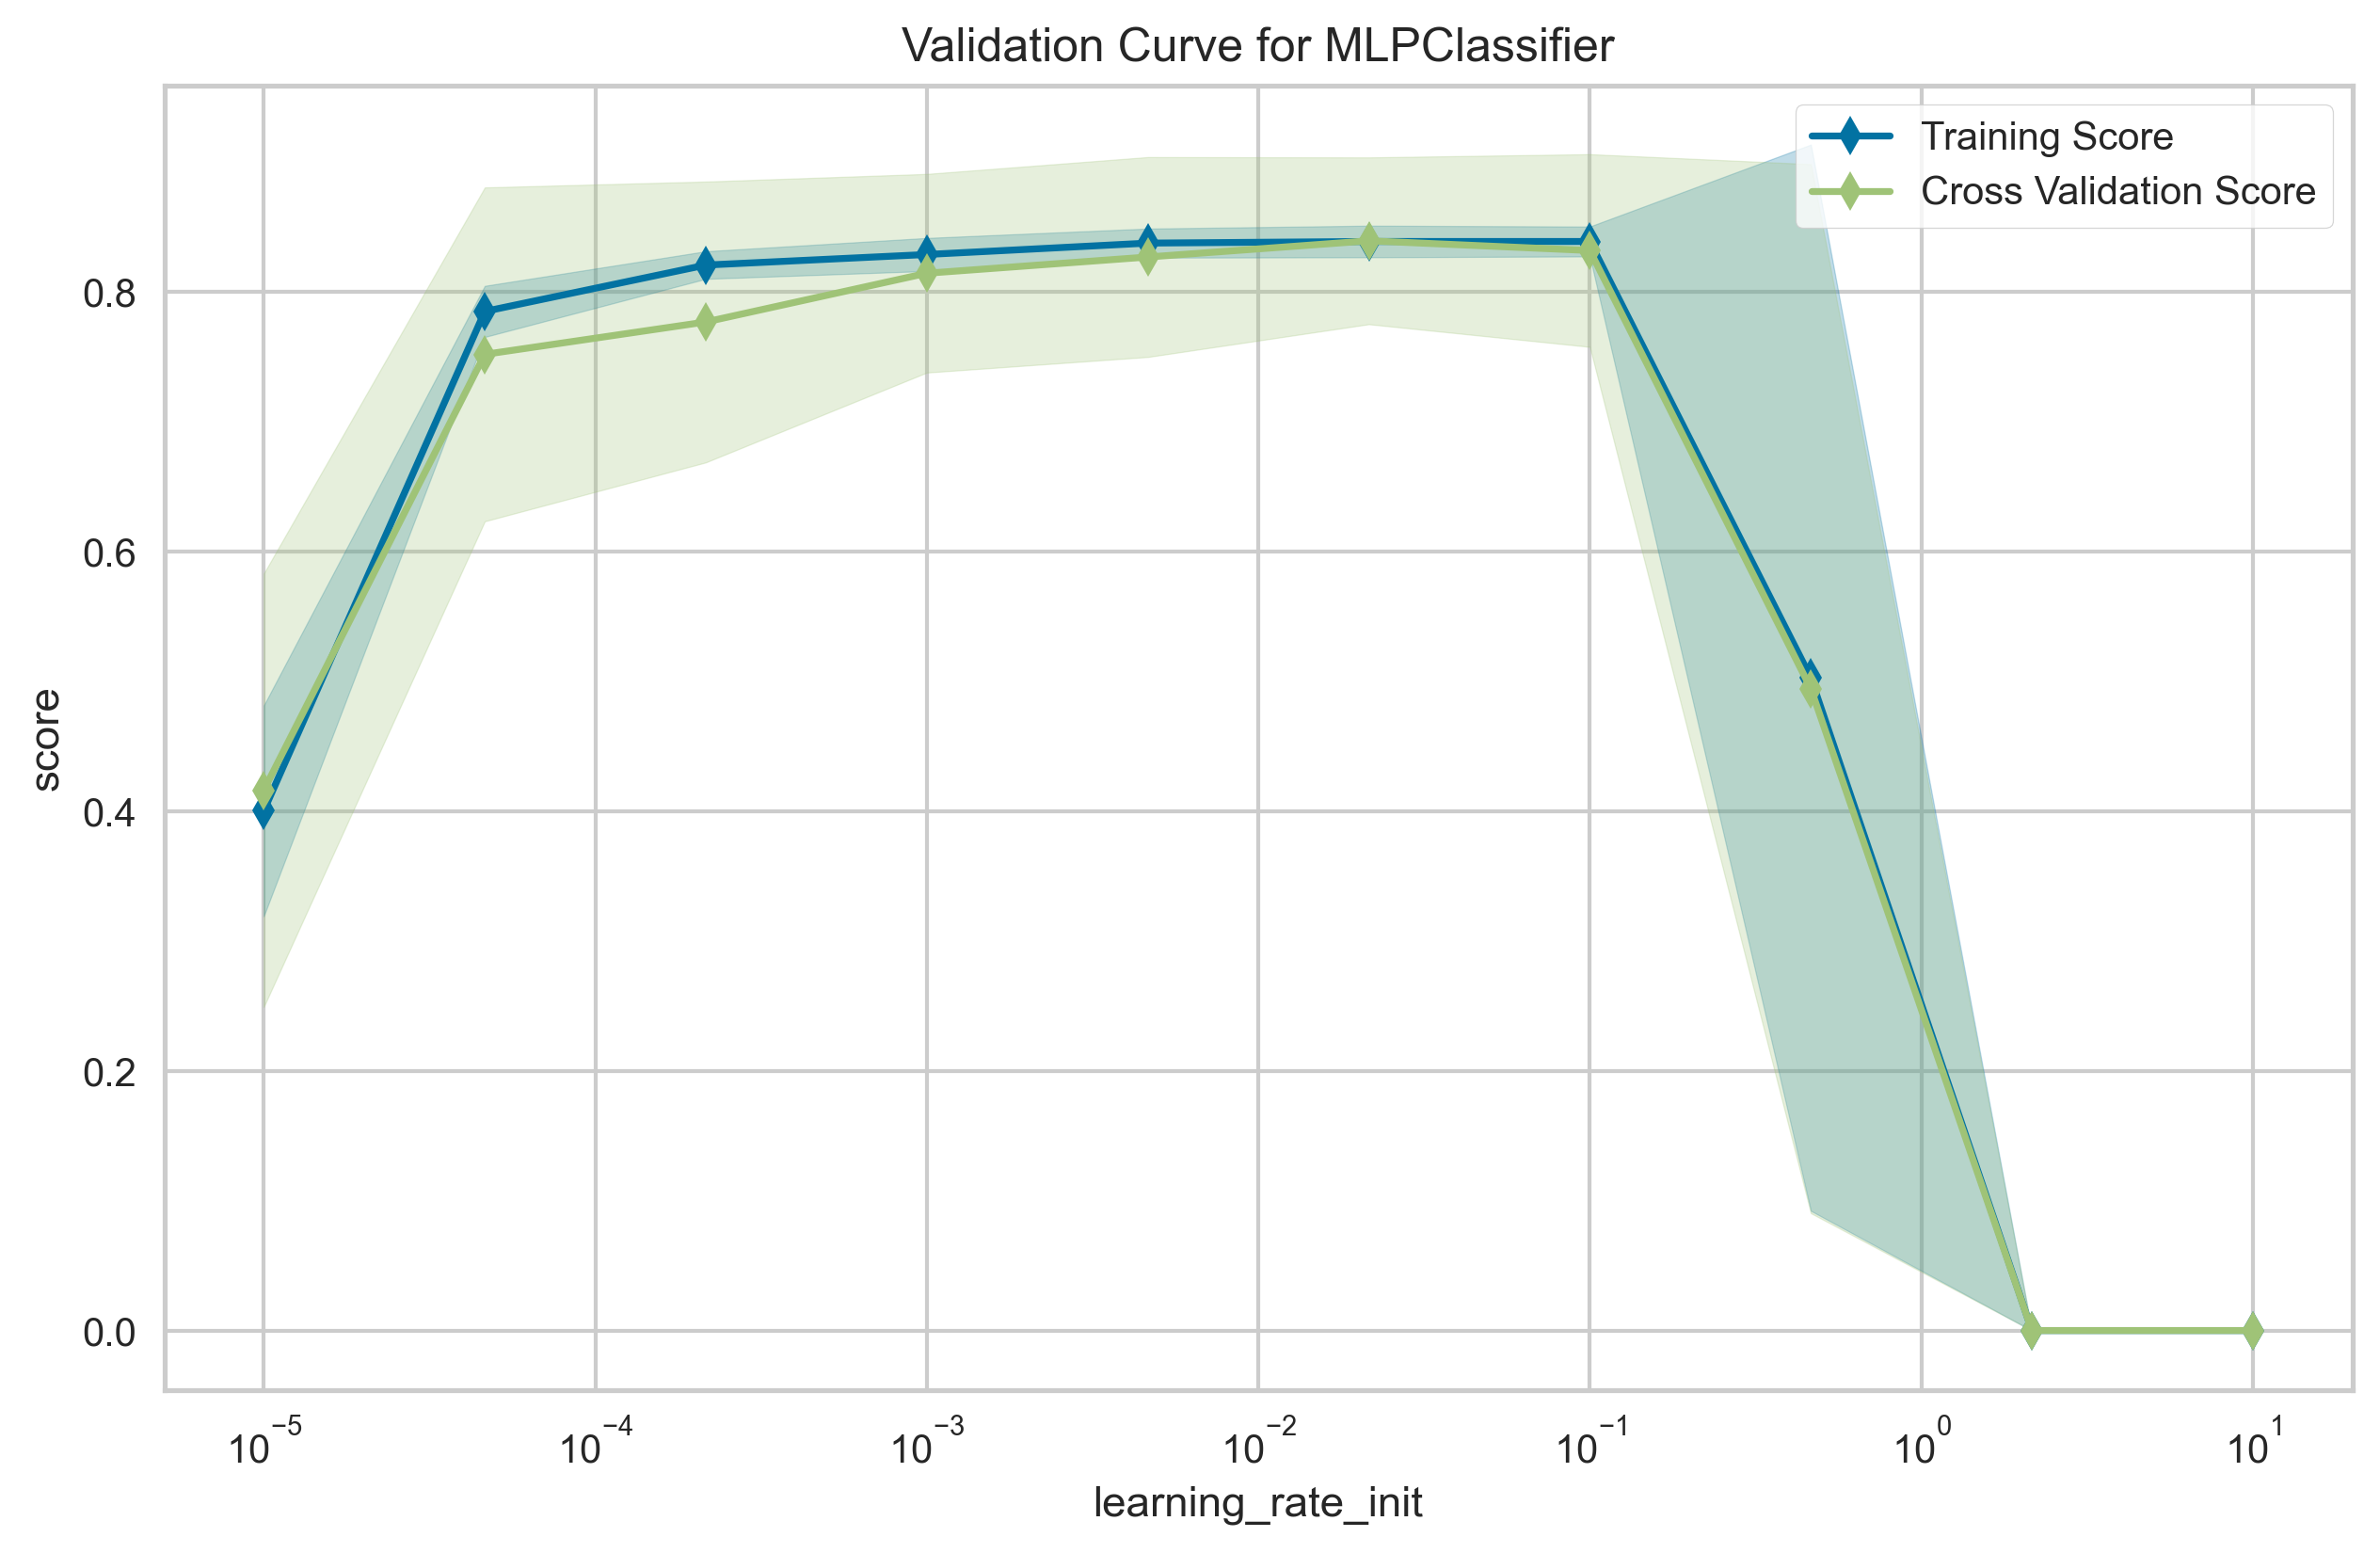

In [13]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate_init",
    param_range=np.logspace(-5, 1, 10),
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_learning_rate_init.png",
    logx=True,
)

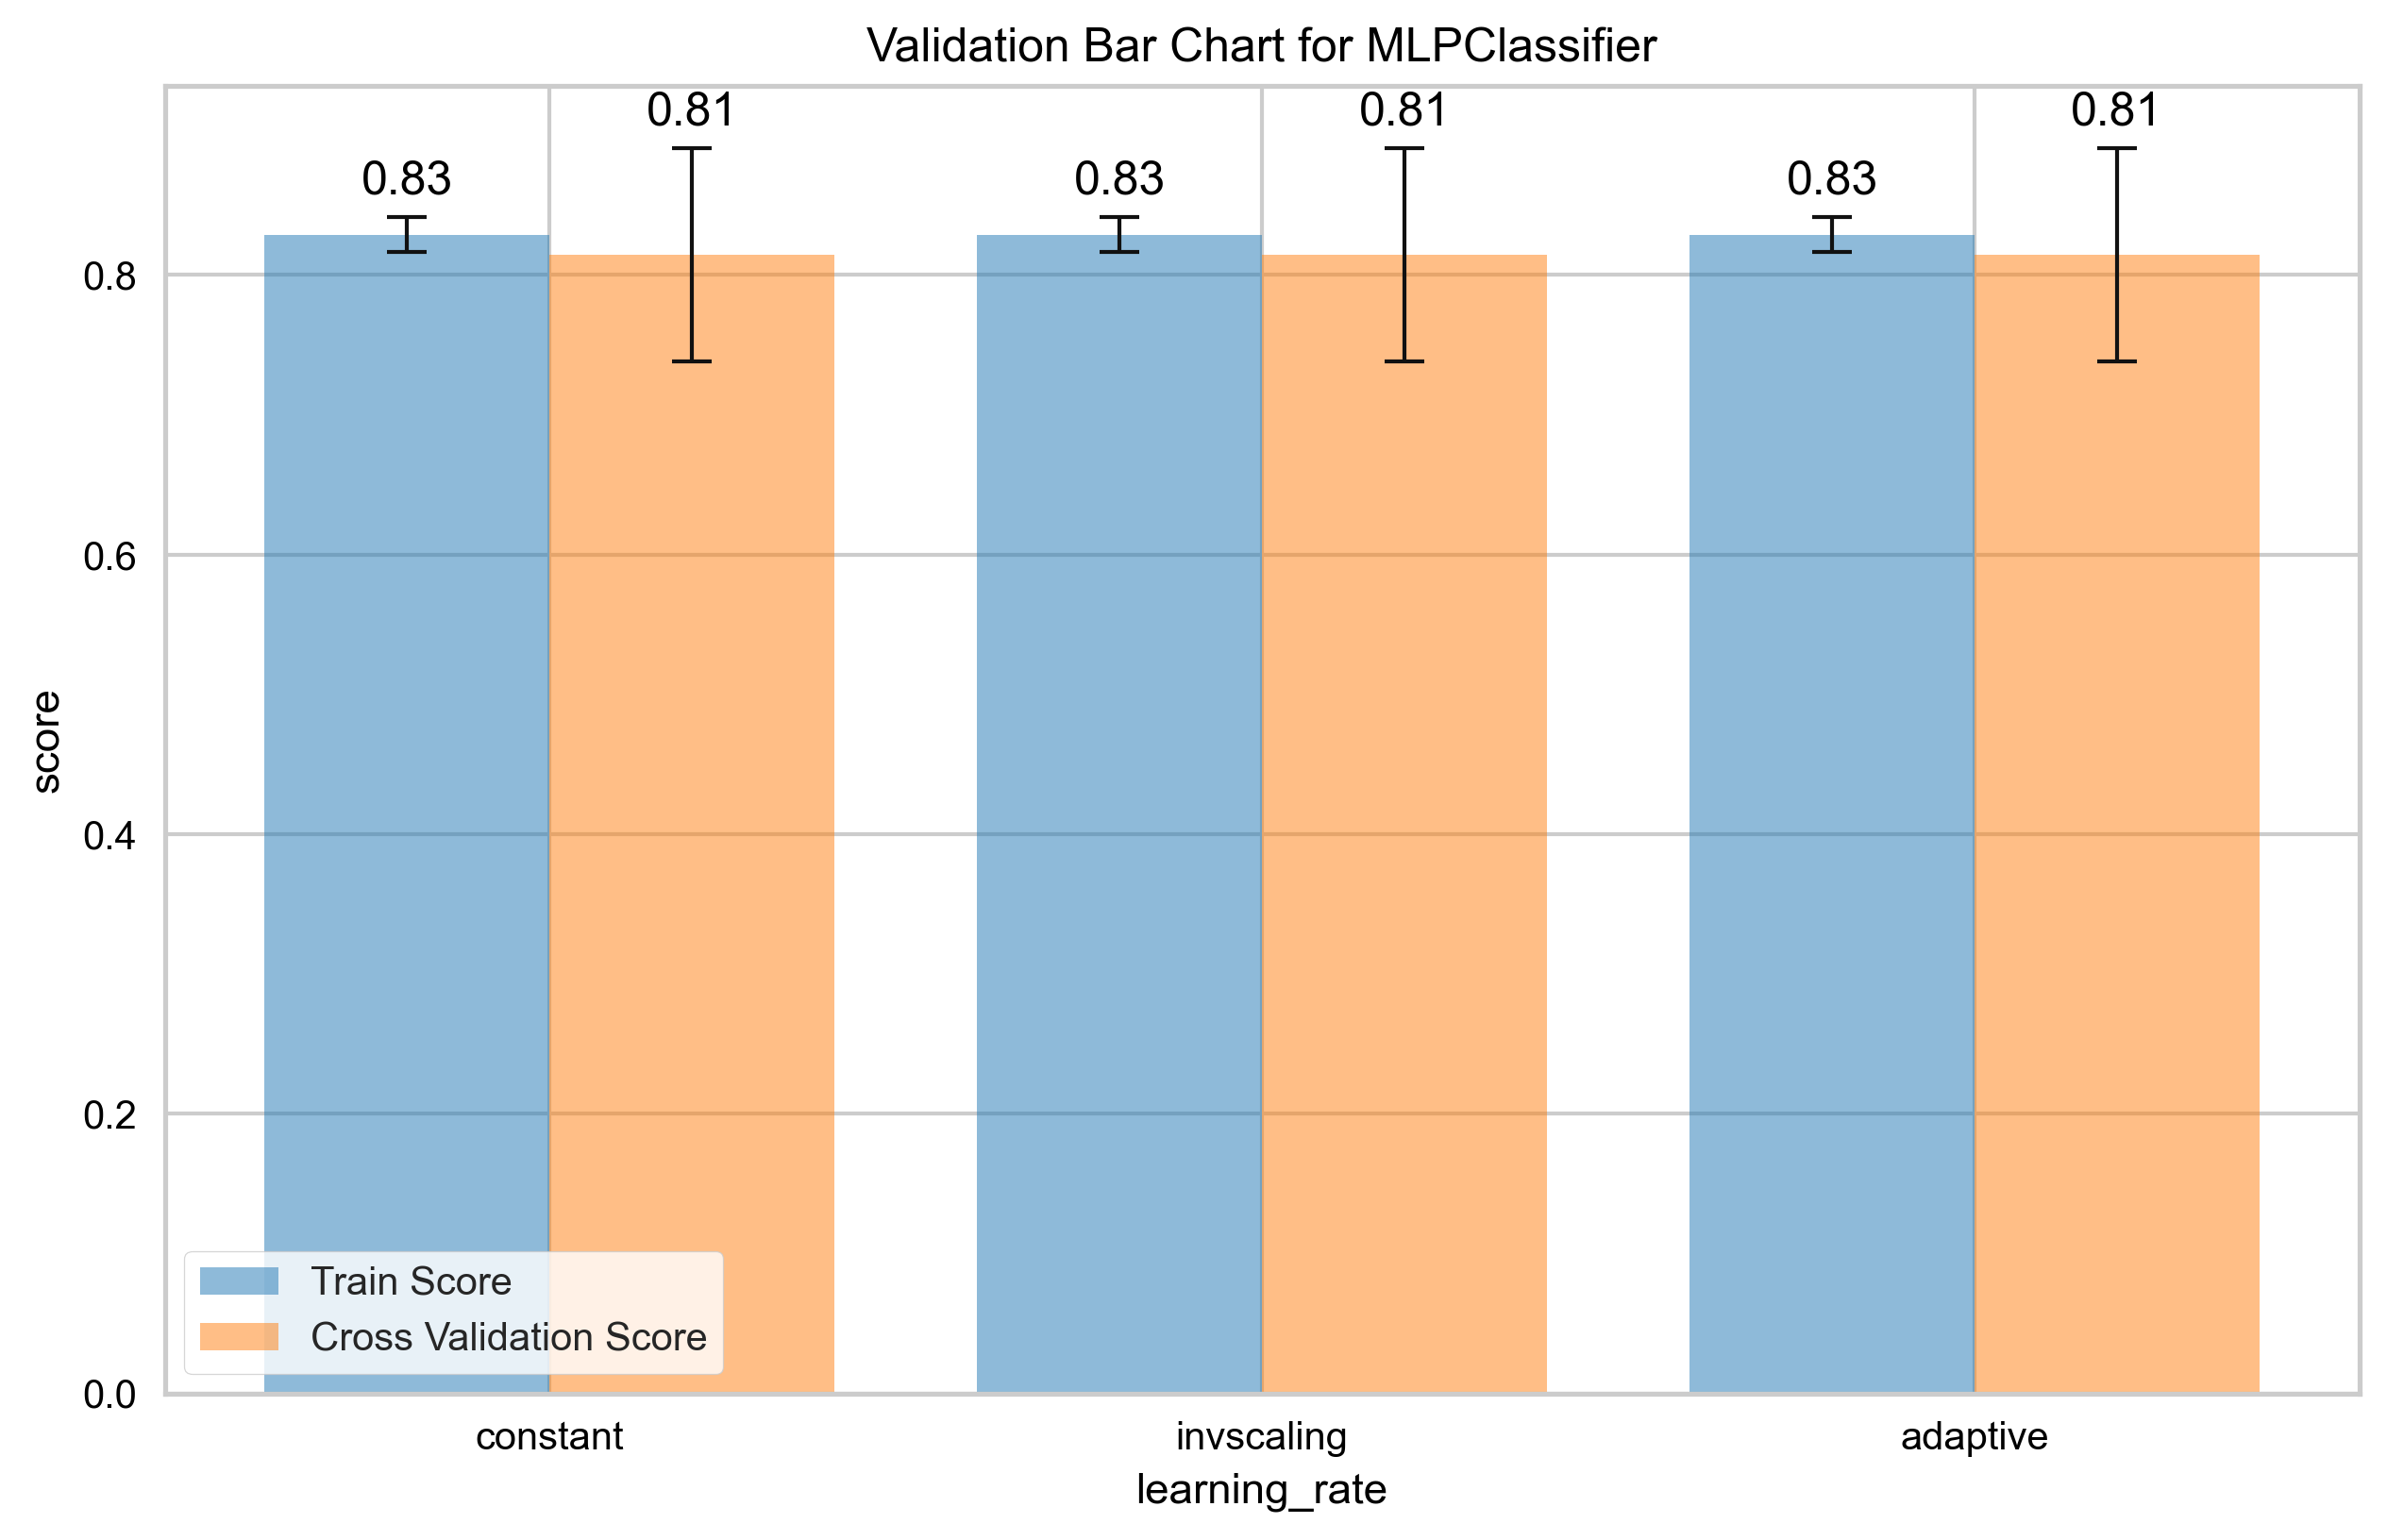

In [14]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
viz.validation_bar_chart(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="learning_rate",
    param_range=['constant', 'invscaling', 'adaptive'],
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_learning_rate.png",
)

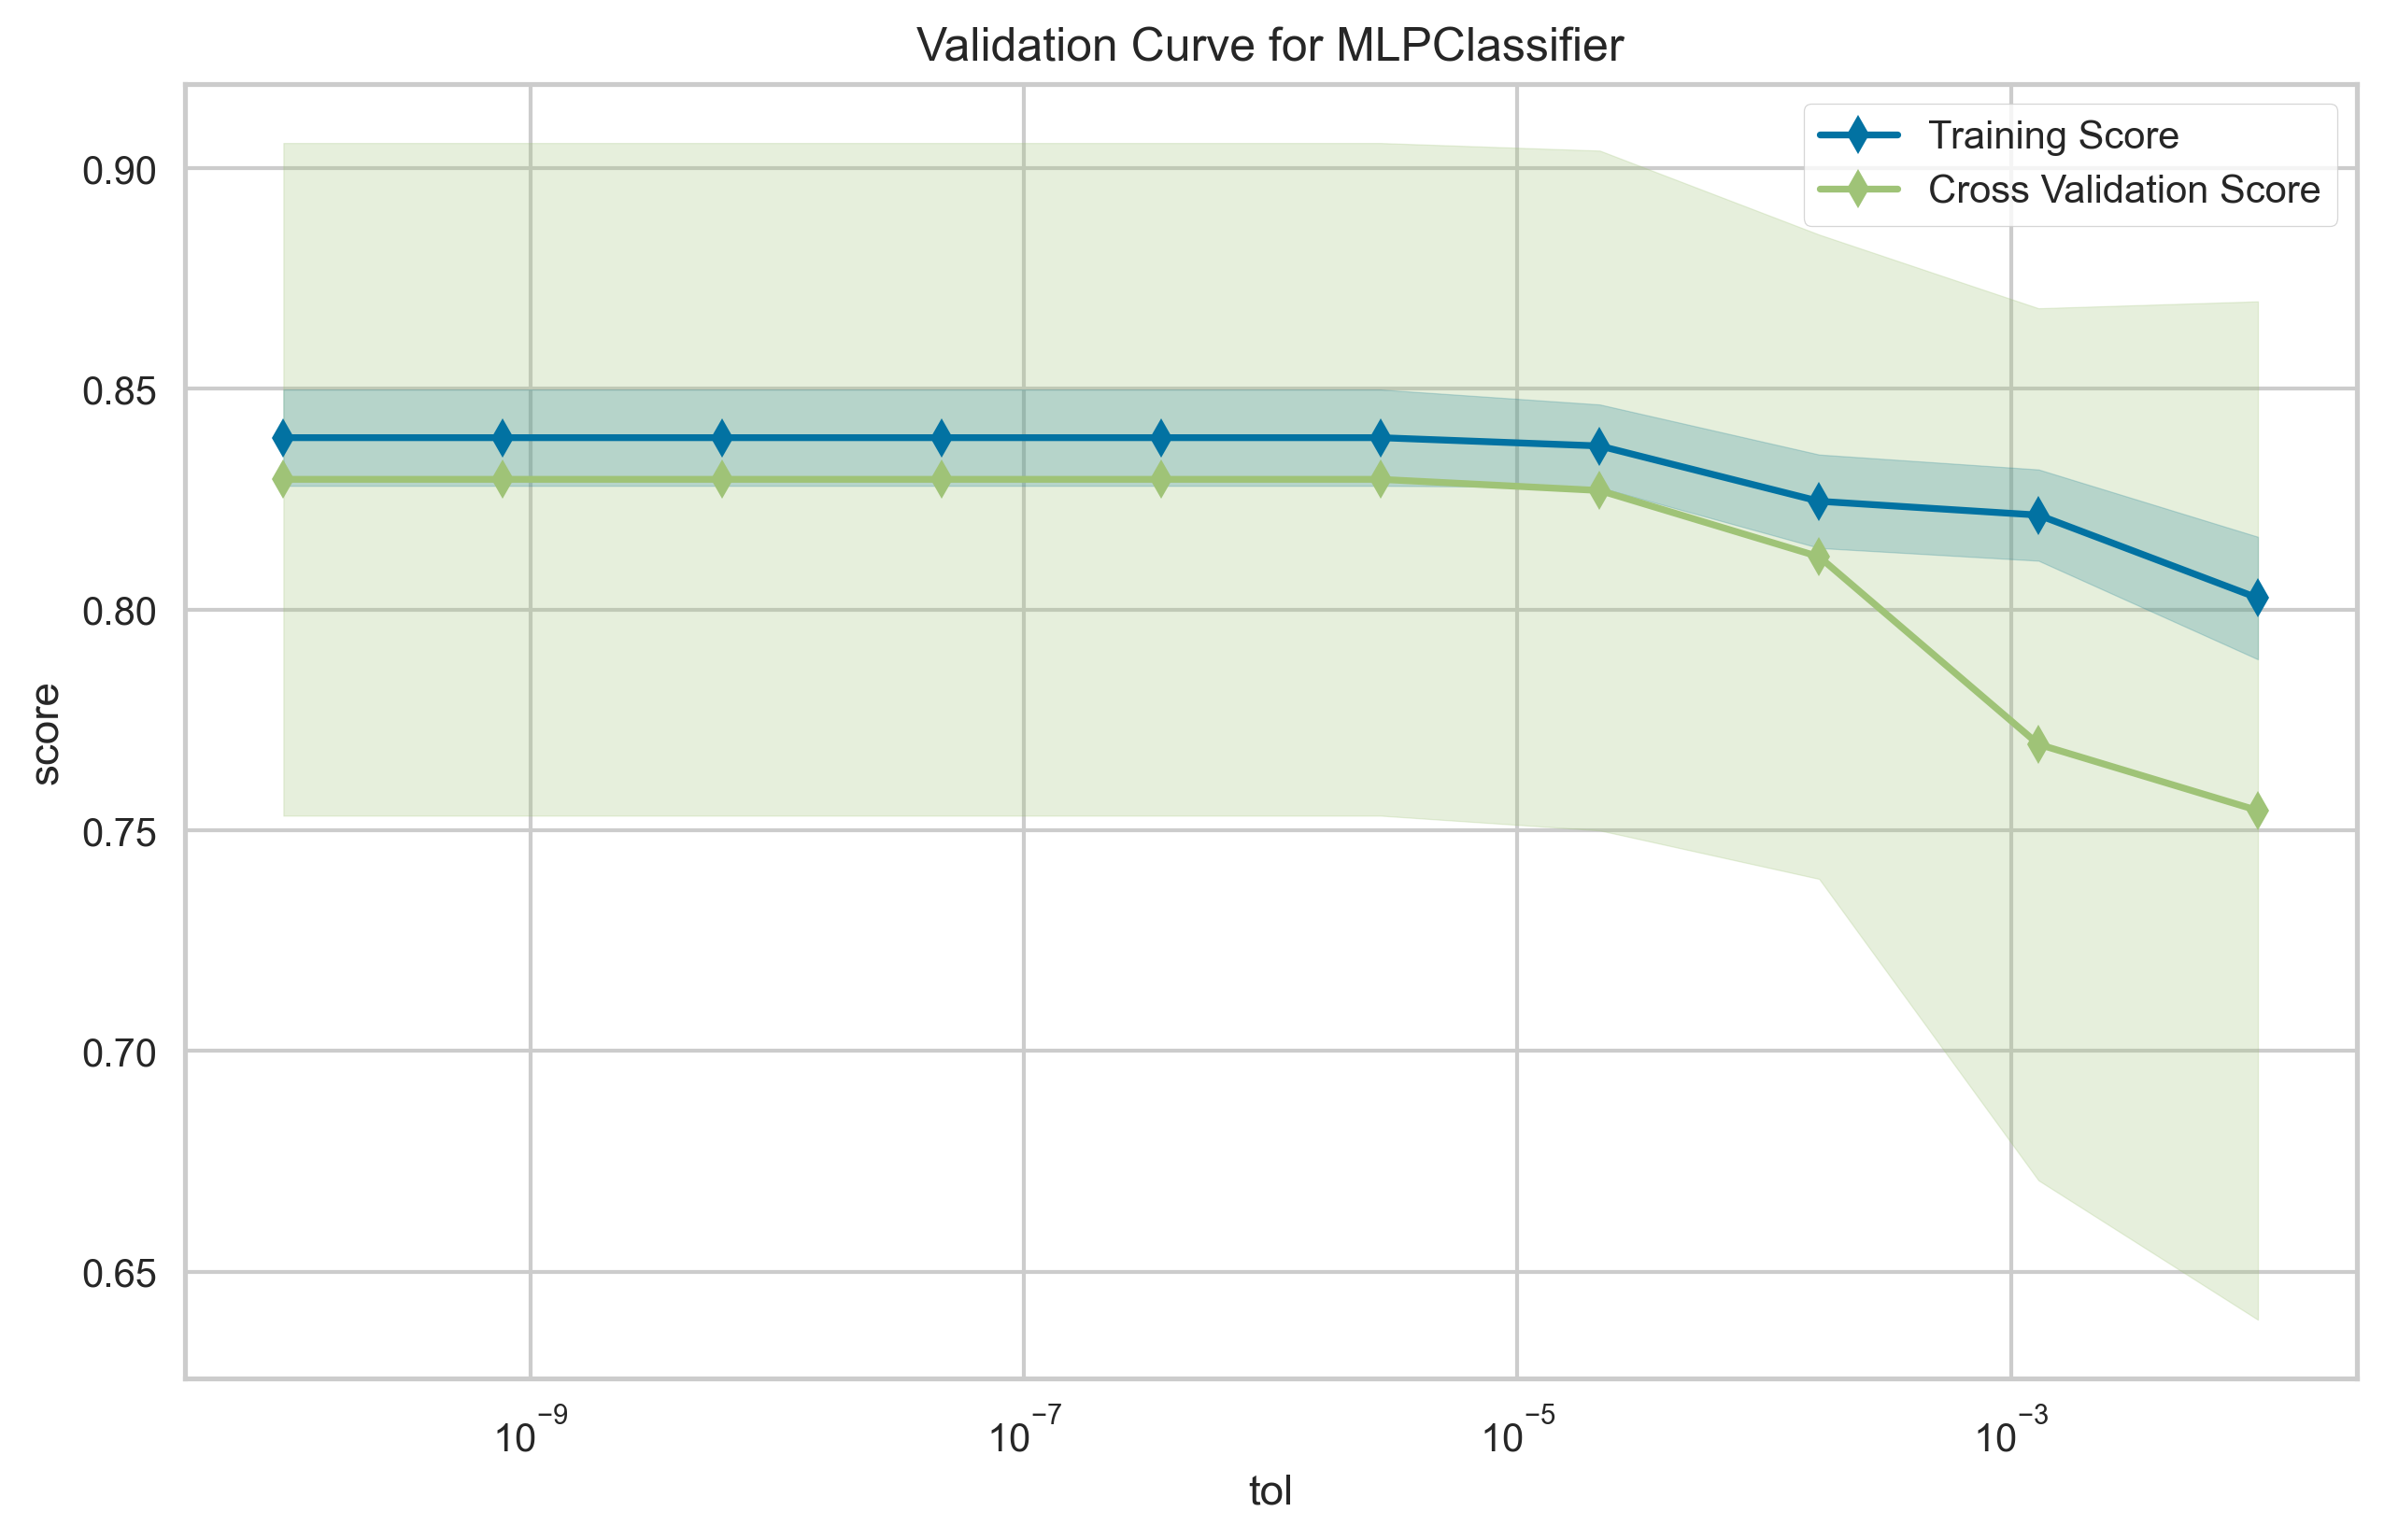

In [15]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="tol",
    param_range=np.logspace(-10, -2, 10),
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_tol.png",
    logx=True,
)

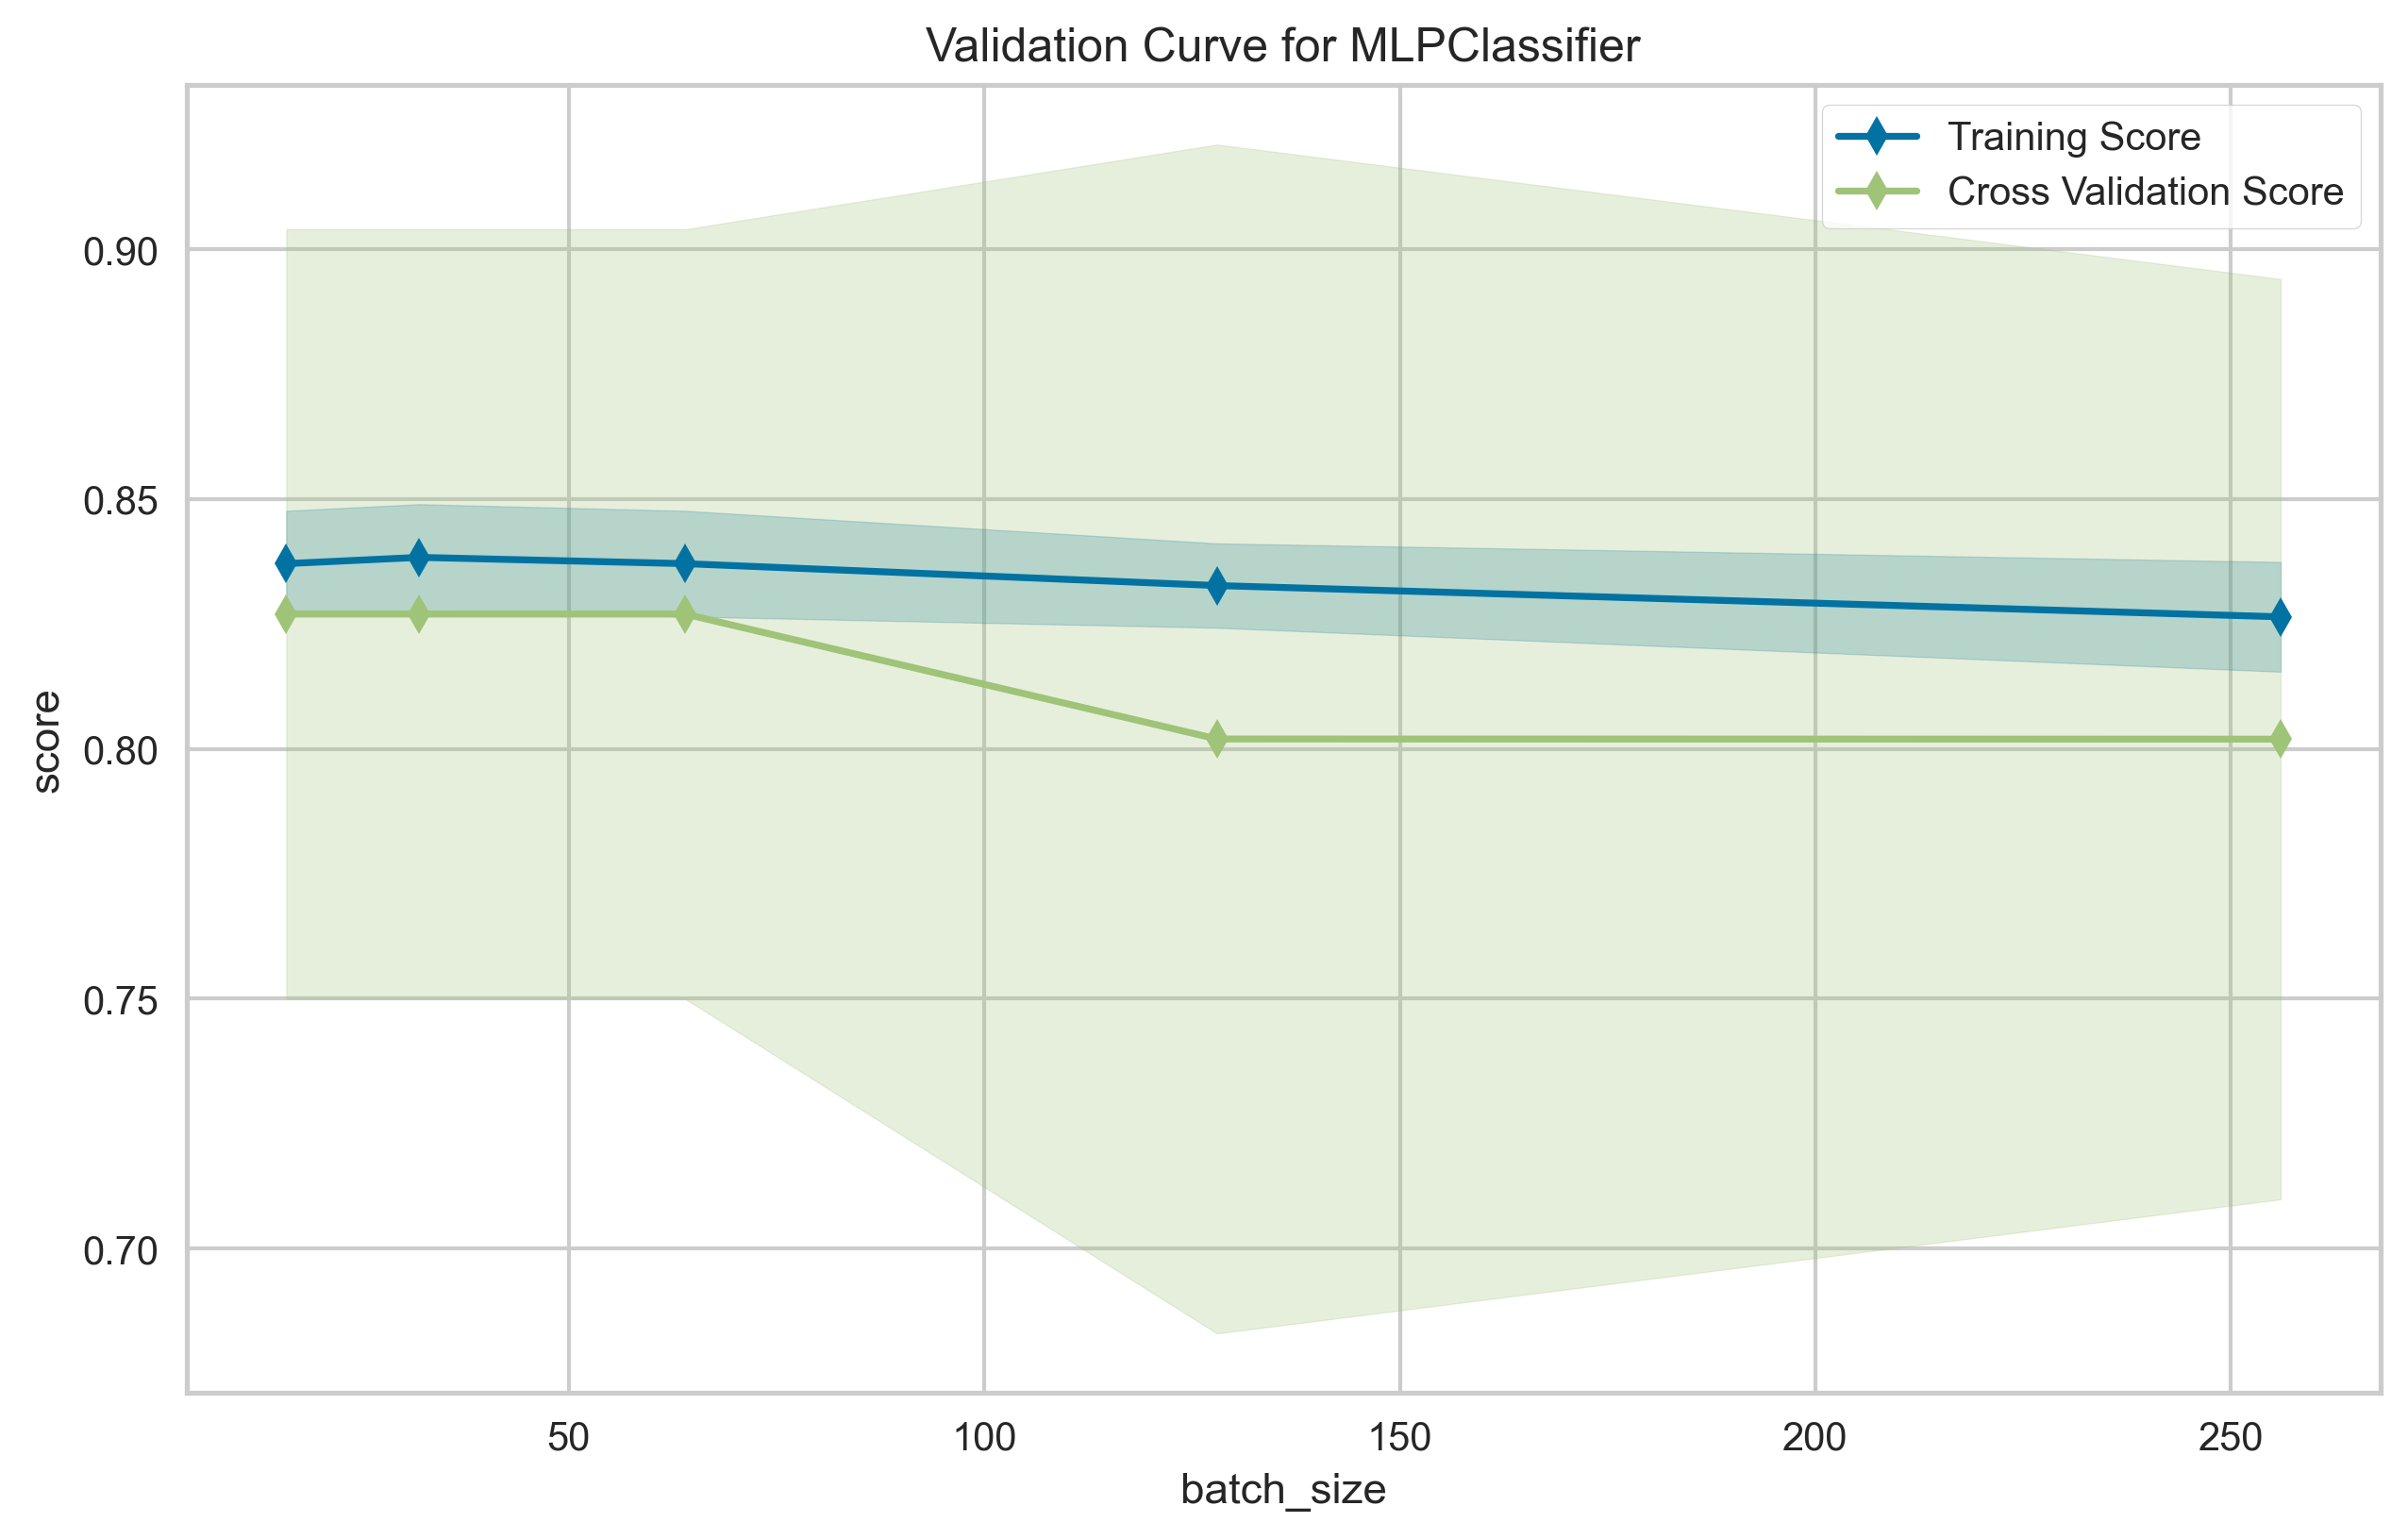

In [16]:
mlp_clf = MLPClassifier(random_state=SEED, hidden_layer_sizes=[NUMBER_OF_FEATURES], max_iter=400)
viz.validation_curve(
    clf=mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_name="batch_size",
    param_range=[16, 32, 64, 128, 256],
    output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_batch_size.png",

)

In [17]:
best_mlp_params = training.perform_hyperparameter_tuning(
    clf=MLPClassifier(random_state=SEED, hidden_layer_sizes=[50] * 2, max_iter=400, tol=1e-5, batch_size=32),
    X_tr=X_train_n,
    y_tr=y_train,
    cv=CV,
    param_space={
        "alpha": np.logspace(-3, -1, 3),
        "learning_rate_init": np.logspace(-3, -1, 3)
    },
    n_jobs=2,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [18]:
best_mlp_params


{'alpha': 0.001, 'learning_rate_init': 0.01}

In [19]:
def instantiate_best_mlp_clf(max_iter=400):
    return MLPClassifier(random_state=SEED, hidden_layer_sizes=[50] * 2, max_iter=max_iter,
                         tol=1e-5, batch_size=16, alpha=best_mlp_params['alpha'] or 0.001,
                         learning_rate_init=best_mlp_params['learning_rate_init'] or 0.01)

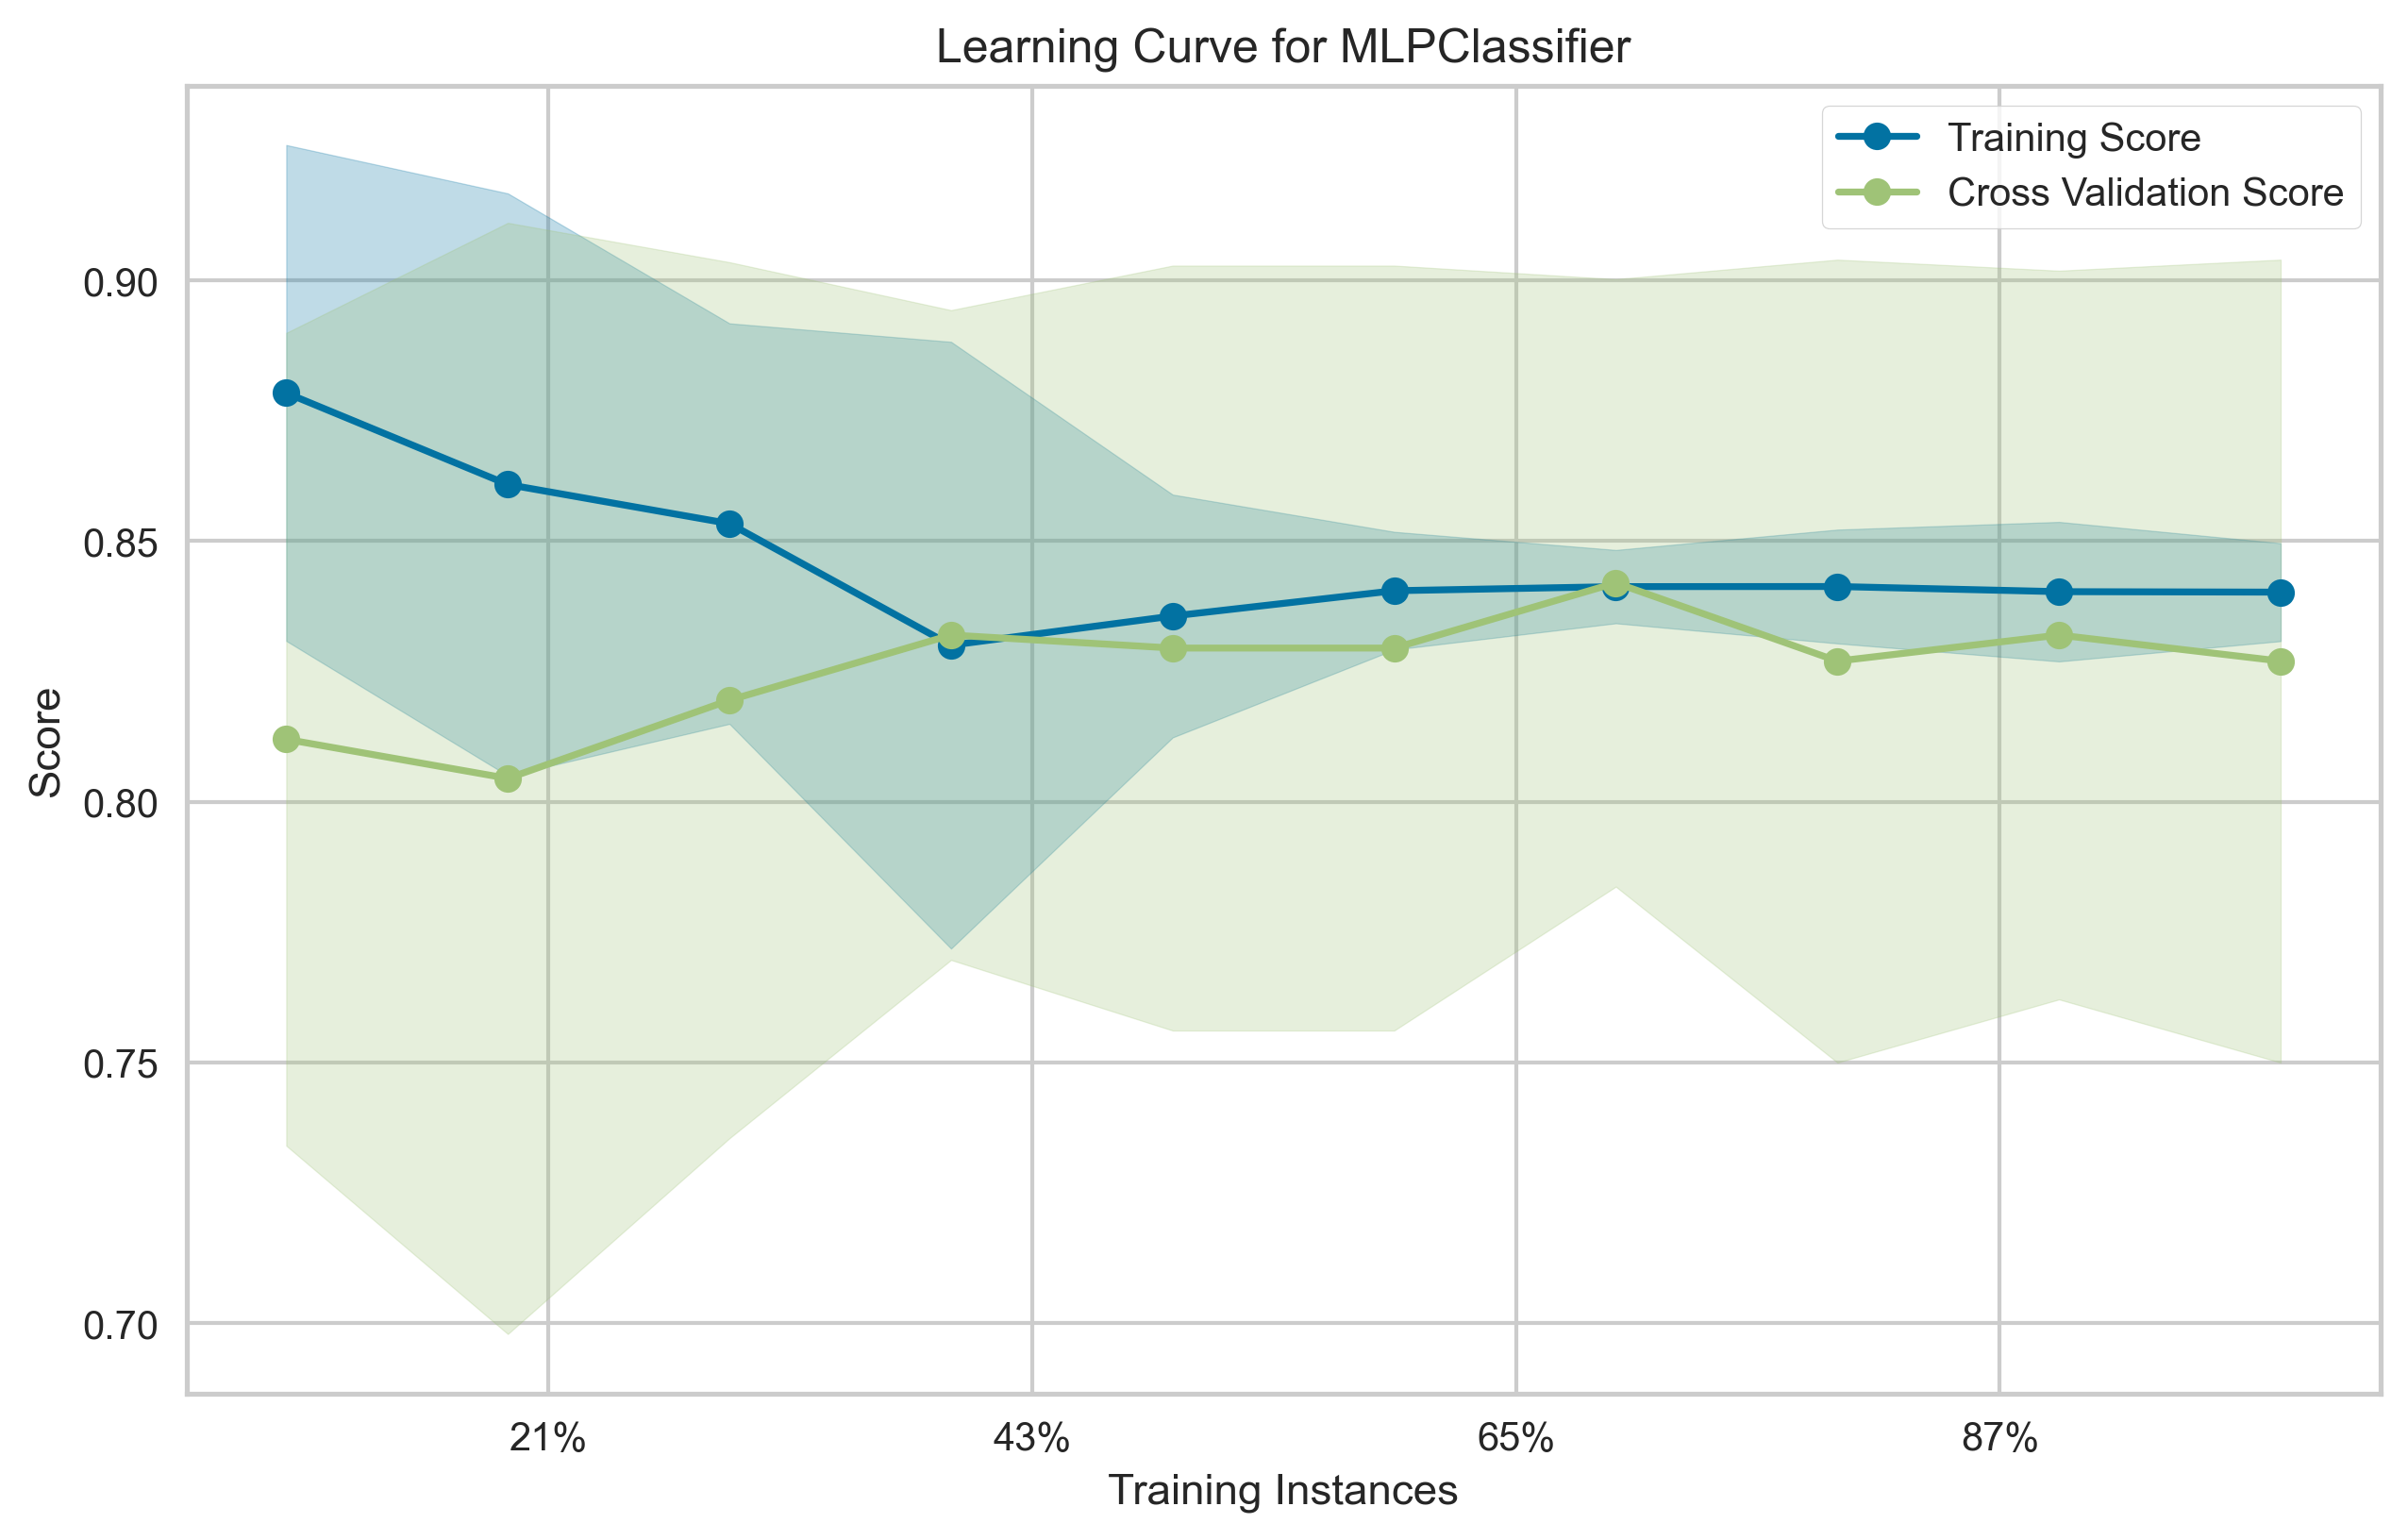

In [20]:
best_mlp_clf = instantiate_best_mlp_clf()
viz.learning_curve(clf=best_mlp_clf,
                   X_tr=X_train_n,
                   y_tr=y_train,
                   cv=CV,
                   output_path=f"{CREDIT_CARDS_MLP_PATH}/mlp_learning_curve.png")

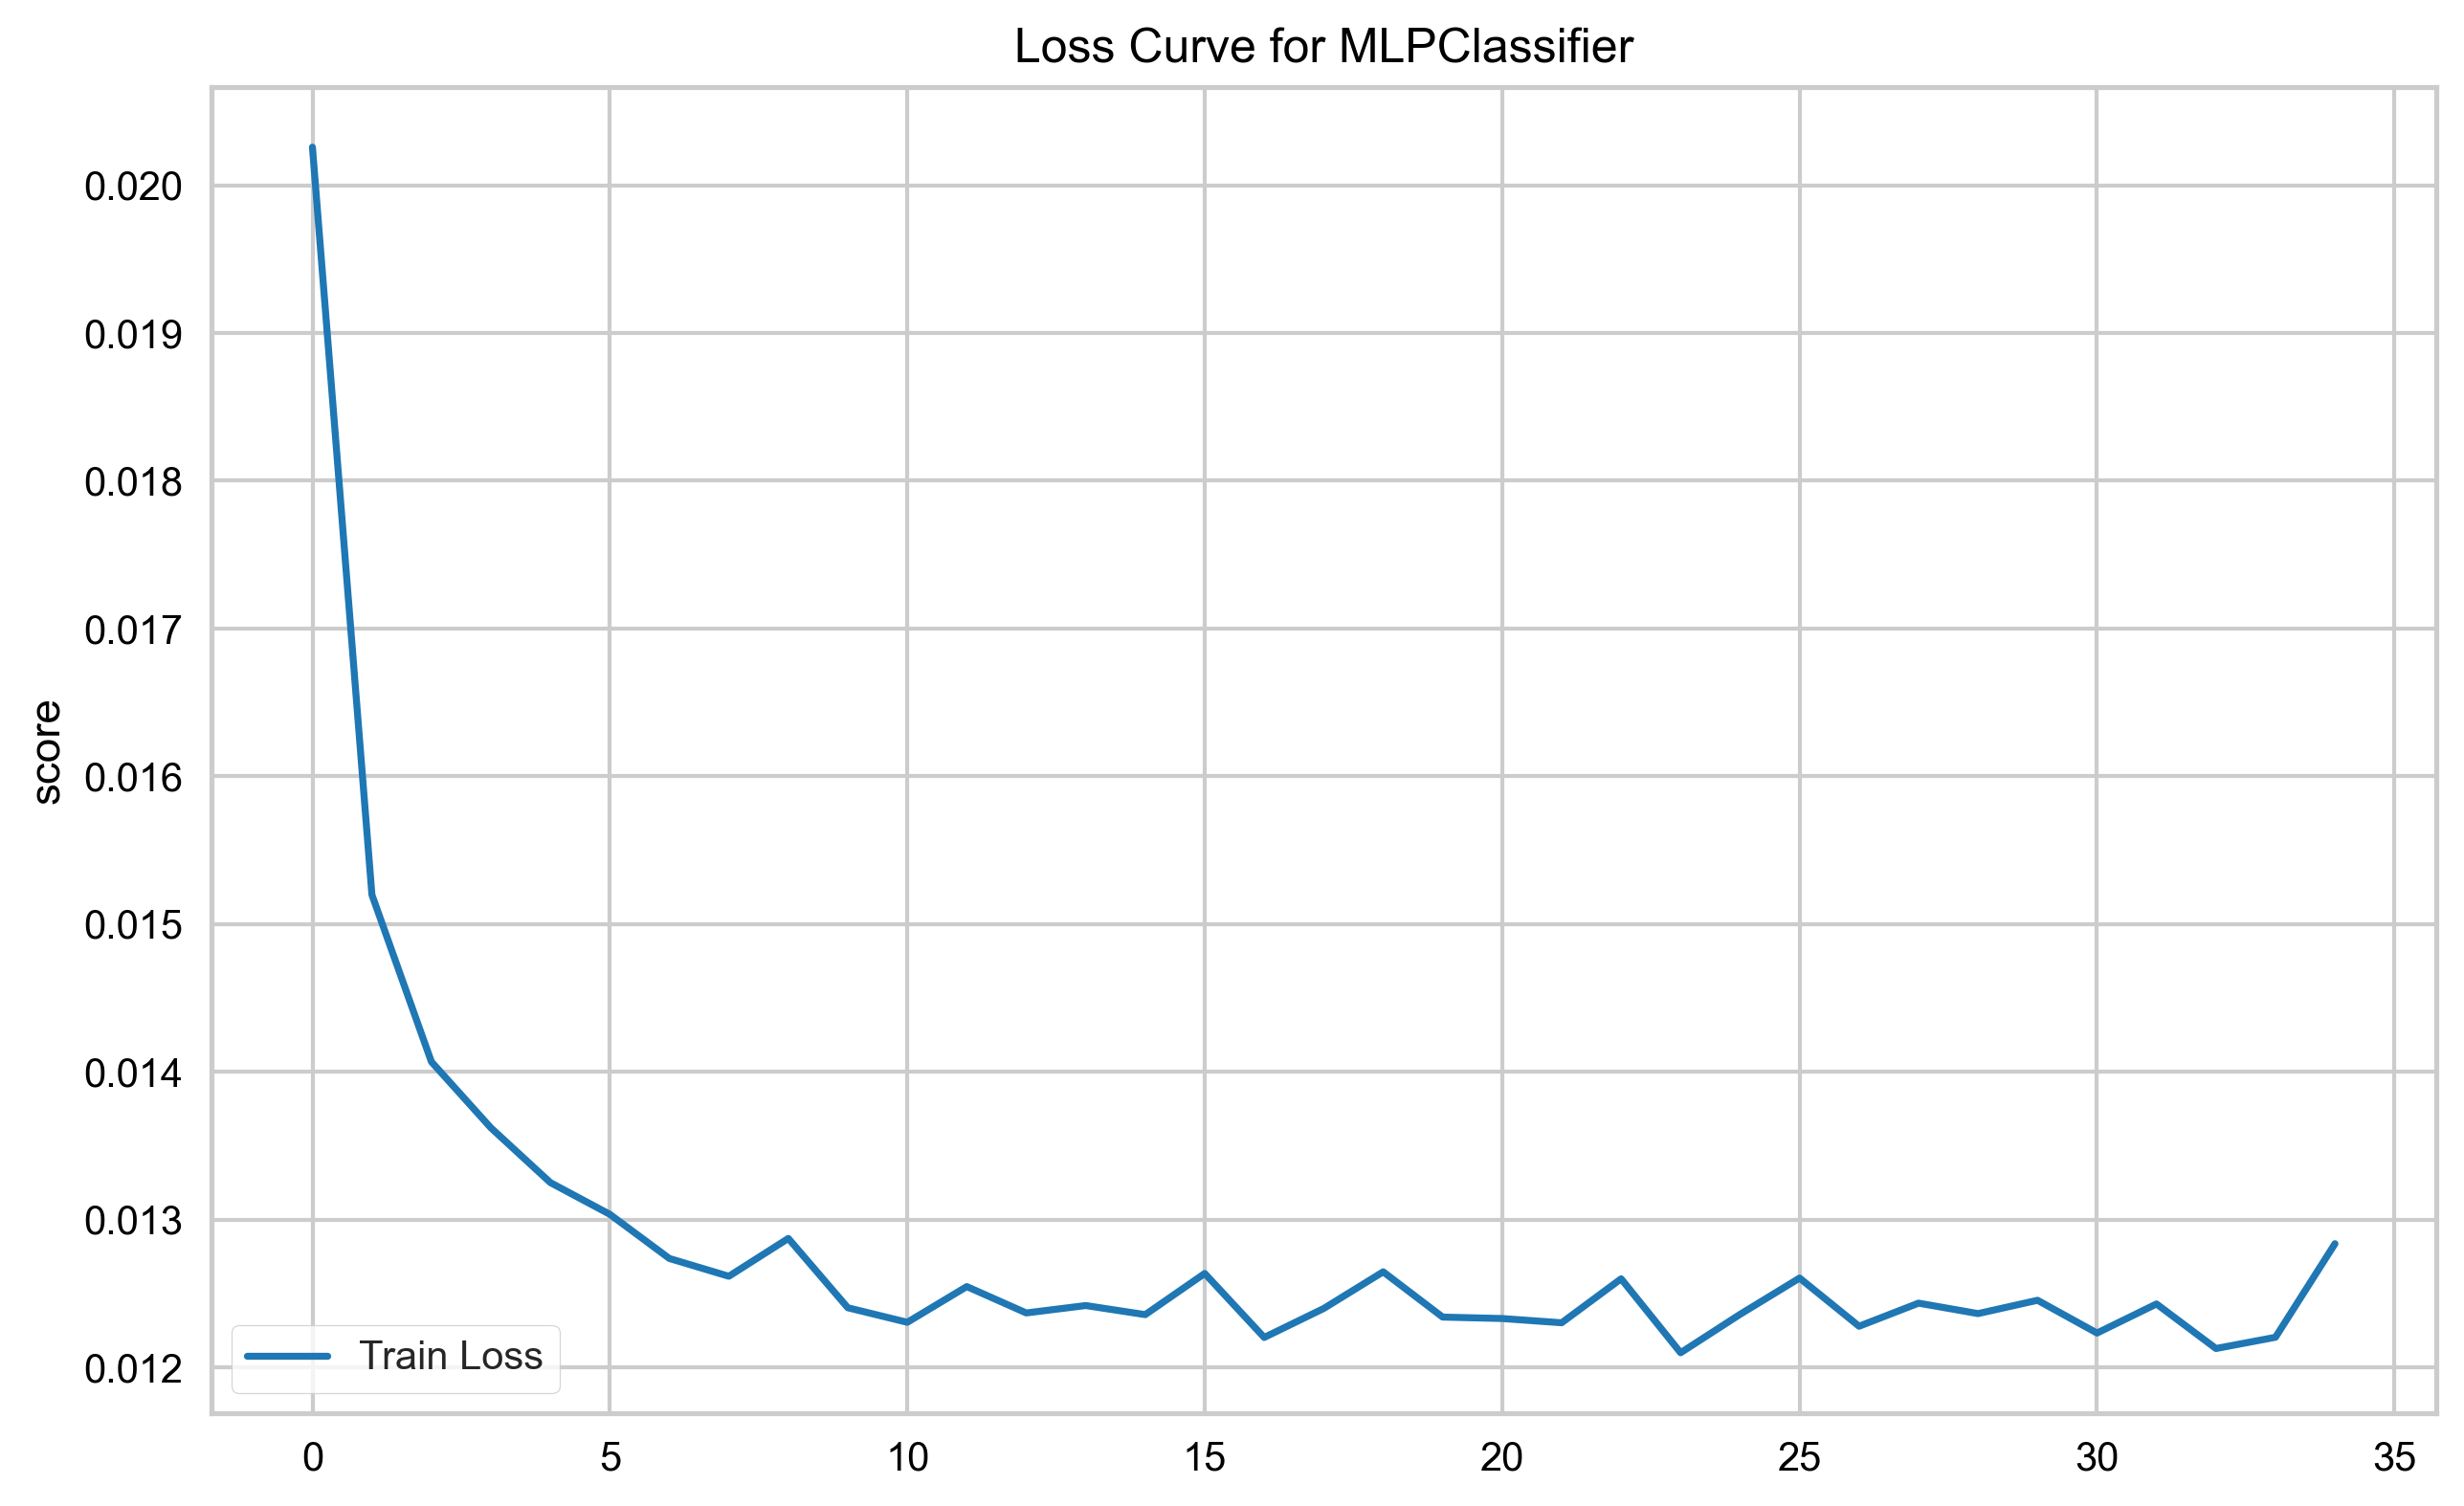

In [21]:
importlib.reload(viz)
best_mlp_clf = instantiate_best_mlp_clf()
best_mlp_clf.fit(X_train_n, y_train)

viz.loss_curve(best_mlp_clf, output_path=f"{CREDIT_CARDS_MLP_PATH}/loss_curves.png")

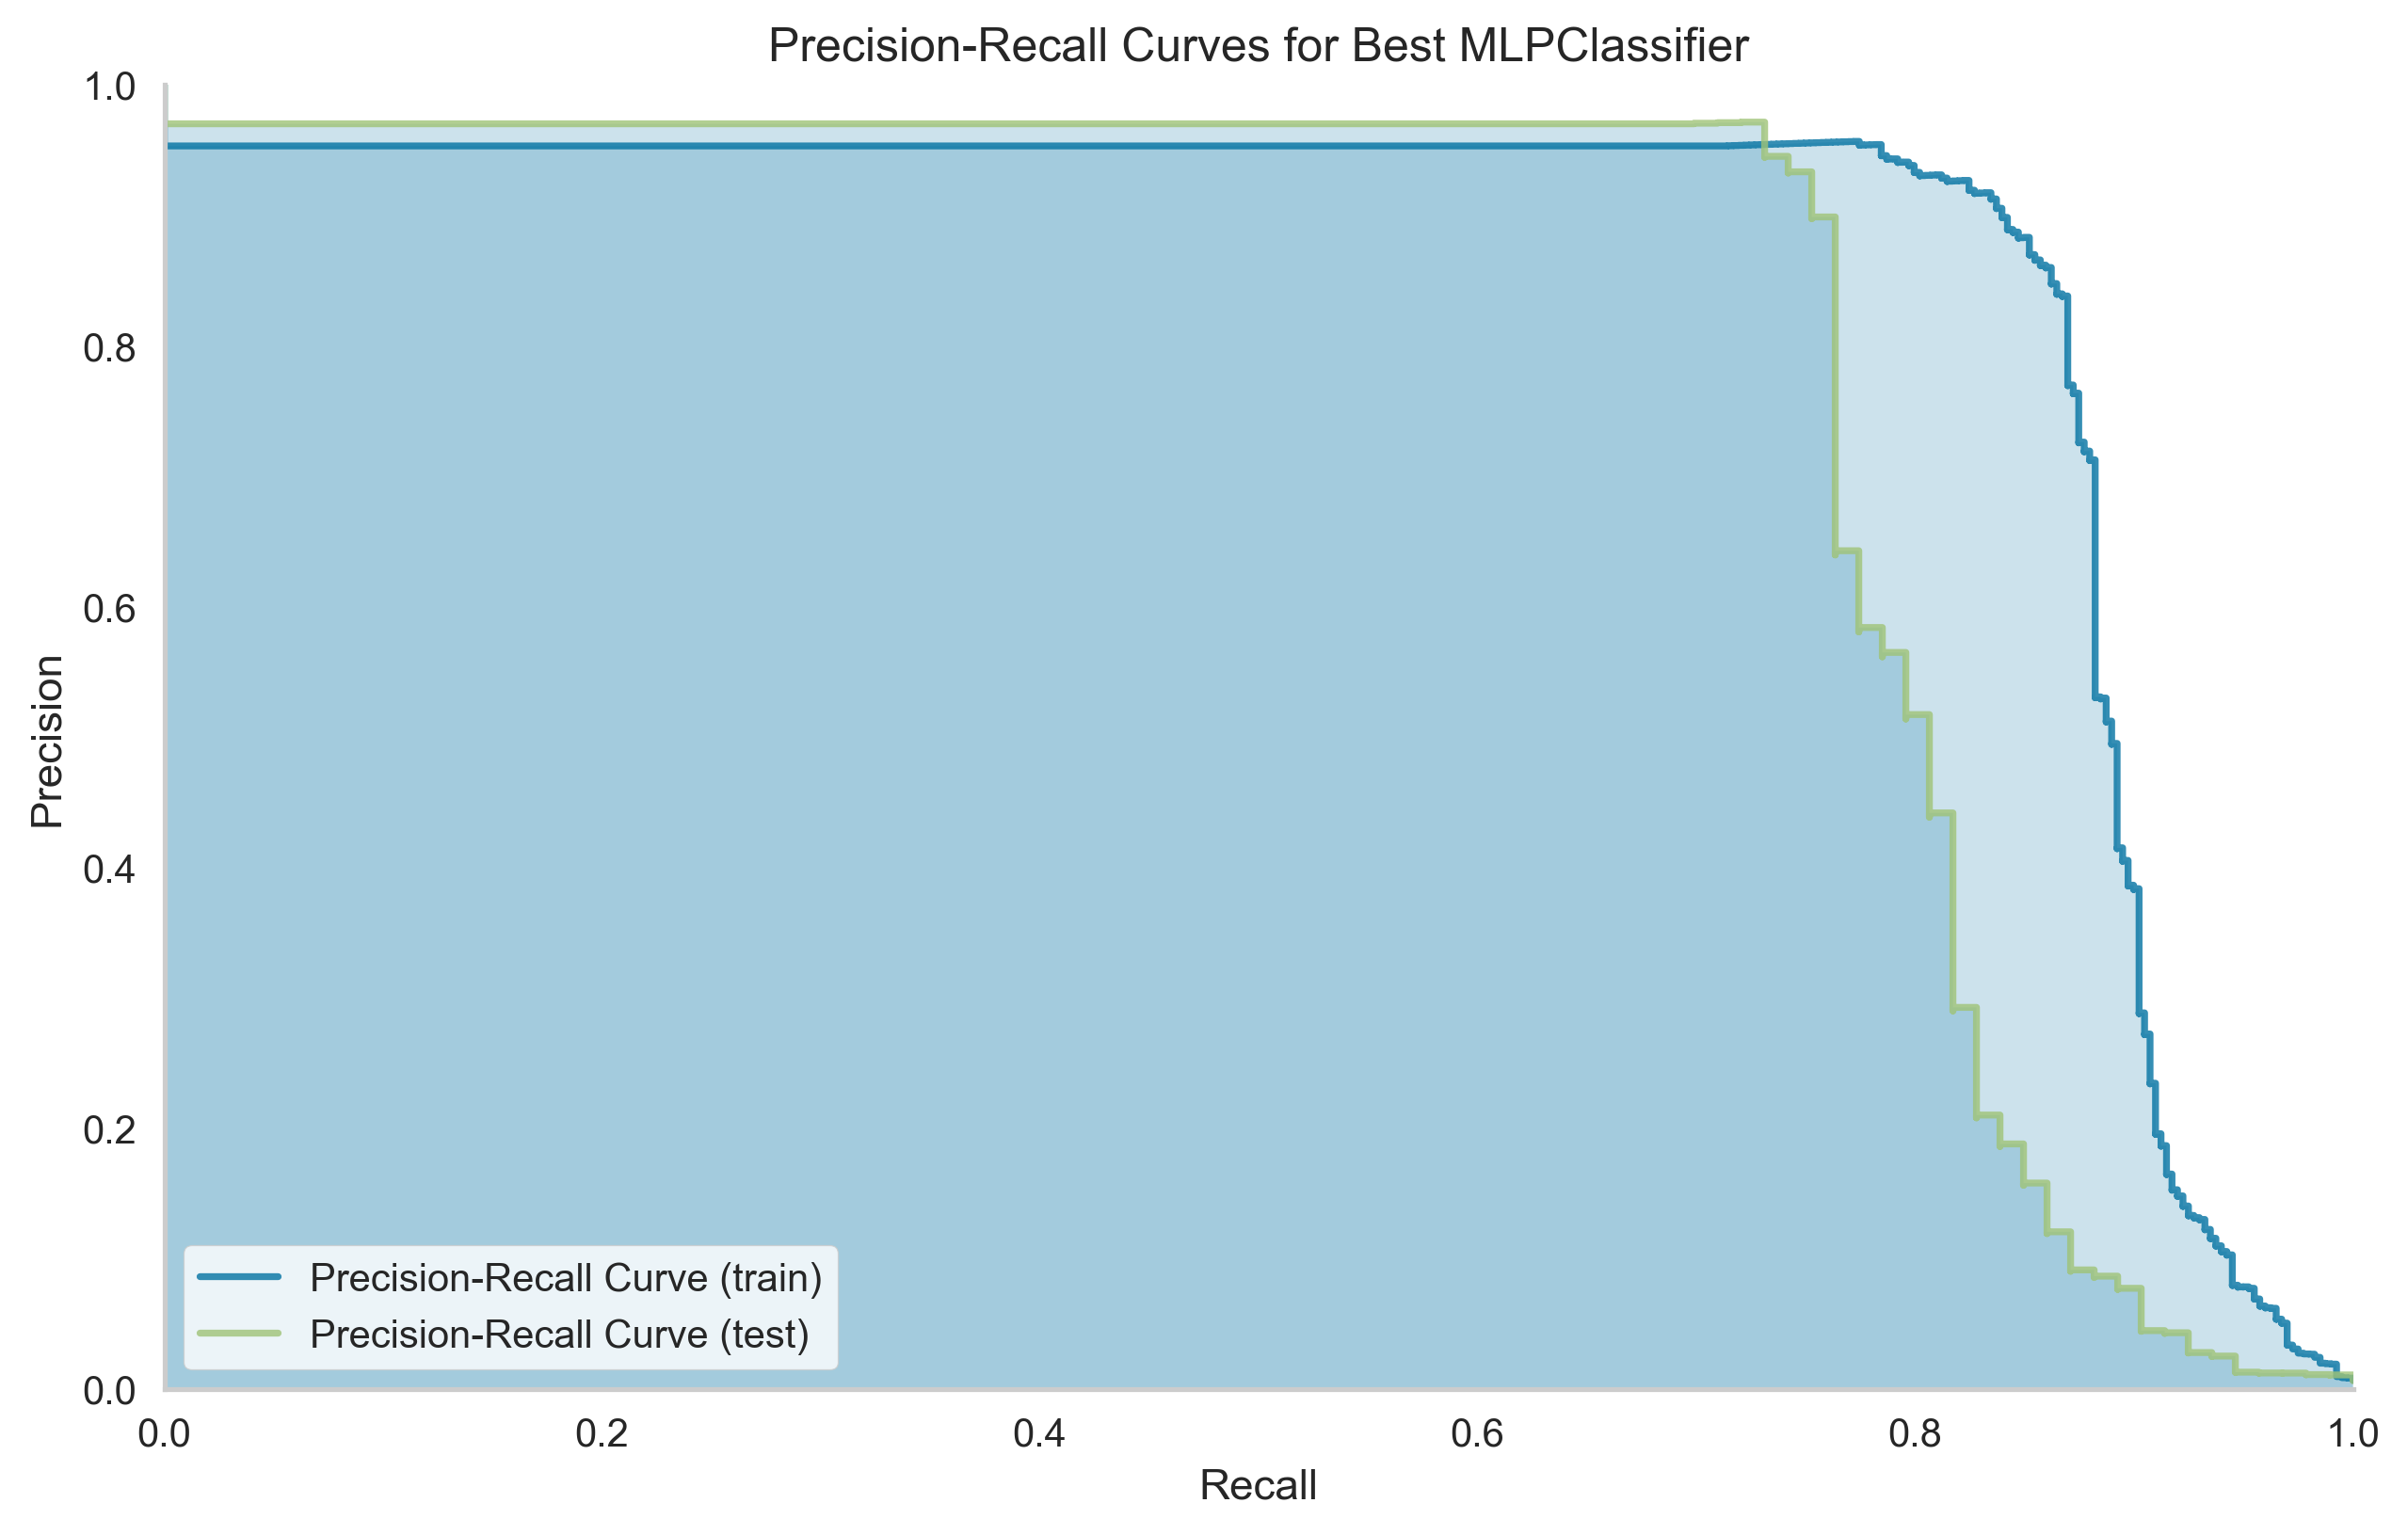

In [22]:
# best_mlp_clf = instantiate_best_svm_clf()
# best_mlp_clf.fit(X_train_n, y_train)
viz.precision_recall_curve(
    clf=best_mlp_clf,
    X_tr=X_train_n,
    y_tr=y_train,
    X_t=X_test_n,
    y_t=y_test,
    title='Precision-Recall Curves for Best MLP',
    output_path=f'{CREDIT_CARDS_MLP_PATH}/best_mlp_pr_curves.png'
)

In [23]:
metrics.recall_at_precision_stats(0.9,
                                  best_mlp_clf,
                                  X_tr=X_train_n,
                                  y_tr=y_train,
                                  X_t=X_test_n,
                                  y_t=y_test)


Recall @ Precision 0.9 (train): 0.8396
Recall @ Precision 0.9 (test) : 0.7527


In [24]:
best_mlp_clf = instantiate_best_mlp_clf()
training.learning_time_stats(best_mlp_clf, X_tr=X_train_n, y_tr=y_train)

Training time, total: 27.8913 seconds
Training time, normalized (per 1000 samples): 0.4871 seconds


In [25]:
training.inference_time_stats(best_mlp_clf, X_train_n, dataset_name='train')
training.inference_time_stats(best_mlp_clf, X_test_n, dataset_name='test')
training.inference_time_stats(best_mlp_clf, X_n, dataset_name='all')

Inference time (train), total: 0.0118 seconds
Inference time (train), normalized (per 1000 samples): 0.0002 seconds
Inference time (test), total: 0.0033 seconds
Inference time (test), normalized (per 1000 samples): 0.0002 seconds
Inference time (all), total: 0.0204 seconds
Inference time (all), normalized (per 1000 samples): 0.0003 seconds
